# 準備

In [1]:
#ライブラリーのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls

Untitled.ipynb
sample_submit.csv
test.csv
train.csv


In [8]:
data = pd.read_csv('train.csv')

In [9]:
data.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [12]:
data.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [67]:
data_rep=data.replace('Male', 0).replace('Female', 1)
data_new=data_rep.fillna(1.00)


In [68]:
data_new.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,0,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,1,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,0,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,0,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,1,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [79]:
data_new.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

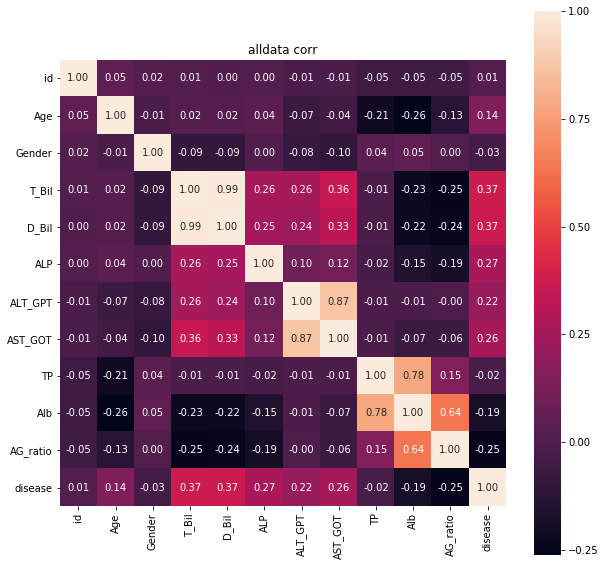

In [70]:
plt.figure(figsize=(10, 10))
plt.title('alldata corr')
sns.heatmap(data_new.corr(), square=True,annot=True,fmt='.2f')

# データ定義

In [185]:
X = data_new.select_dtypes(exclude=['object'])
X = X[X.columns[X.columns != 'disease' ]]


# 訓練データとテストデータに分割
y = data_new['disease']

# 訓練データとテストデータに分割するメソッドのインポート
from sklearn.model_selection import train_test_split 
# 訓練データ・テストデータへ6:4の比でランダムに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) 


# XGBoost+GridSearchCV

In [186]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, classification_report
# xgboostモデルの作成
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200],'min_child_weight':[0,5,15,300],'learning_rate':[0.1,0.15]}, verbose=1)
clf_cv.fit(X_train, y_train)
print (clf_cv.best_params_, clf_cv.best_score_)

# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_)
clf.fit(X_train, y_train)


C:\Users\tom9m\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   10.9s finished


{'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200} 0.8258426966292135


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.15, max_delta_step=0, max_depth=6,
       min_child_weight=5, missing=nan, monotone_constraints='()',
       n_estimators=200, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [187]:
clf.score(X_test,y_test)

0.8379888268156425

In [181]:
clf.score(X_train,y_train)

1.0

# CatBoost

In [172]:
import catboost
cat_features_index=[0,1,2]
mod = catboost.CatBoostClassifier(iterations=5000, 
                                  learning_rate=0.1,
                                  #calc_feature_importance = True, 
                                  use_best_model=True,
                                  eval_metric = 'Accuracy' )
mod.fit(X_train, y_train, 
        cat_features=cat_features_index,
        eval_set=(X_test, y_test), 
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7921348	test: 0.7765363	best: 0.7765363 (0)	total: 55.6ms	remaining: 4m 37s
1:	learn: 0.7949438	test: 0.7709497	best: 0.7765363 (0)	total: 98.8ms	remaining: 4m 6s
2:	learn: 0.8103933	test: 0.7821229	best: 0.7821229 (2)	total: 144ms	remaining: 3m 59s
3:	learn: 0.8216292	test: 0.7932961	best: 0.7932961 (3)	total: 174ms	remaining: 3m 37s
4:	learn: 0.8314607	test: 0.8156425	best: 0.8156425 (4)	total: 211ms	remaining: 3m 31s
5:	learn: 0.8356742	test: 0.8100559	best: 0.8156425 (4)	total: 252ms	remaining: 3m 29s
6:	learn: 0.8370787	test: 0.8100559	best: 0.8156425 (4)	total: 290ms	remaining: 3m 26s
7:	learn: 0.8426966	test: 0.8156425	best: 0.8156425 (4)	total: 310ms	remaining: 3m 13s
8:	learn: 0.8441011	test: 0.7932961	best: 0.8156425 (4)	total: 338ms	remaining: 3m 7s
9:	learn: 0.8426966	test: 0.7988827	best: 0.8156425 (4)	total: 365ms	remaining: 3m 1s
10:	learn: 0.8539326	test: 0.8044693	best: 0.8156425 (4)	total: 394ms	remaining: 2m 58s
11:	learn: 0.8553371	test: 0.8212291	best: 

93:	learn: 0.9845506	test: 0.8547486	best: 0.8603352 (91)	total: 4.14s	remaining: 3m 35s
94:	learn: 0.9845506	test: 0.8547486	best: 0.8603352 (91)	total: 4.17s	remaining: 3m 35s
95:	learn: 0.9845506	test: 0.8547486	best: 0.8603352 (91)	total: 4.21s	remaining: 3m 35s
96:	learn: 0.9845506	test: 0.8547486	best: 0.8603352 (91)	total: 4.26s	remaining: 3m 35s
97:	learn: 0.9845506	test: 0.8603352	best: 0.8603352 (91)	total: 4.3s	remaining: 3m 35s
98:	learn: 0.9859551	test: 0.8603352	best: 0.8603352 (91)	total: 4.37s	remaining: 3m 36s
99:	learn: 0.9859551	test: 0.8603352	best: 0.8603352 (91)	total: 4.42s	remaining: 3m 36s
100:	learn: 0.9845506	test: 0.8603352	best: 0.8603352 (91)	total: 4.47s	remaining: 3m 36s
101:	learn: 0.9845506	test: 0.8603352	best: 0.8603352 (91)	total: 4.51s	remaining: 3m 36s
102:	learn: 0.9845506	test: 0.8603352	best: 0.8603352 (91)	total: 4.55s	remaining: 3m 36s
103:	learn: 0.9859551	test: 0.8603352	best: 0.8603352 (91)	total: 4.58s	remaining: 3m 35s
104:	learn: 0.9859

184:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.14s	remaining: 3m 31s
185:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.19s	remaining: 3m 31s
186:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.22s	remaining: 3m 31s
187:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.25s	remaining: 3m 31s
188:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.3s	remaining: 3m 31s
189:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.33s	remaining: 3m 30s
190:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.34s	remaining: 3m 30s
191:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.38s	remaining: 3m 29s
192:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.4s	remaining: 3m 29s
193:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.45s	remaining: 3m 29s
194:	learn: 0.9985955	test: 0.8938547	best: 0.9050279 (168)	total: 8.49s	remaining: 3m 29s
1

275:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 11.9s	remaining: 3m 23s
276:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12s	remaining: 3m 23s
277:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12s	remaining: 3m 23s
278:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12s	remaining: 3m 23s
279:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12s	remaining: 3m 22s
280:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.1s	remaining: 3m 22s
281:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.1s	remaining: 3m 22s
282:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.1s	remaining: 3m 21s
283:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.1s	remaining: 3m 21s
284:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.2s	remaining: 3m 21s
285:	learn: 1.0000000	test: 0.8882682	best: 0.9050279 (168)	total: 12.2s	remaining: 3m 21s
286:	le

366:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.6s	remaining: 3m 16s
367:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.7s	remaining: 3m 17s
368:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.7s	remaining: 3m 16s
369:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.7s	remaining: 3m 16s
370:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.8s	remaining: 3m 16s
371:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.8s	remaining: 3m 16s
372:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.8s	remaining: 3m 16s
373:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.8s	remaining: 3m 15s
374:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.9s	remaining: 3m 15s
375:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.9s	remaining: 3m 15s
376:	learn: 1.0000000	test: 0.8826816	best: 0.9050279 (168)	total: 15.9s	remaining: 3m 15s

457:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 19.1s	remaining: 3m 9s
458:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 19.1s	remaining: 3m 9s
459:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 19.2s	remaining: 3m 9s
460:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 19.2s	remaining: 3m 9s
461:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.3s	remaining: 3m 9s
462:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.4s	remaining: 3m 10s
463:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.4s	remaining: 3m 9s
464:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.5s	remaining: 3m 9s
465:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.5s	remaining: 3m 9s
466:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.6s	remaining: 3m 9s
467:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 19.6s	remaining: 3m 9s
468:	lear

549:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 22.8s	remaining: 3m 4s
550:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 22.8s	remaining: 3m 4s
551:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 22.9s	remaining: 3m 4s
552:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 22.9s	remaining: 3m 4s
553:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 22.9s	remaining: 3m 4s
554:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23s	remaining: 3m 4s
555:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23s	remaining: 3m 3s
556:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23.1s	remaining: 3m 3s
557:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23.1s	remaining: 3m 3s
558:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23.1s	remaining: 3m 3s
559:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 23.2s	remaining: 3m 3s
560:	learn: 1.

641:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.2s	remaining: 2m 57s
642:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.2s	remaining: 2m 57s
643:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.2s	remaining: 2m 57s
644:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.3s	remaining: 2m 57s
645:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.3s	remaining: 2m 57s
646:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.3s	remaining: 2m 57s
647:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.4s	remaining: 2m 57s
648:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.4s	remaining: 2m 57s
649:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.5s	remaining: 2m 57s
650:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.5s	remaining: 2m 57s
651:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 26.5s	remaining: 2m 56s

732:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.6s	remaining: 2m 52s
733:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.6s	remaining: 2m 51s
734:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.6s	remaining: 2m 51s
735:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.7s	remaining: 2m 51s
736:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.7s	remaining: 2m 51s
737:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.7s	remaining: 2m 51s
738:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.8s	remaining: 2m 51s
739:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.8s	remaining: 2m 51s
740:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.8s	remaining: 2m 51s
741:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.8s	remaining: 2m 51s
742:	learn: 1.0000000	test: 0.8938547	best: 0.9050279 (168)	total: 29.9s	remaining: 2m 51s

823:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.2s	remaining: 2m 43s
824:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.2s	remaining: 2m 42s
825:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.2s	remaining: 2m 42s
826:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.3s	remaining: 2m 42s
827:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.3s	remaining: 2m 42s
828:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.4s	remaining: 2m 42s
829:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.4s	remaining: 2m 42s
830:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.4s	remaining: 2m 42s
831:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.5s	remaining: 2m 42s
832:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.5s	remaining: 2m 42s
833:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 32.5s	remaining: 2m 42s

914:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.6s	remaining: 2m 38s
915:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.6s	remaining: 2m 38s
916:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.7s	remaining: 2m 38s
917:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.7s	remaining: 2m 38s
918:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.8s	remaining: 2m 38s
919:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.8s	remaining: 2m 38s
920:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.9s	remaining: 2m 38s
921:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.9s	remaining: 2m 38s
922:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.9s	remaining: 2m 38s
923:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 35.9s	remaining: 2m 38s
924:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 36s	remaining: 2m 38s
9

1005:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 37.9s	remaining: 2m 30s
1006:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 37.9s	remaining: 2m 30s
1007:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 37.9s	remaining: 2m 30s
1008:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 37.9s	remaining: 2m 30s
1009:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 30s
1010:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
1011:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
1012:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
1013:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
1014:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
1015:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 38s	remaining: 2m 29s
10

1095:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.8s	remaining: 2m 21s
1096:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.8s	remaining: 2m 21s
1097:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.8s	remaining: 2m 21s
1098:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 21s
1099:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 21s
1100:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 21s
1101:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 21s
1102:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 20s
1103:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 20s
1104:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 39.9s	remaining: 2m 20s
1105:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 40s	remainin

1185:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.4s	remaining: 2m 16s
1186:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.4s	remaining: 2m 16s
1187:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.5s	remaining: 2m 16s
1188:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.5s	remaining: 2m 16s
1189:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.5s	remaining: 2m 16s
1190:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.5s	remaining: 2m 16s
1191:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.6s	remaining: 2m 16s
1192:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.6s	remaining: 2m 15s
1193:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 42.6s	remaining: 2m 15s
1194:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 42.6s	remaining: 2m 15s
1195:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 42.6s	remain

1275:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.3s	remaining: 2m 12s
1276:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.3s	remaining: 2m 12s
1277:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.3s	remaining: 2m 11s
1278:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.4s	remaining: 2m 11s
1279:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.4s	remaining: 2m 11s
1280:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.4s	remaining: 2m 11s
1281:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.4s	remaining: 2m 11s
1282:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.4s	remaining: 2m 11s
1283:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.5s	remaining: 2m 11s
1284:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.5s	remaining: 2m 11s
1285:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 45.5s	remain

1365:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.4s	remaining: 2m 6s
1366:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.4s	remaining: 2m 5s
1367:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.4s	remaining: 2m 5s
1368:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.4s	remaining: 2m 5s
1369:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.5s	remaining: 2m 5s
1370:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.5s	remaining: 2m 5s
1371:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.6s	remaining: 2m 5s
1372:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.6s	remaining: 2m 5s
1373:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.6s	remaining: 2m 5s
1374:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.7s	remaining: 2m 5s
1375:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 47.8s	remaining: 2m 5s

1456:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.3s	remaining: 1m 59s
1457:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.3s	remaining: 1m 59s
1458:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1459:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1460:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1461:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1462:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1463:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1464:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1465:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remaining: 1m 59s
1466:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 49.4s	remain

1546:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.6s	remaining: 1m 55s
1547:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.6s	remaining: 1m 55s
1548:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.6s	remaining: 1m 54s
1549:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1550:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1551:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1552:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1553:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1554:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1555:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remaining: 1m 54s
1556:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 51.7s	remain

1636:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 49s
1637:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 49s
1638:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 49s
1639:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 49s
1640:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 48s
1641:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 48s
1642:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.2s	remaining: 1m 48s
1643:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.3s	remaining: 1m 48s
1644:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.3s	remaining: 1m 48s
1645:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.3s	remaining: 1m 48s
1646:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 53.3s	remain

1726:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1727:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1728:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1729:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1730:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1731:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.3s	remaining: 1m 42s
1732:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.4s	remaining: 1m 42s
1733:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.4s	remaining: 1m 42s
1734:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.4s	remaining: 1m 42s
1735:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.4s	remaining: 1m 42s
1736:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 54.4s	remain

1816:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 37s
1817:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 37s
1818:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 37s
1819:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 36s
1820:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 36s
1821:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 36s
1822:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.5s	remaining: 1m 36s
1823:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.6s	remaining: 1m 36s
1824:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.6s	remaining: 1m 36s
1825:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.6s	remaining: 1m 36s
1826:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 55.7s	remain

1906:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1907:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1908:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1909:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1910:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1911:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1912:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1913:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1914:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 32s
1915:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remaining: 1m 31s
1916:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 57.1s	remain

1996:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
1997:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
1998:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
1999:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2000:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2001:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2002:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2003:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2004:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 58.9s	remaining: 1m 28s
2005:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 59s	remaining: 1m 28s
2006:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 59s	remaining:

2087:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2088:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2089:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2090:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2091:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2092:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2093:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 24s
2094:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 23s
2095:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 23s
2096:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 23s
2097:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m	remaining: 1m 23s
2098:	learn: 1.000000

2177:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2178:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2179:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2180:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2181:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2182:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2183:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2184:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2185:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2186:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remaining: 1m 20s
2187:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 2s	remain

2267:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2268:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2269:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2270:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2271:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2272:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 16s
2273:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 15s
2274:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 15s
2275:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 15s
2276:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remaining: 1m 15s
2277:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 3s	remain

2357:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2358:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2359:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2360:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2361:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2362:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 12s
2363:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 11s
2364:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 11s
2365:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 11s
2366:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remaining: 1m 11s
2367:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 4s	remain

2447:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2448:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2449:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2450:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2451:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2452:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2453:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2454:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2455:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2456:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s
2457:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 5s	remaining: 1m 8s

2538:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2539:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2540:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2541:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2542:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2543:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2544:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2545:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2546:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2547:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s
2548:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 6s	remaining: 1m 4s

2629:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2630:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2631:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2632:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2633:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2634:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2635:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2636:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2637:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2638:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2639:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 7s	remaining: 1m
2640:	learn: 1.0000000	test: 0.9

2720:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57.2s
2721:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57.2s
2722:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57.1s
2723:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57.1s
2724:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57s
2725:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57s
2726:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 57s
2727:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 56.9s
2728:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 56.9s
2729:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 56.8s
2730:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 8s	remaining: 56.8s
2731:

2811:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 54s
2812:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.9s
2813:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.9s
2814:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2815:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2816:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2817:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2818:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2819:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2820:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.8s
2821:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 9s	remaining: 53.7s
2

2901:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 51s
2902:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 51s
2903:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.9s
2904:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.9s
2905:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.9s
2906:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.8s
2907:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.8s
2908:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.8s
2909:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.7s
2910:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining: 50.7s
2911:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 10s	remaining

2991:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 48.1s
2992:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 48.1s
2993:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 48s
2994:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 48s
2995:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.9s
2996:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.9s
2997:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.9s
2998:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.8s
2999:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.8s
3000:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining: 47.8s
3001:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 11s	remaining

3081:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 12s	remaining: 45.4s
3082:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 12s	remaining: 45.3s
3083:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 12s	remaining: 45.3s
3084:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 12s	remaining: 45.3s
3085:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 12s	remaining: 45.2s
3086:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 45.2s
3087:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 45.2s
3088:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 45.2s
3089:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 45.1s
3090:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 45.1s
3091:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remai

3171:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.6s
3172:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.5s
3173:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.5s
3174:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.5s
3175:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.4s
3176:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.4s
3177:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.4s
3178:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.3s
3179:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.3s
3180:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remaining: 42.3s
3181:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 13s	remai

3261:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 14s	remaining: 40s
3262:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 14s	remaining: 39.9s
3263:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.9s
3264:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.9s
3265:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.8s
3266:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.8s
3267:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.8s
3268:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.7s
3269:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.7s
3270:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaining: 39.7s
3271:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 15s	remaini

3351:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.5s
3352:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.5s
3353:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.5s
3354:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.5s
3355:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.4s
3356:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.4s
3357:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.4s
3358:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.3s
3359:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.3s
3360:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remaining: 37.3s
3361:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 16s	remai

3441:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 35.1s
3442:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 35.1s
3443:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 35s
3444:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 35s
3445:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 35s
3446:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 34.9s
3447:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 34.9s
3448:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 34.9s
3449:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 34.9s
3450:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 34.8s
3451:	learn: 1.0000000	test: 0.9050279	best: 0.9050279 (168)	total: 1m 17s	remaining: 

3531:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.9s
3532:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.9s
3533:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.9s
3534:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.9s
3535:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3536:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3537:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3538:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3539:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3540:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remaining: 32.8s
3541:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 19s	remai

3621:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.8s
3622:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.8s
3623:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.8s
3624:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.7s
3625:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.7s
3626:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.7s
3627:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.6s
3628:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.6s
3629:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.6s
3630:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remaining: 30.6s
3631:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 21s	remai

3711:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.7s
3712:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.7s
3713:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.7s
3714:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.7s
3715:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.6s
3716:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.6s
3717:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 22s	remaining: 28.6s
3718:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 28.6s
3719:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 28.6s
3720:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 28.6s
3721:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remai

3801:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.4s
3802:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.4s
3803:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.4s
3804:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.4s
3805:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.3s
3806:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.3s
3807:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.3s
3808:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.3s
3809:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.2s
3810:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 23s	remaining: 26.2s
3811:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remai

3891:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24.1s
3892:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24.1s
3893:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24.1s
3894:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24s
3895:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24s
3896:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24s
3897:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 24s
3898:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 23.9s
3899:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 23.9s
3900:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 23.9s
3901:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 24s	remaining: 23

3981:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.9s
3982:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.9s
3983:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.9s
3984:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.9s
3985:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.8s
3986:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.8s
3987:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.8s
3988:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.7s
3989:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.7s
3990:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remaining: 21.7s
3991:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 25s	remai

4071:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.8s
4072:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.8s
4073:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.7s
4074:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.7s
4075:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.7s
4076:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.7s
4077:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.6s
4078:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.6s
4079:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.6s
4080:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remaining: 19.6s
4081:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 26s	remai

4161:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.7s
4162:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.7s
4163:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.7s
4164:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.7s
4165:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4166:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4167:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4168:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4169:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4170:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remaining: 17.6s
4171:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 28s	remai

4251:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.7s
4252:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.6s
4253:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.6s
4254:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.6s
4255:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.6s
4256:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.5s
4257:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.5s
4258:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.5s
4259:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.5s
4260:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remaining: 15.4s
4261:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 29s	remai

4341:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.7s
4342:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.7s
4343:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.7s
4344:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.7s
4345:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.6s
4346:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.6s
4347:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.6s
4348:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.6s
4349:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.5s
4350:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remaining: 13.5s
4351:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 30s	remai

4431:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.8s
4432:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.7s
4433:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.7s
4434:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.7s
4435:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.7s
4436:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.6s
4437:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.6s
4438:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.6s
4439:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.6s
4440:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remaining: 11.6s
4441:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 31s	remai

4521:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.81s
4522:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.79s
4523:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.77s
4524:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.75s
4525:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.72s
4526:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.7s
4527:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.68s
4528:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.66s
4529:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.64s
4530:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remaining: 9.62s
4531:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 32s	remain

4611:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 33s	remaining: 7.91s
4612:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.89s
4613:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.87s
4614:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.84s
4615:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.82s
4616:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.8s
4617:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.78s
4618:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.76s
4619:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.74s
4620:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remaining: 7.72s
4621:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 34s	remain

4701:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 6.03s
4702:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 6.01s
4703:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.99s
4704:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.97s
4705:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.95s
4706:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.93s
4707:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.91s
4708:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.89s
4709:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.87s
4710:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remaining: 5.84s
4711:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 35s	remai

4791:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.2s
4792:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.17s
4793:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.15s
4794:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.13s
4795:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.11s
4796:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.09s
4797:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.07s
4798:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.05s
4799:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.03s
4800:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remaining: 4.01s
4801:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 36s	remain

4881:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.37s
4882:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.35s
4883:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.33s
4884:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.31s
4885:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.29s
4886:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.27s
4887:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.25s
4888:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.23s
4889:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.21s
4890:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remaining: 2.19s
4891:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 38s	remai

4971:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 562ms
4972:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 542ms
4973:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 522ms
4974:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 502ms
4975:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 482ms
4976:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 462ms
4977:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 442ms
4978:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 422ms
4979:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 401ms
4980:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remaining: 381ms
4981:	learn: 1.0000000	test: 0.8994413	best: 0.9050279 (168)	total: 1m 39s	remai

In [177]:
mod.score(X_test,y_test)

0.9050279329608939

In [188]:
mod.score(X_test,y_test)

0.9776536312849162

In [174]:
mod.score(X_train,y_train)

0.9957865168539326

In [176]:
import catboost
cat_features_index=[0,1,2]
mod1 = catboost.CatBoostClassifier(iterations=5000, 
                                  learning_rate=0.05,
                                  #calc_feature_importance = True, 
                                  use_best_model=True,
                                  eval_metric = 'Accuracy' )
mod1.fit(X_train, y_train, 
        cat_features=cat_features_index,
        eval_set=(X_test, y_test), 
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7921348	test: 0.7765363	best: 0.7765363 (0)	total: 57.1ms	remaining: 4m 45s
1:	learn: 0.7949438	test: 0.7709497	best: 0.7765363 (0)	total: 108ms	remaining: 4m 30s
2:	learn: 0.8188202	test: 0.7765363	best: 0.7765363 (0)	total: 160ms	remaining: 4m 26s
3:	learn: 0.8216292	test: 0.7877095	best: 0.7877095 (3)	total: 193ms	remaining: 4m
4:	learn: 0.8202247	test: 0.7877095	best: 0.7877095 (3)	total: 233ms	remaining: 3m 52s
5:	learn: 0.8356742	test: 0.8044693	best: 0.8044693 (5)	total: 275ms	remaining: 3m 49s
6:	learn: 0.8286517	test: 0.8100559	best: 0.8100559 (6)	total: 319ms	remaining: 3m 47s
7:	learn: 0.8286517	test: 0.8100559	best: 0.8100559 (6)	total: 345ms	remaining: 3m 35s
8:	learn: 0.8342697	test: 0.8044693	best: 0.8100559 (6)	total: 372ms	remaining: 3m 26s
9:	learn: 0.8370787	test: 0.8044693	best: 0.8100559 (6)	total: 402ms	remaining: 3m 20s
10:	learn: 0.8455056	test: 0.7821229	best: 0.8100559 (6)	total: 431ms	remaining: 3m 15s
11:	learn: 0.8455056	test: 0.7877095	best: 0.

93:	learn: 0.9283708	test: 0.8715084	best: 0.8715084 (91)	total: 4.19s	remaining: 3m 38s
94:	learn: 0.9297753	test: 0.8659218	best: 0.8715084 (91)	total: 4.24s	remaining: 3m 38s
95:	learn: 0.9311798	test: 0.8659218	best: 0.8715084 (91)	total: 4.28s	remaining: 3m 38s
96:	learn: 0.9339888	test: 0.8770950	best: 0.8770950 (96)	total: 4.31s	remaining: 3m 37s
97:	learn: 0.9339888	test: 0.8659218	best: 0.8770950 (96)	total: 4.36s	remaining: 3m 37s
98:	learn: 0.9353933	test: 0.8547486	best: 0.8770950 (96)	total: 4.39s	remaining: 3m 37s
99:	learn: 0.9367978	test: 0.8547486	best: 0.8770950 (96)	total: 4.43s	remaining: 3m 36s
100:	learn: 0.9382022	test: 0.8547486	best: 0.8770950 (96)	total: 4.46s	remaining: 3m 36s
101:	learn: 0.9382022	test: 0.8547486	best: 0.8770950 (96)	total: 4.49s	remaining: 3m 35s
102:	learn: 0.9382022	test: 0.8547486	best: 0.8770950 (96)	total: 4.53s	remaining: 3m 35s
103:	learn: 0.9396067	test: 0.8547486	best: 0.8770950 (96)	total: 4.55s	remaining: 3m 34s
104:	learn: 0.941

184:	learn: 0.9873596	test: 0.8882682	best: 0.8882682 (117)	total: 7.85s	remaining: 3m 24s
185:	learn: 0.9873596	test: 0.8882682	best: 0.8882682 (117)	total: 7.9s	remaining: 3m 24s
186:	learn: 0.9859551	test: 0.8826816	best: 0.8882682 (117)	total: 7.92s	remaining: 3m 23s
187:	learn: 0.9859551	test: 0.8826816	best: 0.8882682 (117)	total: 7.96s	remaining: 3m 23s
188:	learn: 0.9859551	test: 0.8826816	best: 0.8882682 (117)	total: 7.97s	remaining: 3m 22s
189:	learn: 0.9859551	test: 0.8938547	best: 0.8938547 (189)	total: 8s	remaining: 3m 22s
190:	learn: 0.9859551	test: 0.8938547	best: 0.8938547 (189)	total: 8.04s	remaining: 3m 22s
191:	learn: 0.9873596	test: 0.8938547	best: 0.8938547 (189)	total: 8.08s	remaining: 3m 22s
192:	learn: 0.9873596	test: 0.8938547	best: 0.8938547 (189)	total: 8.12s	remaining: 3m 22s
193:	learn: 0.9887640	test: 0.8882682	best: 0.8938547 (189)	total: 8.15s	remaining: 3m 21s
194:	learn: 0.9887640	test: 0.8882682	best: 0.8938547 (189)	total: 8.2s	remaining: 3m 22s
195:

275:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.6s	remaining: 3m 18s
276:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.6s	remaining: 3m 18s
277:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.7s	remaining: 3m 18s
278:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.7s	remaining: 3m 18s
279:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.8s	remaining: 3m 18s
280:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.8s	remaining: 3m 18s
281:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.9s	remaining: 3m 18s
282:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.9s	remaining: 3m 18s
283:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 11.9s	remaining: 3m 18s
284:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 12s	remaining: 3m 18s
285:	learn: 0.9985955	test: 0.8938547	best: 0.8938547 (189)	total: 12s	remaining: 3m 18s
286

366:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.3s	remaining: 3m 12s
367:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.3s	remaining: 3m 12s
368:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.4s	remaining: 3m 12s
369:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.4s	remaining: 3m 12s
370:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.4s	remaining: 3m 12s
371:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.5s	remaining: 3m 12s
372:	learn: 1.0000000	test: 0.8994413	best: 0.8994413 (294)	total: 15.5s	remaining: 3m 12s
373:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 15.5s	remaining: 3m 12s
374:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 15.6s	remaining: 3m 12s
375:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 15.6s	remaining: 3m 12s
376:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 15.7s	remaining: 3m 12s

457:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 19.1s	remaining: 3m 9s
458:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 19.2s	remaining: 3m 9s
459:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 19.2s	remaining: 3m 9s
460:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 19.2s	remaining: 3m 9s
461:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.2s	remaining: 3m 9s
462:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.3s	remaining: 3m 8s
463:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.3s	remaining: 3m 8s
464:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.3s	remaining: 3m 8s
465:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.3s	remaining: 3m 7s
466:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.4s	remaining: 3m 7s
467:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 19.4s	remaining: 3m 7s
468:	learn

549:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.4s	remaining: 3m 1s
550:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.5s	remaining: 3m 1s
551:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.5s	remaining: 3m 1s
552:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.6s	remaining: 3m 1s
553:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.6s	remaining: 3m 1s
554:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.6s	remaining: 3m 1s
555:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.7s	remaining: 3m 1s
556:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.8s	remaining: 3m 1s
557:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.8s	remaining: 3m 1s
558:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.8s	remaining: 3m 1s
559:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 22.8s	remaining: 3m 1s
560:	learn

641:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26s	remaining: 2m 56s
642:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26s	remaining: 2m 56s
643:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.1s	remaining: 2m 56s
644:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.1s	remaining: 2m 56s
645:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.2s	remaining: 2m 56s
646:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.2s	remaining: 2m 56s
647:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.2s	remaining: 2m 56s
648:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.3s	remaining: 2m 56s
649:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.3s	remaining: 2m 56s
650:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.4s	remaining: 2m 56s
651:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 26.4s	remaining: 2m 56s
652

732:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 29.7s	remaining: 2m 52s
733:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 29.7s	remaining: 2m 52s
734:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 29.7s	remaining: 2m 52s
735:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 29.8s	remaining: 2m 52s
736:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 29.8s	remaining: 2m 52s
737:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 29.9s	remaining: 2m 52s
738:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 29.9s	remaining: 2m 52s
739:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 30s	remaining: 2m 52s
740:	learn: 1.0000000	test: 0.8938547	best: 0.8994413 (294)	total: 30s	remaining: 2m 52s
741:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 30s	remaining: 2m 52s
742:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 30.1s	remaining: 2m 52s
743:	

823:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.2s	remaining: 2m 48s
824:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.3s	remaining: 2m 48s
825:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.3s	remaining: 2m 48s
826:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.3s	remaining: 2m 48s
827:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.4s	remaining: 2m 48s
828:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.4s	remaining: 2m 48s
829:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.4s	remaining: 2m 47s
830:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.5s	remaining: 2m 47s
831:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.5s	remaining: 2m 47s
832:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.5s	remaining: 2m 47s
833:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 33.6s	remaining: 2m 47s

914:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37s	remaining: 2m 45s
915:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.1s	remaining: 2m 45s
916:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.1s	remaining: 2m 45s
917:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.1s	remaining: 2m 45s
918:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.1s	remaining: 2m 44s
919:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.2s	remaining: 2m 44s
920:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.2s	remaining: 2m 44s
921:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.3s	remaining: 2m 44s
922:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.3s	remaining: 2m 44s
923:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.4s	remaining: 2m 44s
924:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 37.4s	remaining: 2m 44s
9

1005:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.5s	remaining: 2m 40s
1006:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.5s	remaining: 2m 40s
1007:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.6s	remaining: 2m 40s
1008:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.6s	remaining: 2m 40s
1009:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.6s	remaining: 2m 40s
1010:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.6s	remaining: 2m 40s
1011:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.7s	remaining: 2m 40s
1012:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.7s	remaining: 2m 40s
1013:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.7s	remaining: 2m 40s
1014:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.7s	remaining: 2m 39s
1015:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 40.8s	remain

1095:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.3s	remaining: 2m 34s
1096:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.3s	remaining: 2m 34s
1097:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.4s	remaining: 2m 34s
1098:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.4s	remaining: 2m 33s
1099:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.4s	remaining: 2m 33s
1100:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.5s	remaining: 2m 33s
1101:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.5s	remaining: 2m 33s
1102:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.6s	remaining: 2m 33s
1103:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.6s	remaining: 2m 33s
1104:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.7s	remaining: 2m 34s
1105:	learn: 1.0000000	test: 0.8770950	best: 0.8994413 (294)	total: 43.7s	remain

1185:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.6s	remaining: 2m 29s
1186:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.6s	remaining: 2m 29s
1187:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.7s	remaining: 2m 29s
1188:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.7s	remaining: 2m 29s
1189:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.8s	remaining: 2m 29s
1190:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.8s	remaining: 2m 29s
1191:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.8s	remaining: 2m 29s
1192:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.9s	remaining: 2m 29s
1193:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.9s	remaining: 2m 29s
1194:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 46.9s	remaining: 2m 29s
1195:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 47s	remainin

1275:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 49.8s	remaining: 2m 25s
1276:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 49.8s	remaining: 2m 25s
1277:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 49.8s	remaining: 2m 25s
1278:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 49.9s	remaining: 2m 25s
1279:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 49.9s	remaining: 2m 25s
1280:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50s	remaining: 2m 25s
1281:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50s	remaining: 2m 25s
1282:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50s	remaining: 2m 24s
1283:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50.1s	remaining: 2m 25s
1284:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50.2s	remaining: 2m 25s
1285:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 50.2s	remaining: 2

1365:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53s	remaining: 2m 20s
1366:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53s	remaining: 2m 20s
1367:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53s	remaining: 2m 20s
1368:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.1s	remaining: 2m 20s
1369:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.1s	remaining: 2m 20s
1370:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.2s	remaining: 2m 20s
1371:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.3s	remaining: 2m 20s
1372:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.3s	remaining: 2m 20s
1373:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.4s	remaining: 2m 20s
1374:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.4s	remaining: 2m 20s
1375:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 53.4s	remaining: 2

1455:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 16s
1456:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 16s
1457:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 16s
1458:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 15s
1459:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 15s
1460:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 15s
1461:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56s	remaining: 2m 15s
1462:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56.1s	remaining: 2m 15s
1463:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56.1s	remaining: 2m 15s
1464:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56.1s	remaining: 2m 15s
1465:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 56.1s	remaining: 2m 15s
14

1545:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.6s	remaining: 2m 10s
1546:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.6s	remaining: 2m 10s
1547:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.6s	remaining: 2m 10s
1548:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.6s	remaining: 2m 10s
1549:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.7s	remaining: 2m 10s
1550:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.7s	remaining: 2m 10s
1551:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.7s	remaining: 2m 10s
1552:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.8s	remaining: 2m 10s
1553:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.8s	remaining: 2m 10s
1554:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.8s	remaining: 2m 10s
1555:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 58.8s	remain

1636:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 1s	remaining: 2m 7s
1637:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 1s	remaining: 2m 7s
1638:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 7s
1639:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 7s
1640:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 7s
1641:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 7s
1642:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 6s
1643:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 6s
1644:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 6s
1645:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 6s
1646:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 2s	remaining: 2m 6s

1727:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1728:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1729:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1730:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1731:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1732:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1733:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1734:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1735:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1736:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 4s	remaining: 2m 2s
1737:	learn: 1.0000000	test: 0.8826816	best: 0.8994413 (294)	total: 1m 5s	remaining: 2m 2s

1817:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1818:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1819:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1820:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1821:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1822:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1823:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1824:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1825:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1826:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remaining: 1m 57s
1827:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 7s	remain

1907:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 9s	remaining: 1m 53s
1908:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 9s	remaining: 1m 53s
1909:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1910:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1911:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1912:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1913:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1914:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1915:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 53s
1916:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 10s	remaining: 1m 52s
1917:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 1

1996:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 50s
1997:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 50s
1998:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 50s
1999:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2000:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2001:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2002:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2003:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2004:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2005:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 13s	remaining: 1m 49s
2006:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m

2085:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 15s	remaining: 1m 45s
2086:	learn: 1.0000000	test: 0.8882682	best: 0.8994413 (294)	total: 1m 15s	remaining: 1m 45s


KeyboardInterrupt: 

In [ ]:
mod1.score(X_test,y_test)

# CatBoost+Optuna

In [119]:
from sklearn.model_selection import train_test_split
from catboost import Pool
import sklearn.metrics
def objective(trial):
    # トレーニングデータとテストデータを分割
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
    train_pool = Pool(train_x, train_y)
    test_pool = Pool(test_x, test_y)

    # パラメータの指定
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    # 学習
    model = catboost.CatBoostClassifier(**params)
    model.fit(train_pool)
    # 予測
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    # 精度の計算
    accuracy = sklearn.metrics.accuracy_score(test_y, pred_labels)
    return 1.0 - accuracy

In [120]:
import optuna
if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

0:	learn: 0.6326181	total: 8.45ms	remaining: 2.45s
1:	learn: 0.5880508	total: 12.8ms	remaining: 1.85s
2:	learn: 0.5615465	total: 18ms	remaining: 1.73s
3:	learn: 0.5402485	total: 22.3ms	remaining: 1.6s
4:	learn: 0.5153885	total: 27.7ms	remaining: 1.58s
5:	learn: 0.4911101	total: 38.2ms	remaining: 1.82s
6:	learn: 0.4745409	total: 43.1ms	remaining: 1.75s
7:	learn: 0.4635994	total: 49.6ms	remaining: 1.75s
8:	learn: 0.4532268	total: 53.4ms	remaining: 1.67s
9:	learn: 0.4438726	total: 60.4ms	remaining: 1.7s
10:	learn: 0.4372955	total: 65.7ms	remaining: 1.67s
11:	learn: 0.4089998	total: 68.2ms	remaining: 1.58s
12:	learn: 0.4018778	total: 76.5ms	remaining: 1.64s
13:	learn: 0.3964197	total: 81.3ms	remaining: 1.61s
14:	learn: 0.3908903	total: 86ms	remaining: 1.58s
15:	learn: 0.3839321	total: 92ms	remaining: 1.58s
16:	learn: 0.3757193	total: 96.4ms	remaining: 1.55s
17:	learn: 0.3632605	total: 101ms	remaining: 1.53s
18:	learn: 0.3593707	total: 107ms	remaining: 1.53s
19:	learn: 0.3533597	total: 116m

160:	learn: 0.0154565	total: 941ms	remaining: 760ms
161:	learn: 0.0152675	total: 948ms	remaining: 755ms
162:	learn: 0.0151093	total: 957ms	remaining: 751ms
163:	learn: 0.0149773	total: 963ms	remaining: 746ms
164:	learn: 0.0146739	total: 969ms	remaining: 740ms
165:	learn: 0.0143736	total: 972ms	remaining: 732ms
166:	learn: 0.0141889	total: 981ms	remaining: 729ms
167:	learn: 0.0139942	total: 987ms	remaining: 722ms
168:	learn: 0.0138997	total: 1s	remaining: 723ms
169:	learn: 0.0137993	total: 1.01s	remaining: 722ms
170:	learn: 0.0136233	total: 1.02s	remaining: 718ms
171:	learn: 0.0136089	total: 1.03s	remaining: 712ms
172:	learn: 0.0134601	total: 1.04s	remaining: 710ms
173:	learn: 0.0133383	total: 1.05s	remaining: 708ms
174:	learn: 0.0131631	total: 1.06s	remaining: 702ms
175:	learn: 0.0129616	total: 1.07s	remaining: 697ms
176:	learn: 0.0127308	total: 1.07s	remaining: 692ms
177:	learn: 0.0125695	total: 1.08s	remaining: 688ms
178:	learn: 0.0125139	total: 1.1s	remaining: 692ms
179:	learn: 0.01

[I 2020-07-27 22:19:47,741] Finished trial#0 with value: 0.15642458100558654 with parameters: {'iterations': 291, 'depth': 7, 'learning_rate': 0.18711970666739258, 'random_strength': 28, 'bagging_temperature': 0.2931287180590562, 'od_type': 'Iter', 'od_wait': 37}. Best is trial#0 with value: 0.15642458100558654.


0:	learn: 0.6732188	total: 4.67ms	remaining: 855ms
1:	learn: 0.6502114	total: 7.75ms	remaining: 705ms
2:	learn: 0.6306862	total: 12.6ms	remaining: 762ms
3:	learn: 0.6163850	total: 19.2ms	remaining: 864ms
4:	learn: 0.5929654	total: 22.4ms	remaining: 802ms
5:	learn: 0.5748117	total: 24.5ms	remaining: 727ms
6:	learn: 0.5576678	total: 33.9ms	remaining: 856ms
7:	learn: 0.5425448	total: 36.9ms	remaining: 811ms
8:	learn: 0.5296962	total: 45.6ms	remaining: 887ms
9:	learn: 0.5185725	total: 48.6ms	remaining: 846ms
10:	learn: 0.5115897	total: 56.2ms	remaining: 884ms
11:	learn: 0.5043068	total: 59.3ms	remaining: 851ms
12:	learn: 0.4971658	total: 62.7ms	remaining: 825ms
13:	learn: 0.4905615	total: 65.8ms	remaining: 798ms
14:	learn: 0.4813435	total: 68.1ms	remaining: 767ms
15:	learn: 0.4717064	total: 71.6ms	remaining: 752ms
16:	learn: 0.4669729	total: 74ms	remaining: 727ms
17:	learn: 0.4590905	total: 79.8ms	remaining: 736ms
18:	learn: 0.4520101	total: 84.8ms	remaining: 737ms
19:	learn: 0.4476747	tot

160:	learn: 0.2179209	total: 754ms	remaining: 108ms
161:	learn: 0.2166778	total: 758ms	remaining: 103ms
162:	learn: 0.2153037	total: 762ms	remaining: 98.1ms
163:	learn: 0.2151108	total: 773ms	remaining: 94.3ms
164:	learn: 0.2134100	total: 776ms	remaining: 89.4ms
165:	learn: 0.2123194	total: 779ms	remaining: 84.5ms
166:	learn: 0.2112565	total: 782ms	remaining: 79.6ms
167:	learn: 0.2099937	total: 797ms	remaining: 75.9ms
168:	learn: 0.2099441	total: 802ms	remaining: 71.1ms
169:	learn: 0.2083745	total: 805ms	remaining: 66.3ms
170:	learn: 0.2071651	total: 808ms	remaining: 61.4ms
171:	learn: 0.2055087	total: 820ms	remaining: 57.2ms
172:	learn: 0.2054578	total: 824ms	remaining: 52.4ms
173:	learn: 0.2038570	total: 826ms	remaining: 47.5ms
174:	learn: 0.2026848	total: 832ms	remaining: 42.8ms
175:	learn: 0.2013425	total: 835ms	remaining: 37.9ms
176:	learn: 0.2002732	total: 837ms	remaining: 33.1ms
177:	learn: 0.1988869	total: 840ms	remaining: 28.3ms
178:	learn: 0.1983099	total: 843ms	remaining: 23

[I 2020-07-27 22:19:49,671] Finished trial#1 with value: 0.17318435754189943 with parameters: {'iterations': 184, 'depth': 6, 'learning_rate': 0.09672874442616577, 'random_strength': 3, 'bagging_temperature': 0.14979349818163637, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial#0 with value: 0.15642458100558654.


0:	learn: 0.6481496	total: 5.26ms	remaining: 1.54s
1:	learn: 0.6232141	total: 9.66ms	remaining: 1.41s
2:	learn: 0.5820431	total: 12.5ms	remaining: 1.21s
3:	learn: 0.5687132	total: 14.8ms	remaining: 1.07s
4:	learn: 0.5537985	total: 44.6ms	remaining: 2.58s
5:	learn: 0.5314958	total: 47.2ms	remaining: 2.27s
6:	learn: 0.5210454	total: 49.8ms	remaining: 2.04s
7:	learn: 0.5004948	total: 52.3ms	remaining: 1.87s
8:	learn: 0.4933552	total: 55.3ms	remaining: 1.75s
9:	learn: 0.4902270	total: 57.5ms	remaining: 1.63s
10:	learn: 0.4813814	total: 59.9ms	remaining: 1.54s
11:	learn: 0.4789341	total: 61.8ms	remaining: 1.45s
12:	learn: 0.4768511	total: 63.9ms	remaining: 1.38s
13:	learn: 0.4690128	total: 68.3ms	remaining: 1.36s
14:	learn: 0.4616360	total: 102ms	remaining: 1.9s
15:	learn: 0.4544384	total: 105ms	remaining: 1.82s
16:	learn: 0.4504569	total: 115ms	remaining: 1.87s
17:	learn: 0.4484947	total: 117ms	remaining: 1.8s
18:	learn: 0.4431423	total: 121ms	remaining: 1.75s
19:	learn: 0.4397715	total: 1

160:	learn: 0.0365191	total: 646ms	remaining: 534ms
161:	learn: 0.0361296	total: 650ms	remaining: 529ms
162:	learn: 0.0358988	total: 654ms	remaining: 526ms
163:	learn: 0.0350992	total: 657ms	remaining: 521ms
164:	learn: 0.0350273	total: 660ms	remaining: 516ms
165:	learn: 0.0343721	total: 663ms	remaining: 511ms
166:	learn: 0.0340891	total: 665ms	remaining: 506ms
167:	learn: 0.0340464	total: 668ms	remaining: 501ms
168:	learn: 0.0340245	total: 670ms	remaining: 496ms
169:	learn: 0.0335621	total: 672ms	remaining: 490ms
170:	learn: 0.0331437	total: 675ms	remaining: 486ms
171:	learn: 0.0329231	total: 677ms	remaining: 480ms
172:	learn: 0.0321427	total: 679ms	remaining: 475ms
173:	learn: 0.0314305	total: 683ms	remaining: 471ms
174:	learn: 0.0310841	total: 685ms	remaining: 466ms
175:	learn: 0.0310081	total: 688ms	remaining: 461ms
176:	learn: 0.0309876	total: 691ms	remaining: 457ms
177:	learn: 0.0305142	total: 694ms	remaining: 452ms
178:	learn: 0.0301416	total: 698ms	remaining: 448ms
179:	learn: 

[I 2020-07-27 22:19:52,126] Finished trial#2 with value: 0.12849162011173187 with parameters: {'iterations': 294, 'depth': 5, 'learning_rate': 0.2135265006011093, 'random_strength': 62, 'bagging_temperature': 39.44571365844834, 'od_type': 'IncToDec', 'od_wait': 34}. Best is trial#2 with value: 0.12849162011173187.


0:	learn: 0.6887902	total: 4.01ms	remaining: 911ms
1:	learn: 0.6860858	total: 7.19ms	remaining: 812ms
2:	learn: 0.6812103	total: 14.4ms	remaining: 1.08s
3:	learn: 0.6782053	total: 19.5ms	remaining: 1.09s
4:	learn: 0.6737958	total: 24.5ms	remaining: 1.09s
5:	learn: 0.6692741	total: 28.4ms	remaining: 1.05s
6:	learn: 0.6644758	total: 33.5ms	remaining: 1.06s
7:	learn: 0.6603137	total: 42.7ms	remaining: 1.17s
8:	learn: 0.6561899	total: 49.4ms	remaining: 1.2s
9:	learn: 0.6533689	total: 53.1ms	remaining: 1.16s
10:	learn: 0.6491217	total: 56.6ms	remaining: 1.12s
11:	learn: 0.6458583	total: 62.8ms	remaining: 1.13s
12:	learn: 0.6418864	total: 65.6ms	remaining: 1.08s
13:	learn: 0.6368916	total: 69.9ms	remaining: 1.07s
14:	learn: 0.6335041	total: 75.1ms	remaining: 1.07s
15:	learn: 0.6326185	total: 79.2ms	remaining: 1.05s
16:	learn: 0.6290566	total: 82.6ms	remaining: 1.02s
17:	learn: 0.6281149	total: 87.5ms	remaining: 1.02s
18:	learn: 0.6260687	total: 91ms	remaining: 1s
19:	learn: 0.6223779	total: 

160:	learn: 0.4457867	total: 842ms	remaining: 350ms
161:	learn: 0.4450888	total: 846ms	remaining: 345ms
162:	learn: 0.4432301	total: 854ms	remaining: 341ms
163:	learn: 0.4428684	total: 857ms	remaining: 335ms
164:	learn: 0.4427033	total: 860ms	remaining: 329ms
165:	learn: 0.4425303	total: 868ms	remaining: 324ms
166:	learn: 0.4421915	total: 872ms	remaining: 318ms
167:	learn: 0.4414824	total: 876ms	remaining: 313ms
168:	learn: 0.4409538	total: 879ms	remaining: 307ms
169:	learn: 0.4403189	total: 883ms	remaining: 301ms
170:	learn: 0.4375198	total: 888ms	remaining: 296ms
171:	learn: 0.4364751	total: 890ms	remaining: 290ms
172:	learn: 0.4359792	total: 894ms	remaining: 284ms
173:	learn: 0.4358811	total: 898ms	remaining: 279ms
174:	learn: 0.4354554	total: 901ms	remaining: 273ms
175:	learn: 0.4333397	total: 909ms	remaining: 268ms
176:	learn: 0.4331821	total: 911ms	remaining: 262ms
177:	learn: 0.4315840	total: 914ms	remaining: 257ms
178:	learn: 0.4311534	total: 920ms	remaining: 252ms
179:	learn: 

[I 2020-07-27 22:19:54,435] Finished trial#3 with value: 0.25139664804469275 with parameters: {'iterations': 228, 'depth': 5, 'learning_rate': 0.015848777536585704, 'random_strength': 33, 'bagging_temperature': 0.798022901843024, 'od_type': 'IncToDec', 'od_wait': 18}. Best is trial#2 with value: 0.12849162011173187.


0:	learn: 0.6315863	total: 2.85ms	remaining: 649ms
1:	learn: 0.6034620	total: 11.2ms	remaining: 1.27s
2:	learn: 0.5590904	total: 15.3ms	remaining: 1.15s
3:	learn: 0.5485360	total: 19.4ms	remaining: 1.09s
4:	learn: 0.5332353	total: 25.6ms	remaining: 1.15s
5:	learn: 0.5095768	total: 29.1ms	remaining: 1.08s
6:	learn: 0.4991268	total: 32.2ms	remaining: 1.02s
7:	learn: 0.4776237	total: 37.7ms	remaining: 1.04s
8:	learn: 0.4713920	total: 40.6ms	remaining: 991ms
9:	learn: 0.4690780	total: 43.2ms	remaining: 945ms
10:	learn: 0.4646317	total: 46.1ms	remaining: 913ms
11:	learn: 0.4607180	total: 49.1ms	remaining: 888ms
12:	learn: 0.4590259	total: 54.2ms	remaining: 901ms
13:	learn: 0.4532452	total: 57.1ms	remaining: 877ms
14:	learn: 0.4455851	total: 59.6ms	remaining: 851ms
15:	learn: 0.4389680	total: 61.9ms	remaining: 824ms
16:	learn: 0.4331548	total: 68.7ms	remaining: 857ms
17:	learn: 0.4322975	total: 72.5ms	remaining: 850ms
18:	learn: 0.4275482	total: 77.1ms	remaining: 852ms
19:	learn: 0.4247449	t

160:	learn: 0.0186695	total: 655ms	remaining: 276ms
161:	learn: 0.0182441	total: 657ms	remaining: 272ms
162:	learn: 0.0182130	total: 665ms	remaining: 269ms
163:	learn: 0.0181613	total: 667ms	remaining: 264ms
164:	learn: 0.0177166	total: 669ms	remaining: 260ms
165:	learn: 0.0173352	total: 677ms	remaining: 257ms
166:	learn: 0.0168553	total: 680ms	remaining: 252ms
167:	learn: 0.0167603	total: 683ms	remaining: 248ms
168:	learn: 0.0164171	total: 687ms	remaining: 244ms
169:	learn: 0.0163200	total: 690ms	remaining: 239ms
170:	learn: 0.0160625	total: 693ms	remaining: 235ms
171:	learn: 0.0160327	total: 696ms	remaining: 231ms
172:	learn: 0.0159541	total: 699ms	remaining: 226ms
173:	learn: 0.0157152	total: 706ms	remaining: 223ms
174:	learn: 0.0156429	total: 709ms	remaining: 219ms
175:	learn: 0.0154265	total: 712ms	remaining: 214ms
176:	learn: 0.0153708	total: 718ms	remaining: 211ms
177:	learn: 0.0151385	total: 721ms	remaining: 207ms
178:	learn: 0.0150859	total: 728ms	remaining: 203ms
179:	learn: 

[I 2020-07-27 22:19:56,529] Finished trial#4 with value: 0.06703910614525144 with parameters: {'iterations': 229, 'depth': 5, 'learning_rate': 0.2873908461764901, 'random_strength': 48, 'bagging_temperature': 18.697802760116986, 'od_type': 'Iter', 'od_wait': 17}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6884497	total: 23.7ms	remaining: 3.04s
1:	learn: 0.6850549	total: 37.1ms	remaining: 2.35s
2:	learn: 0.6804890	total: 49.9ms	remaining: 2.1s
3:	learn: 0.6763129	total: 64.8ms	remaining: 2.02s
4:	learn: 0.6720959	total: 78.6ms	remaining: 1.95s
5:	learn: 0.6665609	total: 87.7ms	remaining: 1.8s
6:	learn: 0.6623714	total: 97ms	remaining: 1.69s
7:	learn: 0.6597089	total: 109ms	remaining: 1.65s
8:	learn: 0.6551032	total: 123ms	remaining: 1.65s
9:	learn: 0.6493376	total: 135ms	remaining: 1.61s
10:	learn: 0.6468309	total: 139ms	remaining: 1.49s
11:	learn: 0.6420648	total: 152ms	remaining: 1.48s
12:	learn: 0.6402378	total: 155ms	remaining: 1.38s
13:	learn: 0.6360258	total: 166ms	remaining: 1.36s
14:	learn: 0.6318248	total: 178ms	remaining: 1.35s
15:	learn: 0.6294545	total: 184ms	remaining: 1.3s
16:	learn: 0.6260077	total: 205ms	remaining: 1.35s
17:	learn: 0.6237966	total: 215ms	remaining: 1.32s
18:	learn: 0.6207674	total: 226ms	remaining: 1.31s
19:	learn: 0.6171211	total: 238ms	remai

[I 2020-07-27 22:19:59,016] Finished trial#5 with value: 0.23463687150837986 with parameters: {'iterations': 129, 'depth': 9, 'learning_rate': 0.025242345665977755, 'random_strength': 20, 'bagging_temperature': 0.010325419235013854, 'od_type': 'Iter', 'od_wait': 21}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6860010	total: 3.52ms	remaining: 763ms
1:	learn: 0.6842941	total: 10.1ms	remaining: 1.09s
2:	learn: 0.6788960	total: 15.6ms	remaining: 1.11s
3:	learn: 0.6728621	total: 19.5ms	remaining: 1.04s
4:	learn: 0.6668856	total: 22.9ms	remaining: 976ms
5:	learn: 0.6606882	total: 27.5ms	remaining: 972ms
6:	learn: 0.6528466	total: 31.3ms	remaining: 944ms
7:	learn: 0.6476335	total: 36.6ms	remaining: 960ms
8:	learn: 0.6436936	total: 40.4ms	remaining: 937ms
9:	learn: 0.6387040	total: 45.8ms	remaining: 953ms
10:	learn: 0.6320736	total: 48.8ms	remaining: 919ms
11:	learn: 0.6290301	total: 55.8ms	remaining: 959ms
12:	learn: 0.6231150	total: 59.3ms	remaining: 935ms
13:	learn: 0.6178088	total: 63.9ms	remaining: 931ms
14:	learn: 0.6133753	total: 67.3ms	remaining: 911ms
15:	learn: 0.6100946	total: 72.1ms	remaining: 910ms
16:	learn: 0.6068060	total: 77.7ms	remaining: 918ms
17:	learn: 0.6024718	total: 81.9ms	remaining: 910ms
18:	learn: 0.6006584	total: 86.1ms	remaining: 902ms
19:	learn: 0.5965241	t

160:	learn: 0.4265426	total: 851ms	remaining: 301ms
161:	learn: 0.4257647	total: 856ms	remaining: 296ms
162:	learn: 0.4256381	total: 859ms	remaining: 290ms
163:	learn: 0.4254198	total: 879ms	remaining: 290ms
164:	learn: 0.4252118	total: 886ms	remaining: 285ms
165:	learn: 0.4246286	total: 891ms	remaining: 279ms
166:	learn: 0.4240351	total: 897ms	remaining: 274ms
167:	learn: 0.4231621	total: 900ms	remaining: 268ms
168:	learn: 0.4226448	total: 904ms	remaining: 262ms
169:	learn: 0.4221400	total: 908ms	remaining: 256ms
170:	learn: 0.4218228	total: 913ms	remaining: 251ms
171:	learn: 0.4214615	total: 917ms	remaining: 245ms
172:	learn: 0.4186496	total: 925ms	remaining: 241ms
173:	learn: 0.4182458	total: 928ms	remaining: 235ms
174:	learn: 0.4176489	total: 932ms	remaining: 229ms
175:	learn: 0.4165897	total: 936ms	remaining: 223ms
176:	learn: 0.4162741	total: 945ms	remaining: 219ms
177:	learn: 0.4151518	total: 949ms	remaining: 213ms
178:	learn: 0.4149988	total: 975ms	remaining: 213ms
179:	learn: 

[I 2020-07-27 22:20:01,277] Finished trial#6 with value: 0.16201117318435754 with parameters: {'iterations': 218, 'depth': 6, 'learning_rate': 0.021114101024671497, 'random_strength': 86, 'bagging_temperature': 0.22063819212851501, 'od_type': 'Iter', 'od_wait': 16}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6713612	total: 4.45ms	remaining: 298ms
1:	learn: 0.6454148	total: 11.9ms	remaining: 393ms
2:	learn: 0.6247250	total: 15.2ms	remaining: 330ms
3:	learn: 0.6095219	total: 39.8ms	remaining: 637ms
4:	learn: 0.5923543	total: 45.9ms	remaining: 579ms
5:	learn: 0.5804668	total: 51.1ms	remaining: 528ms
6:	learn: 0.5670000	total: 56.5ms	remaining: 492ms
7:	learn: 0.5450762	total: 60.7ms	remaining: 455ms
8:	learn: 0.5324043	total: 66.1ms	remaining: 433ms
9:	learn: 0.5214313	total: 70.6ms	remaining: 409ms
10:	learn: 0.5147403	total: 78.9ms	remaining: 409ms
11:	learn: 0.4958559	total: 82.8ms	remaining: 386ms
12:	learn: 0.4871500	total: 89.8ms	remaining: 380ms
13:	learn: 0.4812561	total: 94.1ms	remaining: 363ms
14:	learn: 0.4752933	total: 103ms	remaining: 363ms
15:	learn: 0.4703862	total: 107ms	remaining: 346ms
16:	learn: 0.4554803	total: 111ms	remaining: 333ms
17:	learn: 0.4445267	total: 115ms	remaining: 320ms
18:	learn: 0.4388106	total: 121ms	remaining: 312ms
19:	learn: 0.4369558	total:

[I 2020-07-27 22:20:02,263] Finished trial#7 with value: 0.1843575418994413 with parameters: {'iterations': 68, 'depth': 7, 'learning_rate': 0.12999364861463997, 'random_strength': 9, 'bagging_temperature': 0.6186899630053333, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6842122	total: 6.77ms	remaining: 860ms
1:	learn: 0.6771785	total: 11.6ms	remaining: 729ms
2:	learn: 0.6711403	total: 17ms	remaining: 708ms
3:	learn: 0.6623491	total: 22.6ms	remaining: 701ms
4:	learn: 0.6572508	total: 26.9ms	remaining: 661ms
5:	learn: 0.6510602	total: 29.9ms	remaining: 607ms
6:	learn: 0.6469295	total: 33.4ms	remaining: 577ms
7:	learn: 0.6406217	total: 36.6ms	remaining: 548ms
8:	learn: 0.6388111	total: 39.5ms	remaining: 522ms
9:	learn: 0.6306502	total: 44.6ms	remaining: 526ms
10:	learn: 0.6267115	total: 47.5ms	remaining: 505ms
11:	learn: 0.6198130	total: 51.4ms	remaining: 497ms
12:	learn: 0.6179237	total: 54ms	remaining: 478ms
13:	learn: 0.6150207	total: 55ms	remaining: 448ms
14:	learn: 0.6139594	total: 57.3ms	remaining: 432ms
15:	learn: 0.6115979	total: 62.1ms	remaining: 434ms
16:	learn: 0.6088463	total: 64.2ms	remaining: 419ms
17:	learn: 0.6050903	total: 67.3ms	remaining: 412ms
18:	learn: 0.6026410	total: 70.7ms	remaining: 405ms
19:	learn: 0.5979536	total: 

[I 2020-07-27 22:20:03,262] Finished trial#8 with value: 0.1955307262569832 with parameters: {'iterations': 128, 'depth': 6, 'learning_rate': 0.046762195945108005, 'random_strength': 49, 'bagging_temperature': 2.6539855922499958, 'od_type': 'Iter', 'od_wait': 21}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6421661	total: 16ms	remaining: 2.99s
1:	learn: 0.6153511	total: 27ms	remaining: 2.51s
2:	learn: 0.5601556	total: 38.3ms	remaining: 2.36s
3:	learn: 0.5383699	total: 49.8ms	remaining: 2.29s
4:	learn: 0.5210857	total: 62.1ms	remaining: 2.27s
5:	learn: 0.5054843	total: 77.2ms	remaining: 2.34s
6:	learn: 0.4858508	total: 88.6ms	remaining: 2.29s
7:	learn: 0.4723481	total: 99.1ms	remaining: 2.23s
8:	learn: 0.4425565	total: 110ms	remaining: 2.19s
9:	learn: 0.4143021	total: 127ms	remaining: 2.26s
10:	learn: 0.4088817	total: 131ms	remaining: 2.1s
11:	learn: 0.3970361	total: 147ms	remaining: 2.16s
12:	learn: 0.3940575	total: 152ms	remaining: 2.05s
13:	learn: 0.3860710	total: 166ms	remaining: 2.06s
14:	learn: 0.3770899	total: 190ms	remaining: 2.19s
15:	learn: 0.3718646	total: 201ms	remaining: 2.17s
16:	learn: 0.3655346	total: 212ms	remaining: 2.13s
17:	learn: 0.3592204	total: 229ms	remaining: 2.16s
18:	learn: 0.3533966	total: 250ms	remaining: 2.22s
19:	learn: 0.3459502	total: 261ms	rema

160:	learn: 0.0414641	total: 2.61s	remaining: 437ms
161:	learn: 0.0412282	total: 2.63s	remaining: 421ms
162:	learn: 0.0409894	total: 2.64s	remaining: 405ms
163:	learn: 0.0406666	total: 2.66s	remaining: 390ms
164:	learn: 0.0404201	total: 2.67s	remaining: 373ms
165:	learn: 0.0401680	total: 2.69s	remaining: 357ms
166:	learn: 0.0399728	total: 2.7s	remaining: 340ms
167:	learn: 0.0396248	total: 2.72s	remaining: 324ms
168:	learn: 0.0392747	total: 2.73s	remaining: 307ms
169:	learn: 0.0390652	total: 2.74s	remaining: 291ms
170:	learn: 0.0388305	total: 2.76s	remaining: 275ms
171:	learn: 0.0386386	total: 2.78s	remaining: 259ms
172:	learn: 0.0384064	total: 2.8s	remaining: 243ms
173:	learn: 0.0380716	total: 2.81s	remaining: 226ms
174:	learn: 0.0378263	total: 2.83s	remaining: 210ms
175:	learn: 0.0377198	total: 2.85s	remaining: 194ms
176:	learn: 0.0375933	total: 2.87s	remaining: 179ms
177:	learn: 0.0373778	total: 2.89s	remaining: 162ms
178:	learn: 0.0371217	total: 2.9s	remaining: 146ms
179:	learn: 0.0

[I 2020-07-27 22:20:07,808] Finished trial#9 with value: 0.12290502793296088 with parameters: {'iterations': 188, 'depth': 9, 'learning_rate': 0.29128185932966355, 'random_strength': 10, 'bagging_temperature': 0.053749200244120464, 'od_type': 'IncToDec', 'od_wait': 37}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6790092	total: 1.99ms	remaining: 514ms
1:	learn: 0.6513576	total: 5.31ms	remaining: 683ms
2:	learn: 0.6301349	total: 7.19ms	remaining: 614ms
3:	learn: 0.6215924	total: 19.6ms	remaining: 1.25s
4:	learn: 0.6049554	total: 22.5ms	remaining: 1.14s
5:	learn: 0.5980456	total: 25.7ms	remaining: 1.08s
6:	learn: 0.5921753	total: 29.4ms	remaining: 1.06s
7:	learn: 0.5811868	total: 33.7ms	remaining: 1.06s
8:	learn: 0.5791138	total: 38.2ms	remaining: 1.06s
9:	learn: 0.5717791	total: 46ms	remaining: 1.14s
10:	learn: 0.5668199	total: 49.8ms	remaining: 1.12s
11:	learn: 0.5615027	total: 53.9ms	remaining: 1.11s
12:	learn: 0.5563532	total: 56.2ms	remaining: 1.06s
13:	learn: 0.5523132	total: 61.6ms	remaining: 1.08s
14:	learn: 0.5458624	total: 65ms	remaining: 1.06s
15:	learn: 0.5406367	total: 71.3ms	remaining: 1.08s
16:	learn: 0.5377614	total: 77.9ms	remaining: 1.11s
17:	learn: 0.5355664	total: 85.6ms	remaining: 1.15s
18:	learn: 0.5329676	total: 89.5ms	remaining: 1.13s
19:	learn: 0.5328970	total

160:	learn: 0.3188551	total: 541ms	remaining: 329ms
161:	learn: 0.3174070	total: 543ms	remaining: 325ms
162:	learn: 0.3156479	total: 545ms	remaining: 321ms
163:	learn: 0.3149468	total: 547ms	remaining: 317ms
164:	learn: 0.3140319	total: 550ms	remaining: 313ms
165:	learn: 0.3129001	total: 552ms	remaining: 309ms
166:	learn: 0.3097582	total: 559ms	remaining: 308ms
167:	learn: 0.3083326	total: 563ms	remaining: 305ms
168:	learn: 0.3061677	total: 565ms	remaining: 301ms
169:	learn: 0.3050764	total: 567ms	remaining: 297ms
170:	learn: 0.3032548	total: 569ms	remaining: 293ms
171:	learn: 0.3027595	total: 574ms	remaining: 290ms
172:	learn: 0.3006174	total: 576ms	remaining: 286ms
173:	learn: 0.2994371	total: 583ms	remaining: 285ms
174:	learn: 0.2975672	total: 585ms	remaining: 281ms
175:	learn: 0.2956204	total: 595ms	remaining: 280ms
176:	learn: 0.2930667	total: 597ms	remaining: 277ms
177:	learn: 0.2917321	total: 602ms	remaining: 274ms
178:	learn: 0.2891451	total: 604ms	remaining: 270ms
179:	learn: 

[I 2020-07-27 22:20:10,052] Finished trial#10 with value: 0.17318435754189943 with parameters: {'iterations': 259, 'depth': 4, 'learning_rate': 0.06658150398312868, 'random_strength': 97, 'bagging_temperature': 90.96465337695267, 'od_type': 'Iter', 'od_wait': 50}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6439255	total: 36.1ms	remaining: 6.25s
1:	learn: 0.6162299	total: 46ms	remaining: 3.96s
2:	learn: 0.5852830	total: 100ms	remaining: 5.7s
3:	learn: 0.5702411	total: 137ms	remaining: 5.84s
4:	learn: 0.5484110	total: 166ms	remaining: 5.61s
5:	learn: 0.5329071	total: 205ms	remaining: 5.74s
6:	learn: 0.5248365	total: 212ms	remaining: 5.06s
7:	learn: 0.5164494	total: 260ms	remaining: 5.39s
8:	learn: 0.4984813	total: 315ms	remaining: 5.78s
9:	learn: 0.4854438	total: 357ms	remaining: 5.85s
10:	learn: 0.4779634	total: 359ms	remaining: 5.32s
11:	learn: 0.4638579	total: 400ms	remaining: 5.4s
12:	learn: 0.4535496	total: 414ms	remaining: 5.12s
13:	learn: 0.4492769	total: 467ms	remaining: 5.33s
14:	learn: 0.4424278	total: 520ms	remaining: 5.51s
15:	learn: 0.4355745	total: 575ms	remaining: 5.68s
16:	learn: 0.4306192	total: 614ms	remaining: 5.67s
17:	learn: 0.4175194	total: 651ms	remaining: 5.64s
18:	learn: 0.4098515	total: 701ms	remaining: 5.72s
19:	learn: 0.4057363	total: 737ms	remaining

161:	learn: 0.0402665	total: 7.13s	remaining: 528ms
162:	learn: 0.0397911	total: 7.17s	remaining: 484ms
163:	learn: 0.0394855	total: 7.21s	remaining: 440ms
164:	learn: 0.0391740	total: 7.25s	remaining: 396ms
165:	learn: 0.0388443	total: 7.29s	remaining: 351ms
166:	learn: 0.0385838	total: 7.34s	remaining: 308ms
167:	learn: 0.0382921	total: 7.38s	remaining: 263ms
168:	learn: 0.0380090	total: 7.43s	remaining: 220ms
169:	learn: 0.0375837	total: 7.46s	remaining: 176ms
170:	learn: 0.0373972	total: 7.51s	remaining: 132ms
171:	learn: 0.0370698	total: 7.55s	remaining: 87.8ms
172:	learn: 0.0368499	total: 7.59s	remaining: 43.9ms
173:	learn: 0.0365577	total: 7.62s	remaining: 0us


[I 2020-07-27 22:20:18,573] Finished trial#11 with value: 0.11173184357541899 with parameters: {'iterations': 174, 'depth': 10, 'learning_rate': 0.2793018912249041, 'random_strength': 68, 'bagging_temperature': 8.036527803562425, 'od_type': 'IncToDec', 'od_wait': 10}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6433555	total: 33.1ms	remaining: 4.54s
1:	learn: 0.6138878	total: 41.2ms	remaining: 2.8s
2:	learn: 0.5836017	total: 83.9ms	remaining: 3.77s
3:	learn: 0.5680027	total: 120ms	remaining: 4.02s
4:	learn: 0.5442863	total: 163ms	remaining: 4.35s
5:	learn: 0.5308011	total: 206ms	remaining: 4.54s
6:	learn: 0.5201420	total: 247ms	remaining: 4.62s
7:	learn: 0.5070865	total: 293ms	remaining: 4.77s
8:	learn: 0.5005402	total: 297ms	remaining: 4.25s
9:	learn: 0.4883504	total: 337ms	remaining: 4.32s
10:	learn: 0.4815313	total: 341ms	remaining: 3.94s
11:	learn: 0.4675532	total: 379ms	remaining: 3.98s
12:	learn: 0.4574214	total: 389ms	remaining: 3.74s
13:	learn: 0.4521331	total: 434ms	remaining: 3.84s
14:	learn: 0.4437417	total: 474ms	remaining: 3.89s
15:	learn: 0.4393699	total: 521ms	remaining: 3.98s
16:	learn: 0.4341954	total: 558ms	remaining: 3.97s
17:	learn: 0.4246445	total: 593ms	remaining: 3.95s
18:	learn: 0.4170808	total: 643ms	remaining: 4.02s
19:	learn: 0.4112778	total: 682ms	remai

[I 2020-07-27 22:20:25,591] Finished trial#12 with value: 0.0949720670391061 with parameters: {'iterations': 138, 'depth': 10, 'learning_rate': 0.29399742449385025, 'random_strength': 72, 'bagging_temperature': 7.43308499120738, 'od_type': 'Iter', 'od_wait': 11}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6662478	total: 11.1ms	remaining: 1.26s
1:	learn: 0.6485589	total: 18.5ms	remaining: 1.05s
2:	learn: 0.6278353	total: 25.1ms	remaining: 938ms
3:	learn: 0.6135196	total: 36.4ms	remaining: 1.01s
4:	learn: 0.6061637	total: 51.7ms	remaining: 1.14s
5:	learn: 0.5918508	total: 53.1ms	remaining: 965ms
6:	learn: 0.5797127	total: 62.2ms	remaining: 960ms
7:	learn: 0.5671066	total: 69.9ms	remaining: 935ms
8:	learn: 0.5555980	total: 77.3ms	remaining: 910ms
9:	learn: 0.5439599	total: 87.6ms	remaining: 920ms
10:	learn: 0.5239183	total: 89.9ms	remaining: 850ms
11:	learn: 0.5166827	total: 99.1ms	remaining: 851ms
12:	learn: 0.5098373	total: 106ms	remaining: 831ms
13:	learn: 0.5002129	total: 114ms	remaining: 821ms
14:	learn: 0.4953415	total: 115ms	remaining: 770ms
15:	learn: 0.4863818	total: 122ms	remaining: 757ms
16:	learn: 0.4787750	total: 131ms	remaining: 755ms
17:	learn: 0.4745908	total: 141ms	remaining: 759ms
18:	learn: 0.4704616	total: 153ms	remaining: 772ms
19:	learn: 0.4670125	total: 1

[I 2020-07-27 22:20:27,266] Finished trial#13 with value: 0.15642458100558654 with parameters: {'iterations': 115, 'depth': 8, 'learning_rate': 0.14290607906859656, 'random_strength': 75, 'bagging_temperature': 13.54925948105058, 'od_type': 'Iter', 'od_wait': 11}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6636869	total: 1.3ms	remaining: 96.6ms
1:	learn: 0.6542283	total: 2.68ms	remaining: 98ms
2:	learn: 0.6424667	total: 4.36ms	remaining: 105ms
3:	learn: 0.6186983	total: 5.77ms	remaining: 102ms
4:	learn: 0.5858792	total: 8.45ms	remaining: 118ms
5:	learn: 0.5402642	total: 11.8ms	remaining: 136ms
6:	learn: 0.5359133	total: 13.9ms	remaining: 135ms
7:	learn: 0.5348227	total: 15.5ms	remaining: 130ms
8:	learn: 0.5199812	total: 20ms	remaining: 147ms
9:	learn: 0.5096657	total: 25.6ms	remaining: 166ms
10:	learn: 0.5041511	total: 28.3ms	remaining: 165ms
11:	learn: 0.4988009	total: 30.9ms	remaining: 162ms
12:	learn: 0.4948393	total: 33.1ms	remaining: 158ms
13:	learn: 0.4924844	total: 36.2ms	remaining: 158ms
14:	learn: 0.4818467	total: 37.6ms	remaining: 150ms
15:	learn: 0.4800492	total: 40.1ms	remaining: 148ms
16:	learn: 0.4772896	total: 41.7ms	remaining: 142ms
17:	learn: 0.4752671	total: 43.2ms	remaining: 137ms
18:	learn: 0.4739239	total: 45.8ms	remaining: 135ms
19:	learn: 0.4727102	tota

[I 2020-07-27 22:20:28,047] Finished trial#14 with value: 0.1843575418994413 with parameters: {'iterations': 75, 'depth': 4, 'learning_rate': 0.28338163932299415, 'random_strength': 48, 'bagging_temperature': 4.604154147220182, 'od_type': 'Iter', 'od_wait': 10}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6857564	total: 28.9ms	remaining: 4.47s
1:	learn: 0.6799551	total: 66.2ms	remaining: 5.1s
2:	learn: 0.6725548	total: 108ms	remaining: 5.52s
3:	learn: 0.6679730	total: 154ms	remaining: 5.84s
4:	learn: 0.6643634	total: 210ms	remaining: 6.33s
5:	learn: 0.6546517	total: 249ms	remaining: 6.22s
6:	learn: 0.6501935	total: 291ms	remaining: 6.18s
7:	learn: 0.6438895	total: 347ms	remaining: 6.42s
8:	learn: 0.6396021	total: 390ms	remaining: 6.36s
9:	learn: 0.6340627	total: 429ms	remaining: 6.26s
10:	learn: 0.6272118	total: 475ms	remaining: 6.26s
11:	learn: 0.6232199	total: 521ms	remaining: 6.25s
12:	learn: 0.6178185	total: 595ms	remaining: 6.55s
13:	learn: 0.6125599	total: 638ms	remaining: 6.47s
14:	learn: 0.6092933	total: 678ms	remaining: 6.37s
15:	learn: 0.6053899	total: 747ms	remaining: 6.54s
16:	learn: 0.6024447	total: 757ms	remaining: 6.19s
17:	learn: 0.5981283	total: 809ms	remaining: 6.2s
18:	learn: 0.5928556	total: 849ms	remaining: 6.12s
19:	learn: 0.5895853	total: 893ms	remaini

[I 2020-07-27 22:20:35,024] Finished trial#15 with value: 0.2067039106145251 with parameters: {'iterations': 156, 'depth': 10, 'learning_rate': 0.04008929486181842, 'random_strength': 59, 'bagging_temperature': 28.325404485620492, 'od_type': 'Iter', 'od_wait': 14}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6573625	total: 9.11ms	remaining: 2.21s
1:	learn: 0.6352910	total: 16.5ms	remaining: 1.98s
2:	learn: 0.6237975	total: 25.9ms	remaining: 2.08s
3:	learn: 0.6027727	total: 42.8ms	remaining: 2.56s
4:	learn: 0.5890458	total: 52.5ms	remaining: 2.5s
5:	learn: 0.5764400	total: 61.3ms	remaining: 2.42s
6:	learn: 0.5602431	total: 78.8ms	remaining: 2.66s
7:	learn: 0.5470714	total: 98ms	remaining: 2.88s
8:	learn: 0.5292248	total: 110ms	remaining: 2.85s
9:	learn: 0.5108812	total: 118ms	remaining: 2.75s
10:	learn: 0.4937779	total: 127ms	remaining: 2.68s
11:	learn: 0.4821905	total: 136ms	remaining: 2.63s
12:	learn: 0.4737229	total: 145ms	remaining: 2.57s
13:	learn: 0.4654022	total: 159ms	remaining: 2.6s
14:	learn: 0.4561241	total: 165ms	remaining: 2.51s
15:	learn: 0.4512686	total: 177ms	remaining: 2.52s
16:	learn: 0.4444102	total: 194ms	remaining: 2.57s
17:	learn: 0.4380464	total: 205ms	remaining: 2.56s
18:	learn: 0.4313250	total: 216ms	remaining: 2.55s
19:	learn: 0.4294552	total: 234ms	rem

160:	learn: 0.0686455	total: 1.56s	remaining: 793ms
161:	learn: 0.0670025	total: 1.57s	remaining: 786ms
162:	learn: 0.0654724	total: 1.58s	remaining: 775ms
163:	learn: 0.0641975	total: 1.59s	remaining: 765ms
164:	learn: 0.0627583	total: 1.6s	remaining: 755ms
165:	learn: 0.0614306	total: 1.61s	remaining: 745ms
166:	learn: 0.0602848	total: 1.61s	remaining: 735ms
167:	learn: 0.0596553	total: 1.63s	remaining: 726ms
168:	learn: 0.0583917	total: 1.64s	remaining: 716ms
169:	learn: 0.0577005	total: 1.64s	remaining: 706ms
170:	learn: 0.0570853	total: 1.65s	remaining: 695ms
171:	learn: 0.0562163	total: 1.67s	remaining: 688ms
172:	learn: 0.0554379	total: 1.68s	remaining: 680ms
173:	learn: 0.0544018	total: 1.69s	remaining: 669ms
174:	learn: 0.0536138	total: 1.7s	remaining: 661ms
175:	learn: 0.0525964	total: 1.72s	remaining: 654ms
176:	learn: 0.0517632	total: 1.72s	remaining: 643ms
177:	learn: 0.0505493	total: 1.74s	remaining: 636ms
178:	learn: 0.0497299	total: 1.75s	remaining: 626ms
179:	learn: 0.

[I 2020-07-27 22:20:38,586] Finished trial#16 with value: 0.12849162011173187 with parameters: {'iterations': 243, 'depth': 8, 'learning_rate': 0.084177161243373, 'random_strength': 37, 'bagging_temperature': 2.2864806747766893, 'od_type': 'Iter', 'od_wait': 29}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6712988	total: 2.19ms	remaining: 208ms
1:	learn: 0.6475712	total: 4.16ms	remaining: 196ms
2:	learn: 0.6324398	total: 8.13ms	remaining: 252ms
3:	learn: 0.6122414	total: 10.1ms	remaining: 232ms
4:	learn: 0.5904111	total: 15.1ms	remaining: 274ms
5:	learn: 0.5850879	total: 18.4ms	remaining: 276ms
6:	learn: 0.5782866	total: 21.6ms	remaining: 275ms
7:	learn: 0.5658937	total: 27.2ms	remaining: 299ms
8:	learn: 0.5570518	total: 31.8ms	remaining: 307ms
9:	learn: 0.5311161	total: 34ms	remaining: 292ms
10:	learn: 0.5256097	total: 37ms	remaining: 286ms
11:	learn: 0.5161160	total: 38.9ms	remaining: 272ms
12:	learn: 0.5117129	total: 42.5ms	remaining: 271ms
13:	learn: 0.5072530	total: 45.8ms	remaining: 268ms
14:	learn: 0.5037615	total: 49.2ms	remaining: 266ms
15:	learn: 0.4968137	total: 51.5ms	remaining: 258ms
16:	learn: 0.4928659	total: 55.2ms	remaining: 256ms
17:	learn: 0.4838658	total: 57.3ms	remaining: 248ms
18:	learn: 0.4820878	total: 59.1ms	remaining: 240ms
19:	learn: 0.4742580	total

[I 2020-07-27 22:20:39,803] Finished trial#17 with value: 0.2122905027932961 with parameters: {'iterations': 96, 'depth': 5, 'learning_rate': 0.15644739049605702, 'random_strength': 80, 'bagging_temperature': 93.19622194255028, 'od_type': 'Iter', 'od_wait': 44}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6431465	total: 2.26ms	remaining: 465ms
1:	learn: 0.5927663	total: 4.51ms	remaining: 462ms
2:	learn: 0.5575215	total: 6.82ms	remaining: 464ms
3:	learn: 0.5357620	total: 10.2ms	remaining: 519ms
4:	learn: 0.5146140	total: 18.2ms	remaining: 734ms
5:	learn: 0.5077948	total: 21.7ms	remaining: 727ms
6:	learn: 0.5014550	total: 25.2ms	remaining: 719ms
7:	learn: 0.4926234	total: 27.5ms	remaining: 683ms
8:	learn: 0.4889120	total: 29.9ms	remaining: 658ms
9:	learn: 0.4843708	total: 33.1ms	remaining: 653ms
10:	learn: 0.4821327	total: 38.1ms	remaining: 679ms
11:	learn: 0.4774812	total: 41.3ms	remaining: 670ms
12:	learn: 0.4727701	total: 45.4ms	remaining: 677ms
13:	learn: 0.4698862	total: 48.1ms	remaining: 663ms
14:	learn: 0.4666256	total: 50.2ms	remaining: 643ms
15:	learn: 0.4636124	total: 53ms	remaining: 633ms
16:	learn: 0.4617997	total: 55.1ms	remaining: 616ms
17:	learn: 0.4573927	total: 57.3ms	remaining: 602ms
18:	learn: 0.4552094	total: 62.6ms	remaining: 620ms
19:	learn: 0.4551840	tot

160:	learn: 0.0529340	total: 521ms	remaining: 149ms
161:	learn: 0.0526700	total: 524ms	remaining: 146ms
162:	learn: 0.0520272	total: 527ms	remaining: 142ms
163:	learn: 0.0514476	total: 530ms	remaining: 139ms
164:	learn: 0.0508113	total: 533ms	remaining: 136ms
165:	learn: 0.0499749	total: 536ms	remaining: 132ms
166:	learn: 0.0495342	total: 539ms	remaining: 129ms
167:	learn: 0.0489260	total: 546ms	remaining: 127ms
168:	learn: 0.0480856	total: 553ms	remaining: 124ms
169:	learn: 0.0478104	total: 556ms	remaining: 121ms
170:	learn: 0.0473407	total: 558ms	remaining: 118ms
171:	learn: 0.0467580	total: 562ms	remaining: 114ms
172:	learn: 0.0465517	total: 565ms	remaining: 111ms
173:	learn: 0.0460395	total: 569ms	remaining: 108ms
174:	learn: 0.0458920	total: 572ms	remaining: 105ms
175:	learn: 0.0451395	total: 574ms	remaining: 101ms
176:	learn: 0.0445764	total: 577ms	remaining: 97.8ms
177:	learn: 0.0443504	total: 579ms	remaining: 94.3ms
178:	learn: 0.0438952	total: 582ms	remaining: 91.1ms
179:	lear

[I 2020-07-27 22:20:41,418] Finished trial#18 with value: 0.16759776536312854 with parameters: {'iterations': 207, 'depth': 4, 'learning_rate': 0.21687057321969916, 'random_strength': 98, 'bagging_temperature': 23.311520131620313, 'od_type': 'Iter', 'od_wait': 14}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6908669	total: 25.5ms	remaining: 3.72s
1:	learn: 0.6893094	total: 42.8ms	remaining: 3.1s
2:	learn: 0.6869461	total: 57ms	remaining: 2.74s
3:	learn: 0.6849184	total: 71.5ms	remaining: 2.56s
4:	learn: 0.6835099	total: 79.1ms	remaining: 2.25s
5:	learn: 0.6819105	total: 80.8ms	remaining: 1.9s
6:	learn: 0.6800442	total: 87.4ms	remaining: 1.75s
7:	learn: 0.6781233	total: 94.7ms	remaining: 1.64s
8:	learn: 0.6764209	total: 104ms	remaining: 1.6s
9:	learn: 0.6745575	total: 117ms	remaining: 1.6s
10:	learn: 0.6714310	total: 120ms	remaining: 1.49s
11:	learn: 0.6682193	total: 129ms	remaining: 1.45s
12:	learn: 0.6664063	total: 140ms	remaining: 1.44s
13:	learn: 0.6638881	total: 150ms	remaining: 1.42s
14:	learn: 0.6624252	total: 152ms	remaining: 1.34s
15:	learn: 0.6603563	total: 161ms	remaining: 1.31s
16:	learn: 0.6584236	total: 172ms	remaining: 1.32s
17:	learn: 0.6572821	total: 188ms	remaining: 1.35s
18:	learn: 0.6555608	total: 197ms	remaining: 1.33s
19:	learn: 0.6542639	total: 206ms	remai

[I 2020-07-27 22:20:43,381] Finished trial#19 with value: 0.25698324022346364 with parameters: {'iterations': 147, 'depth': 8, 'learning_rate': 0.011283647197740526, 'random_strength': 42, 'bagging_temperature': 5.910777905555151, 'od_type': 'Iter', 'od_wait': 17}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6507694	total: 18.5ms	remaining: 4.97s
1:	learn: 0.6090240	total: 35.6ms	remaining: 4.76s
2:	learn: 0.5874471	total: 54.9ms	remaining: 4.89s
3:	learn: 0.5660947	total: 71.2ms	remaining: 4.73s
4:	learn: 0.5487862	total: 86.9ms	remaining: 4.6s
5:	learn: 0.5311208	total: 104ms	remaining: 4.58s
6:	learn: 0.5178380	total: 119ms	remaining: 4.47s
7:	learn: 0.4996489	total: 135ms	remaining: 4.42s
8:	learn: 0.4895968	total: 151ms	remaining: 4.37s
9:	learn: 0.4733577	total: 169ms	remaining: 4.4s
10:	learn: 0.4632883	total: 191ms	remaining: 4.49s
11:	learn: 0.4582794	total: 217ms	remaining: 4.67s
12:	learn: 0.4460552	total: 245ms	remaining: 4.84s
13:	learn: 0.4313891	total: 260ms	remaining: 4.76s
14:	learn: 0.4283004	total: 266ms	remaining: 4.52s
15:	learn: 0.4174365	total: 285ms	remaining: 4.52s
16:	learn: 0.4056976	total: 312ms	remaining: 4.65s
17:	learn: 0.3991934	total: 330ms	remaining: 4.62s
18:	learn: 0.3944047	total: 347ms	remaining: 4.58s
19:	learn: 0.3905963	total: 365ms	rema

161:	learn: 0.0293846	total: 2.78s	remaining: 1.85s
162:	learn: 0.0289144	total: 2.79s	remaining: 1.83s
163:	learn: 0.0288331	total: 2.81s	remaining: 1.81s
164:	learn: 0.0286899	total: 2.82s	remaining: 1.79s
165:	learn: 0.0282456	total: 2.83s	remaining: 1.77s
166:	learn: 0.0278173	total: 2.85s	remaining: 1.75s
167:	learn: 0.0274665	total: 2.86s	remaining: 1.74s
168:	learn: 0.0272582	total: 2.88s	remaining: 1.72s
169:	learn: 0.0270817	total: 2.9s	remaining: 1.7s
170:	learn: 0.0267350	total: 2.91s	remaining: 1.69s
171:	learn: 0.0263583	total: 2.92s	remaining: 1.67s
172:	learn: 0.0259138	total: 2.94s	remaining: 1.65s
173:	learn: 0.0254631	total: 2.96s	remaining: 1.63s
174:	learn: 0.0251218	total: 2.98s	remaining: 1.62s
175:	learn: 0.0247326	total: 3s	remaining: 1.6s
176:	learn: 0.0243824	total: 3.01s	remaining: 1.58s
177:	learn: 0.0242739	total: 3.03s	remaining: 1.57s
178:	learn: 0.0240666	total: 3.05s	remaining: 1.55s
179:	learn: 0.0238446	total: 3.06s	remaining: 1.53s
180:	learn: 0.0236

[I 2020-07-27 22:20:49,168] Finished trial#20 with value: 0.06703910614525144 with parameters: {'iterations': 270, 'depth': 9, 'learning_rate': 0.10567216018008042, 'random_strength': 59, 'bagging_temperature': 51.905353664577106, 'od_type': 'Iter', 'od_wait': 25}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6484544	total: 14.1ms	remaining: 3.82s
1:	learn: 0.6061722	total: 29.7ms	remaining: 4.01s
2:	learn: 0.5843172	total: 49.4ms	remaining: 4.43s
3:	learn: 0.5613230	total: 67.5ms	remaining: 4.52s
4:	learn: 0.5457537	total: 82.8ms	remaining: 4.42s
5:	learn: 0.5292584	total: 97.3ms	remaining: 4.31s
6:	learn: 0.5170961	total: 111ms	remaining: 4.21s
7:	learn: 0.4982131	total: 130ms	remaining: 4.28s
8:	learn: 0.4921438	total: 134ms	remaining: 3.9s
9:	learn: 0.4827924	total: 137ms	remaining: 3.6s
10:	learn: 0.4751898	total: 157ms	remaining: 3.74s
11:	learn: 0.4655119	total: 182ms	remaining: 3.95s
12:	learn: 0.4524161	total: 202ms	remaining: 4.01s
13:	learn: 0.4401286	total: 215ms	remaining: 3.97s
14:	learn: 0.4325519	total: 218ms	remaining: 3.74s
15:	learn: 0.4285432	total: 226ms	remaining: 3.61s
16:	learn: 0.4162593	total: 247ms	remaining: 3.7s
17:	learn: 0.4052240	total: 276ms	remaining: 3.9s
18:	learn: 0.3965514	total: 292ms	remaining: 3.89s
19:	learn: 0.3923793	total: 309ms	remai

161:	learn: 0.0255060	total: 2.78s	remaining: 1.89s
162:	learn: 0.0251102	total: 2.79s	remaining: 1.87s
163:	learn: 0.0246368	total: 2.81s	remaining: 1.85s
164:	learn: 0.0243398	total: 2.83s	remaining: 1.83s
165:	learn: 0.0239746	total: 2.84s	remaining: 1.81s
166:	learn: 0.0235514	total: 2.85s	remaining: 1.79s
167:	learn: 0.0231747	total: 2.88s	remaining: 1.78s
168:	learn: 0.0226434	total: 2.9s	remaining: 1.76s
169:	learn: 0.0222630	total: 2.91s	remaining: 1.75s
170:	learn: 0.0219948	total: 2.93s	remaining: 1.73s
171:	learn: 0.0217048	total: 2.94s	remaining: 1.71s
172:	learn: 0.0214527	total: 2.96s	remaining: 1.7s
173:	learn: 0.0212202	total: 2.98s	remaining: 1.68s
174:	learn: 0.0208686	total: 2.99s	remaining: 1.66s
175:	learn: 0.0205715	total: 3s	remaining: 1.64s
176:	learn: 0.0202571	total: 3.02s	remaining: 1.62s
177:	learn: 0.0199572	total: 3.05s	remaining: 1.61s
178:	learn: 0.0195772	total: 3.08s	remaining: 1.6s
179:	learn: 0.0193836	total: 3.09s	remaining: 1.58s
180:	learn: 0.0191

[I 2020-07-27 22:20:55,116] Finished trial#21 with value: 0.1005586592178771 with parameters: {'iterations': 272, 'depth': 9, 'learning_rate': 0.11219292083577834, 'random_strength': 57, 'bagging_temperature': 81.22627421871344, 'od_type': 'Iter', 'od_wait': 26}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6602271	total: 33.5ms	remaining: 8.74s
1:	learn: 0.6304642	total: 75.5ms	remaining: 9.81s
2:	learn: 0.5985022	total: 111ms	remaining: 9.56s
3:	learn: 0.5844157	total: 148ms	remaining: 9.57s
4:	learn: 0.5663398	total: 174ms	remaining: 8.92s
5:	learn: 0.5523204	total: 217ms	remaining: 9.25s
6:	learn: 0.5388917	total: 261ms	remaining: 9.49s
7:	learn: 0.5262728	total: 312ms	remaining: 9.92s
8:	learn: 0.5244678	total: 317ms	remaining: 8.91s
9:	learn: 0.5193121	total: 367ms	remaining: 9.25s
10:	learn: 0.5055166	total: 389ms	remaining: 8.87s
11:	learn: 0.4944053	total: 430ms	remaining: 8.95s
12:	learn: 0.4823355	total: 472ms	remaining: 9.03s
13:	learn: 0.4711271	total: 521ms	remaining: 9.23s
14:	learn: 0.4565646	total: 564ms	remaining: 9.29s
15:	learn: 0.4465210	total: 608ms	remaining: 9.34s
16:	learn: 0.4406694	total: 642ms	remaining: 9.25s
17:	learn: 0.4331970	total: 685ms	remaining: 9.29s
18:	learn: 0.4264079	total: 724ms	remaining: 9.25s
19:	learn: 0.4167069	total: 763ms	remai

161:	learn: 0.0982802	total: 6.16s	remaining: 3.8s
162:	learn: 0.0962926	total: 6.2s	remaining: 3.76s
163:	learn: 0.0943651	total: 6.27s	remaining: 3.74s
164:	learn: 0.0927764	total: 6.31s	remaining: 3.71s
165:	learn: 0.0921503	total: 6.37s	remaining: 3.68s
166:	learn: 0.0899267	total: 6.41s	remaining: 3.65s
167:	learn: 0.0885054	total: 6.46s	remaining: 3.61s
168:	learn: 0.0866642	total: 6.49s	remaining: 3.57s
169:	learn: 0.0845246	total: 6.54s	remaining: 3.54s
170:	learn: 0.0821556	total: 6.58s	remaining: 3.5s
171:	learn: 0.0806456	total: 6.61s	remaining: 3.46s
172:	learn: 0.0785456	total: 6.65s	remaining: 3.42s
173:	learn: 0.0765460	total: 6.7s	remaining: 3.39s
174:	learn: 0.0748800	total: 6.73s	remaining: 3.35s
175:	learn: 0.0741831	total: 6.77s	remaining: 3.31s
176:	learn: 0.0728044	total: 6.82s	remaining: 3.27s
177:	learn: 0.0715296	total: 6.86s	remaining: 3.24s
178:	learn: 0.0709930	total: 6.91s	remaining: 3.2s
179:	learn: 0.0696243	total: 6.95s	remaining: 3.17s
180:	learn: 0.068

[I 2020-07-27 22:21:06,582] Finished trial#22 with value: 0.16201117318435754 with parameters: {'iterations': 262, 'depth': 10, 'learning_rate': 0.06709216633296591, 'random_strength': 70, 'bagging_temperature': 14.446071988506073, 'od_type': 'Iter', 'od_wait': 24}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.5797501	total: 18.5ms	remaining: 4.44s
1:	learn: 0.5064900	total: 34.2ms	remaining: 4.09s
2:	learn: 0.4800478	total: 65.6ms	remaining: 5.21s
3:	learn: 0.4568151	total: 82.7ms	remaining: 4.9s
4:	learn: 0.4358226	total: 95.2ms	remaining: 4.5s
5:	learn: 0.4183464	total: 112ms	remaining: 4.38s
6:	learn: 0.3995610	total: 133ms	remaining: 4.44s
7:	learn: 0.3789079	total: 153ms	remaining: 4.45s
8:	learn: 0.3762751	total: 157ms	remaining: 4.04s
9:	learn: 0.3721328	total: 163ms	remaining: 3.77s
10:	learn: 0.3641023	total: 181ms	remaining: 3.79s
11:	learn: 0.3523389	total: 193ms	remaining: 3.68s
12:	learn: 0.3373120	total: 210ms	remaining: 3.68s
13:	learn: 0.3223326	total: 225ms	remaining: 3.65s
14:	learn: 0.3166674	total: 229ms	remaining: 3.45s
15:	learn: 0.3125996	total: 235ms	remaining: 3.3s
16:	learn: 0.2990786	total: 264ms	remaining: 3.48s
17:	learn: 0.2875789	total: 286ms	remaining: 3.54s
18:	learn: 0.2764872	total: 305ms	remaining: 3.57s
19:	learn: 0.2723902	total: 321ms	remai

161:	learn: 0.0045474	total: 2.74s	remaining: 1.34s
162:	learn: 0.0045111	total: 2.75s	remaining: 1.32s
163:	learn: 0.0044915	total: 2.77s	remaining: 1.3s
164:	learn: 0.0044423	total: 2.79s	remaining: 1.28s
165:	learn: 0.0043816	total: 2.8s	remaining: 1.26s
166:	learn: 0.0043095	total: 2.81s	remaining: 1.25s
167:	learn: 0.0042726	total: 2.83s	remaining: 1.23s
168:	learn: 0.0042017	total: 2.85s	remaining: 1.21s
169:	learn: 0.0041704	total: 2.86s	remaining: 1.19s
170:	learn: 0.0041302	total: 2.87s	remaining: 1.18s
171:	learn: 0.0040914	total: 2.89s	remaining: 1.16s
172:	learn: 0.0040446	total: 2.91s	remaining: 1.14s
173:	learn: 0.0040040	total: 2.92s	remaining: 1.12s
174:	learn: 0.0039762	total: 2.93s	remaining: 1.1s
175:	learn: 0.0039333	total: 2.95s	remaining: 1.09s
176:	learn: 0.0039007	total: 2.96s	remaining: 1.07s
177:	learn: 0.0038753	total: 2.98s	remaining: 1.05s
178:	learn: 0.0038542	total: 2.99s	remaining: 1.04s
179:	learn: 0.0038542	total: 3.02s	remaining: 1.02s
180:	learn: 0.0

[I 2020-07-27 22:21:11,668] Finished trial#23 with value: 0.13407821229050276 with parameters: {'iterations': 241, 'depth': 9, 'learning_rate': 0.2942228072228985, 'random_strength': 85, 'bagging_temperature': 40.8356181464236, 'od_type': 'Iter', 'od_wait': 30}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6151624	total: 31.2ms	remaining: 6.26s
1:	learn: 0.5550107	total: 67.3ms	remaining: 6.73s
2:	learn: 0.4983868	total: 107ms	remaining: 7.1s
3:	learn: 0.4777111	total: 147ms	remaining: 7.28s
4:	learn: 0.4534810	total: 167ms	remaining: 6.57s
5:	learn: 0.4363360	total: 208ms	remaining: 6.78s
6:	learn: 0.4223425	total: 244ms	remaining: 6.79s
7:	learn: 0.4044230	total: 285ms	remaining: 6.92s
8:	learn: 0.4013851	total: 288ms	remaining: 6.18s
9:	learn: 0.3974405	total: 325ms	remaining: 6.23s
10:	learn: 0.3779811	total: 345ms	remaining: 5.99s
11:	learn: 0.3727400	total: 386ms	remaining: 6.12s
12:	learn: 0.3574282	total: 436ms	remaining: 6.34s
13:	learn: 0.3456565	total: 486ms	remaining: 6.53s
14:	learn: 0.3325157	total: 538ms	remaining: 6.71s
15:	learn: 0.3244609	total: 575ms	remaining: 6.68s
16:	learn: 0.3204348	total: 619ms	remaining: 6.73s
17:	learn: 0.3148725	total: 652ms	remaining: 6.66s
18:	learn: 0.3087697	total: 697ms	remaining: 6.71s
19:	learn: 0.2985527	total: 734ms	remain

161:	learn: 0.0076562	total: 6.44s	remaining: 1.59s
162:	learn: 0.0075582	total: 6.48s	remaining: 1.55s
163:	learn: 0.0074738	total: 6.53s	remaining: 1.51s
164:	learn: 0.0073926	total: 6.58s	remaining: 1.48s
165:	learn: 0.0072987	total: 6.63s	remaining: 1.44s
166:	learn: 0.0072264	total: 6.68s	remaining: 1.4s
167:	learn: 0.0071444	total: 6.72s	remaining: 1.36s
168:	learn: 0.0070543	total: 6.75s	remaining: 1.32s
169:	learn: 0.0070003	total: 6.79s	remaining: 1.28s
170:	learn: 0.0069346	total: 6.83s	remaining: 1.24s
171:	learn: 0.0069006	total: 6.88s	remaining: 1.2s
172:	learn: 0.0068264	total: 6.91s	remaining: 1.16s
173:	learn: 0.0067399	total: 6.96s	remaining: 1.12s
174:	learn: 0.0066784	total: 7s	remaining: 1.08s
175:	learn: 0.0066270	total: 7.03s	remaining: 1.04s
176:	learn: 0.0065653	total: 7.07s	remaining: 999ms
177:	learn: 0.0065166	total: 7.11s	remaining: 959ms
178:	learn: 0.0064556	total: 7.15s	remaining: 918ms
179:	learn: 0.0063947	total: 7.2s	remaining: 880ms
180:	learn: 0.0063

[I 2020-07-27 22:21:20,699] Finished trial#24 with value: 0.13407821229050276 with parameters: {'iterations': 202, 'depth': 10, 'learning_rate': 0.18709630253322662, 'random_strength': 58, 'bagging_temperature': 2.4508330021892846, 'od_type': 'Iter', 'od_wait': 19}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6143564	total: 19.9ms	remaining: 5.46s
1:	learn: 0.5611992	total: 40ms	remaining: 5.46s
2:	learn: 0.5398728	total: 66.1ms	remaining: 5.99s
3:	learn: 0.5098678	total: 76.6ms	remaining: 5.19s
4:	learn: 0.4903623	total: 86.8ms	remaining: 4.69s
5:	learn: 0.4772669	total: 100ms	remaining: 4.48s
6:	learn: 0.4610253	total: 114ms	remaining: 4.35s
7:	learn: 0.4482933	total: 124ms	remaining: 4.12s
8:	learn: 0.4253792	total: 135ms	remaining: 3.99s
9:	learn: 0.4051424	total: 151ms	remaining: 4s
10:	learn: 0.3813464	total: 159ms	remaining: 3.83s
11:	learn: 0.3737954	total: 176ms	remaining: 3.86s
12:	learn: 0.3645582	total: 189ms	remaining: 3.81s
13:	learn: 0.3489392	total: 197ms	remaining: 3.67s
14:	learn: 0.3425260	total: 207ms	remaining: 3.59s
15:	learn: 0.3373829	total: 219ms	remaining: 3.54s
16:	learn: 0.3294390	total: 232ms	remaining: 3.52s
17:	learn: 0.3268575	total: 239ms	remaining: 3.41s
18:	learn: 0.3215428	total: 251ms	remaining: 3.38s
19:	learn: 0.3196742	total: 263ms	remaini

161:	learn: 0.0079944	total: 1.6s	remaining: 1.12s
162:	learn: 0.0079758	total: 1.62s	remaining: 1.11s
163:	learn: 0.0079758	total: 1.62s	remaining: 1.1s
164:	learn: 0.0079150	total: 1.63s	remaining: 1.09s
165:	learn: 0.0079150	total: 1.64s	remaining: 1.07s
166:	learn: 0.0078775	total: 1.64s	remaining: 1.06s
167:	learn: 0.0078707	total: 1.65s	remaining: 1.05s
168:	learn: 0.0077643	total: 1.66s	remaining: 1.04s
169:	learn: 0.0076935	total: 1.67s	remaining: 1.03s
170:	learn: 0.0076618	total: 1.68s	remaining: 1.02s
171:	learn: 0.0076027	total: 1.69s	remaining: 1.01s
172:	learn: 0.0076026	total: 1.7s	remaining: 1s
173:	learn: 0.0075257	total: 1.71s	remaining: 995ms
174:	learn: 0.0074958	total: 1.73s	remaining: 987ms
175:	learn: 0.0074226	total: 1.73s	remaining: 976ms
176:	learn: 0.0074226	total: 1.75s	remaining: 966ms
177:	learn: 0.0074223	total: 1.75s	remaining: 956ms
178:	learn: 0.0074149	total: 1.77s	remaining: 949ms
179:	learn: 0.0073218	total: 1.78s	remaining: 938ms
180:	learn: 0.0072

[I 2020-07-27 22:21:24,475] Finished trial#25 with value: 0.11173184357541899 with parameters: {'iterations': 275, 'depth': 8, 'learning_rate': 0.233741581454012, 'random_strength': 51, 'bagging_temperature': 11.03477794693081, 'od_type': 'Iter', 'od_wait': 14}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6652772	total: 21ms	remaining: 3.34s
1:	learn: 0.6487446	total: 35.8ms	remaining: 2.83s
2:	learn: 0.6266499	total: 58.4ms	remaining: 3.06s
3:	learn: 0.6169833	total: 75.3ms	remaining: 2.94s
4:	learn: 0.6016732	total: 86.4ms	remaining: 2.68s
5:	learn: 0.5876038	total: 100ms	remaining: 2.57s
6:	learn: 0.5772385	total: 115ms	remaining: 2.5s
7:	learn: 0.5699156	total: 131ms	remaining: 2.5s
8:	learn: 0.5545783	total: 145ms	remaining: 2.44s
9:	learn: 0.5324381	total: 158ms	remaining: 2.37s
10:	learn: 0.5257164	total: 164ms	remaining: 2.22s
11:	learn: 0.5126820	total: 183ms	remaining: 2.26s
12:	learn: 0.5085364	total: 191ms	remaining: 2.15s
13:	learn: 0.4976091	total: 203ms	remaining: 2.12s
14:	learn: 0.4886426	total: 223ms	remaining: 2.15s
15:	learn: 0.4824082	total: 237ms	remaining: 2.13s
16:	learn: 0.4767365	total: 251ms	remaining: 2.11s
17:	learn: 0.4692289	total: 267ms	remaining: 2.1s
18:	learn: 0.4621800	total: 288ms	remaining: 2.13s
19:	learn: 0.4553529	total: 303ms	remaini

[I 2020-07-27 22:21:27,471] Finished trial#26 with value: 0.07262569832402233 with parameters: {'iterations': 160, 'depth': 9, 'learning_rate': 0.1596975054139726, 'random_strength': 66, 'bagging_temperature': 51.04210140158472, 'od_type': 'Iter', 'od_wait': 12}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6777383	total: 16ms	remaining: 2.76s
1:	learn: 0.6664107	total: 32ms	remaining: 2.76s
2:	learn: 0.6529867	total: 60.4ms	remaining: 3.44s
3:	learn: 0.6473108	total: 74.5ms	remaining: 3.16s
4:	learn: 0.6361371	total: 89ms	remaining: 3.01s
5:	learn: 0.6250880	total: 99.3ms	remaining: 2.78s
6:	learn: 0.6174712	total: 113ms	remaining: 2.7s
7:	learn: 0.6124433	total: 131ms	remaining: 2.71s
8:	learn: 0.6014705	total: 152ms	remaining: 2.79s
9:	learn: 0.5843692	total: 176ms	remaining: 2.89s
10:	learn: 0.5784144	total: 181ms	remaining: 2.68s
11:	learn: 0.5659177	total: 196ms	remaining: 2.64s
12:	learn: 0.5614616	total: 201ms	remaining: 2.48s
13:	learn: 0.5523214	total: 227ms	remaining: 2.6s
14:	learn: 0.5443426	total: 240ms	remaining: 2.54s
15:	learn: 0.5374274	total: 257ms	remaining: 2.54s
16:	learn: 0.5325078	total: 269ms	remaining: 2.48s
17:	learn: 0.5255976	total: 292ms	remaining: 2.53s
18:	learn: 0.5196408	total: 314ms	remaining: 2.56s
19:	learn: 0.5139425	total: 337ms	remaining

161:	learn: 0.1871590	total: 2.56s	remaining: 190ms
162:	learn: 0.1856146	total: 2.58s	remaining: 174ms
163:	learn: 0.1840289	total: 2.59s	remaining: 158ms
164:	learn: 0.1827732	total: 2.6s	remaining: 142ms
165:	learn: 0.1813652	total: 2.61s	remaining: 126ms
166:	learn: 0.1795674	total: 2.62s	remaining: 110ms
167:	learn: 0.1781284	total: 2.63s	remaining: 94.1ms
168:	learn: 0.1770995	total: 2.65s	remaining: 78.5ms
169:	learn: 0.1761570	total: 2.67s	remaining: 62.7ms
170:	learn: 0.1753200	total: 2.68s	remaining: 47.1ms
171:	learn: 0.1740283	total: 2.7s	remaining: 31.4ms
172:	learn: 0.1730718	total: 2.71s	remaining: 15.7ms
173:	learn: 0.1717357	total: 2.73s	remaining: 0us


[I 2020-07-27 22:21:31,021] Finished trial#27 with value: 0.1061452513966481 with parameters: {'iterations': 174, 'depth': 9, 'learning_rate': 0.0890828330372004, 'random_strength': 42, 'bagging_temperature': 53.416224466025206, 'od_type': 'Iter', 'od_wait': 29}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6403294	total: 5.68ms	remaining: 1.36s
1:	learn: 0.6151329	total: 10.6ms	remaining: 1.26s
2:	learn: 0.5840844	total: 15.6ms	remaining: 1.23s
3:	learn: 0.5615707	total: 21.3ms	remaining: 1.26s
4:	learn: 0.5353343	total: 26.2ms	remaining: 1.23s
5:	learn: 0.5111352	total: 38.6ms	remaining: 1.5s
6:	learn: 0.4935773	total: 42.8ms	remaining: 1.42s
7:	learn: 0.4790760	total: 49.6ms	remaining: 1.44s
8:	learn: 0.4681035	total: 61.7ms	remaining: 1.58s
9:	learn: 0.4568747	total: 66.7ms	remaining: 1.53s
10:	learn: 0.4494315	total: 77.8ms	remaining: 1.62s
11:	learn: 0.4418855	total: 80.2ms	remaining: 1.52s
12:	learn: 0.4342307	total: 87.3ms	remaining: 1.52s
13:	learn: 0.4296739	total: 96.9ms	remaining: 1.56s
14:	learn: 0.4233528	total: 107ms	remaining: 1.61s
15:	learn: 0.4142607	total: 112ms	remaining: 1.56s
16:	learn: 0.4078089	total: 116ms	remaining: 1.52s
17:	learn: 0.3949173	total: 124ms	remaining: 1.53s
18:	learn: 0.3909933	total: 129ms	remaining: 1.5s
19:	learn: 0.3831906	total: 1

160:	learn: 0.0222658	total: 1.01s	remaining: 496ms
161:	learn: 0.0218625	total: 1.01s	remaining: 489ms
162:	learn: 0.0216802	total: 1.02s	remaining: 482ms
163:	learn: 0.0214321	total: 1.03s	remaining: 476ms
164:	learn: 0.0211063	total: 1.03s	remaining: 471ms
165:	learn: 0.0207206	total: 1.04s	remaining: 463ms
166:	learn: 0.0204577	total: 1.04s	remaining: 456ms
167:	learn: 0.0201867	total: 1.05s	remaining: 449ms
168:	learn: 0.0200007	total: 1.06s	remaining: 445ms
169:	learn: 0.0198899	total: 1.06s	remaining: 438ms
170:	learn: 0.0196461	total: 1.07s	remaining: 433ms
171:	learn: 0.0191010	total: 1.08s	remaining: 426ms
172:	learn: 0.0190884	total: 1.09s	remaining: 422ms
173:	learn: 0.0188943	total: 1.09s	remaining: 415ms
174:	learn: 0.0187301	total: 1.1s	remaining: 409ms
175:	learn: 0.0186046	total: 1.11s	remaining: 404ms
176:	learn: 0.0183691	total: 1.12s	remaining: 398ms
177:	learn: 0.0183535	total: 1.12s	remaining: 392ms
178:	learn: 0.0183410	total: 1.13s	remaining: 385ms
179:	learn: 0

[I 2020-07-27 22:21:33,587] Finished trial#28 with value: 0.0949720670391061 with parameters: {'iterations': 240, 'depth': 7, 'learning_rate': 0.16506520274195227, 'random_strength': 65, 'bagging_temperature': 62.30969174180999, 'od_type': 'Iter', 'od_wait': 19}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6476797	total: 6.31ms	remaining: 1.8s
1:	learn: 0.6161933	total: 11.4ms	remaining: 1.61s
2:	learn: 0.5953827	total: 16.3ms	remaining: 1.54s
3:	learn: 0.5779196	total: 21ms	remaining: 1.48s
4:	learn: 0.5572893	total: 26.3ms	remaining: 1.48s
5:	learn: 0.5367467	total: 32.1ms	remaining: 1.5s
6:	learn: 0.5217073	total: 38.9ms	remaining: 1.55s
7:	learn: 0.5070596	total: 50.8ms	remaining: 1.76s
8:	learn: 0.4966822	total: 60.9ms	remaining: 1.87s
9:	learn: 0.4860933	total: 69.7ms	remaining: 1.92s
10:	learn: 0.4784448	total: 75ms	remaining: 1.87s
11:	learn: 0.4551345	total: 83.3ms	remaining: 1.9s
12:	learn: 0.4471043	total: 88.4ms	remaining: 1.86s
13:	learn: 0.4424864	total: 97.7ms	remaining: 1.9s
14:	learn: 0.4370588	total: 113ms	remaining: 2.05s
15:	learn: 0.4297015	total: 118ms	remaining: 1.99s
16:	learn: 0.4234933	total: 123ms	remaining: 1.95s
17:	learn: 0.4154013	total: 133ms	remaining: 1.98s
18:	learn: 0.4119541	total: 137ms	remaining: 1.93s
19:	learn: 0.4058018	total: 147ms	r

160:	learn: 0.0453918	total: 1.07s	remaining: 831ms
161:	learn: 0.0447313	total: 1.08s	remaining: 824ms
162:	learn: 0.0446768	total: 1.08s	remaining: 815ms
163:	learn: 0.0441027	total: 1.09s	remaining: 810ms
164:	learn: 0.0431181	total: 1.09s	remaining: 802ms
165:	learn: 0.0426931	total: 1.1s	remaining: 794ms
166:	learn: 0.0420995	total: 1.11s	remaining: 789ms
167:	learn: 0.0412859	total: 1.11s	remaining: 781ms
168:	learn: 0.0410295	total: 1.12s	remaining: 773ms
169:	learn: 0.0404186	total: 1.12s	remaining: 765ms
170:	learn: 0.0403320	total: 1.13s	remaining: 758ms
171:	learn: 0.0397299	total: 1.13s	remaining: 750ms
172:	learn: 0.0388224	total: 1.14s	remaining: 743ms
173:	learn: 0.0384539	total: 1.14s	remaining: 735ms
174:	learn: 0.0377736	total: 1.15s	remaining: 728ms
175:	learn: 0.0366341	total: 1.16s	remaining: 722ms
176:	learn: 0.0357798	total: 1.16s	remaining: 714ms
177:	learn: 0.0355255	total: 1.16s	remaining: 707ms
178:	learn: 0.0349089	total: 1.18s	remaining: 703ms
179:	learn: 0

[I 2020-07-27 22:21:36,717] Finished trial#29 with value: 0.1005586592178771 with parameters: {'iterations': 286, 'depth': 7, 'learning_rate': 0.11567205859369274, 'random_strength': 22, 'bagging_temperature': 21.506283073779397, 'od_type': 'Iter', 'od_wait': 23}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6802846	total: 7.68ms	remaining: 1.23s
1:	learn: 0.6713050	total: 16.2ms	remaining: 1.28s
2:	learn: 0.6601881	total: 24.8ms	remaining: 1.31s
3:	learn: 0.6521934	total: 33.1ms	remaining: 1.3s
4:	learn: 0.6478499	total: 43.8ms	remaining: 1.37s
5:	learn: 0.6406019	total: 46ms	remaining: 1.19s
6:	learn: 0.6323975	total: 52ms	remaining: 1.14s
7:	learn: 0.6235287	total: 59ms	remaining: 1.13s
8:	learn: 0.6155259	total: 71.6ms	remaining: 1.21s
9:	learn: 0.6066468	total: 82.7ms	remaining: 1.25s
10:	learn: 0.5932217	total: 88.8ms	remaining: 1.21s
11:	learn: 0.5802934	total: 95.8ms	remaining: 1.19s
12:	learn: 0.5738714	total: 103ms	remaining: 1.17s
13:	learn: 0.5657051	total: 110ms	remaining: 1.16s
14:	learn: 0.5612825	total: 114ms	remaining: 1.11s
15:	learn: 0.5546345	total: 126ms	remaining: 1.14s
16:	learn: 0.5483861	total: 137ms	remaining: 1.16s
17:	learn: 0.5450139	total: 143ms	remaining: 1.14s
18:	learn: 0.5404976	total: 152ms	remaining: 1.14s
19:	learn: 0.5371320	total: 158ms	re

160:	learn: 0.2919419	total: 1.29s	remaining: 0us


[I 2020-07-27 22:21:38,740] Finished trial#30 with value: 0.22905027932960897 with parameters: {'iterations': 161, 'depth': 8, 'learning_rate': 0.06640795181417647, 'random_strength': 53, 'bagging_temperature': 22.807056874039827, 'od_type': 'Iter', 'od_wait': 31}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6607050	total: 30.1ms	remaining: 4.15s
1:	learn: 0.6386590	total: 67ms	remaining: 4.59s
2:	learn: 0.6158709	total: 105ms	remaining: 4.77s
3:	learn: 0.6012442	total: 148ms	remaining: 4.99s
4:	learn: 0.5897297	total: 196ms	remaining: 5.25s
5:	learn: 0.5590152	total: 237ms	remaining: 5.26s
6:	learn: 0.5468958	total: 292ms	remaining: 5.51s
7:	learn: 0.5304000	total: 338ms	remaining: 5.54s
8:	learn: 0.5195126	total: 387ms	remaining: 5.58s
9:	learn: 0.5077830	total: 432ms	remaining: 5.58s
10:	learn: 0.4944768	total: 486ms	remaining: 5.66s
11:	learn: 0.4896008	total: 541ms	remaining: 5.73s
12:	learn: 0.4775605	total: 580ms	remaining: 5.62s
13:	learn: 0.4695515	total: 614ms	remaining: 5.48s
14:	learn: 0.4630610	total: 657ms	remaining: 5.43s
15:	learn: 0.4541736	total: 695ms	remaining: 5.35s
16:	learn: 0.4508783	total: 704ms	remaining: 5.05s
17:	learn: 0.4438834	total: 747ms	remaining: 5.02s
18:	learn: 0.4374726	total: 789ms	remaining: 4.98s
19:	learn: 0.4345093	total: 832ms	remaini

[I 2020-07-27 22:21:45,252] Finished trial#31 with value: 0.17318435754189943 with parameters: {'iterations': 139, 'depth': 10, 'learning_rate': 0.17480403952215934, 'random_strength': 73, 'bagging_temperature': 4.39438140152984, 'od_type': 'Iter', 'od_wait': 12}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6473555	total: 5.3ms	remaining: 1.3s
1:	learn: 0.6256704	total: 12.5ms	remaining: 1.52s
2:	learn: 0.5991661	total: 17.7ms	remaining: 1.43s
3:	learn: 0.5762429	total: 21.8ms	remaining: 1.32s
4:	learn: 0.5516861	total: 26.6ms	remaining: 1.28s
5:	learn: 0.5266291	total: 33ms	remaining: 1.32s
6:	learn: 0.5092064	total: 45.4ms	remaining: 1.55s
7:	learn: 0.4964508	total: 52.4ms	remaining: 1.56s
8:	learn: 0.4840779	total: 62.2ms	remaining: 1.64s
9:	learn: 0.4755435	total: 66.8ms	remaining: 1.57s
10:	learn: 0.4681562	total: 73.6ms	remaining: 1.57s
11:	learn: 0.4608574	total: 78.6ms	remaining: 1.53s
12:	learn: 0.4520181	total: 84.5ms	remaining: 1.51s
13:	learn: 0.4478112	total: 98.3ms	remaining: 1.63s
14:	learn: 0.4403083	total: 103ms	remaining: 1.58s
15:	learn: 0.4334363	total: 110ms	remaining: 1.58s
16:	learn: 0.4244378	total: 114ms	remaining: 1.54s
17:	learn: 0.4123445	total: 122ms	remaining: 1.55s
18:	learn: 0.4081931	total: 130ms	remaining: 1.55s
19:	learn: 0.4016847	total: 138

160:	learn: 0.0227932	total: 1.02s	remaining: 537ms
161:	learn: 0.0220564	total: 1.02s	remaining: 530ms
162:	learn: 0.0220190	total: 1.03s	remaining: 526ms
163:	learn: 0.0218292	total: 1.04s	remaining: 519ms
164:	learn: 0.0215316	total: 1.04s	remaining: 513ms
165:	learn: 0.0212748	total: 1.05s	remaining: 506ms
166:	learn: 0.0209774	total: 1.05s	remaining: 499ms
167:	learn: 0.0206885	total: 1.06s	remaining: 491ms
168:	learn: 0.0204127	total: 1.06s	remaining: 484ms
169:	learn: 0.0201462	total: 1.07s	remaining: 477ms
170:	learn: 0.0200338	total: 1.07s	remaining: 471ms
171:	learn: 0.0196144	total: 1.08s	remaining: 466ms
172:	learn: 0.0194469	total: 1.09s	remaining: 459ms
173:	learn: 0.0191923	total: 1.1s	remaining: 455ms
174:	learn: 0.0191561	total: 1.1s	remaining: 448ms
175:	learn: 0.0189963	total: 1.11s	remaining: 440ms
176:	learn: 0.0188230	total: 1.11s	remaining: 434ms
177:	learn: 0.0188136	total: 1.12s	remaining: 429ms
178:	learn: 0.0186158	total: 1.13s	remaining: 422ms
179:	learn: 0.

[I 2020-07-27 22:21:47,818] Finished trial#32 with value: 0.1061452513966481 with parameters: {'iterations': 246, 'depth': 7, 'learning_rate': 0.15935168164474242, 'random_strength': 64, 'bagging_temperature': 93.96672468589347, 'od_type': 'Iter', 'od_wait': 20}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6199782	total: 4.44ms	remaining: 994ms
1:	learn: 0.6079117	total: 8.16ms	remaining: 909ms
2:	learn: 0.5717115	total: 13.1ms	remaining: 969ms
3:	learn: 0.5383624	total: 18.9ms	remaining: 1.04s
4:	learn: 0.5155554	total: 24.3ms	remaining: 1.07s
5:	learn: 0.4997844	total: 32ms	remaining: 1.17s
6:	learn: 0.4804141	total: 37.6ms	remaining: 1.17s
7:	learn: 0.4695181	total: 42.1ms	remaining: 1.14s
8:	learn: 0.4644569	total: 48.1ms	remaining: 1.16s
9:	learn: 0.4543221	total: 51.5ms	remaining: 1.11s
10:	learn: 0.4337613	total: 56.3ms	remaining: 1.09s
11:	learn: 0.4207524	total: 61.1ms	remaining: 1.08s
12:	learn: 0.4123792	total: 68.9ms	remaining: 1.12s
13:	learn: 0.4019249	total: 72.6ms	remaining: 1.09s
14:	learn: 0.3975895	total: 78.7ms	remaining: 1.1s
15:	learn: 0.3937933	total: 82.9ms	remaining: 1.08s
16:	learn: 0.3906241	total: 88.7ms	remaining: 1.08s
17:	learn: 0.3874230	total: 92.4ms	remaining: 1.06s
18:	learn: 0.3866227	total: 96.2ms	remaining: 1.04s
19:	learn: 0.3772218	tota

160:	learn: 0.0191139	total: 683ms	remaining: 272ms
161:	learn: 0.0185955	total: 686ms	remaining: 267ms
162:	learn: 0.0181929	total: 690ms	remaining: 262ms
163:	learn: 0.0176833	total: 692ms	remaining: 258ms
164:	learn: 0.0174407	total: 696ms	remaining: 253ms
165:	learn: 0.0171943	total: 699ms	remaining: 248ms
166:	learn: 0.0169570	total: 703ms	remaining: 244ms
167:	learn: 0.0168241	total: 706ms	remaining: 239ms
168:	learn: 0.0164042	total: 710ms	remaining: 235ms
169:	learn: 0.0162490	total: 714ms	remaining: 231ms
170:	learn: 0.0160520	total: 718ms	remaining: 227ms
171:	learn: 0.0160520	total: 722ms	remaining: 222ms
172:	learn: 0.0159247	total: 726ms	remaining: 218ms
173:	learn: 0.0157582	total: 730ms	remaining: 214ms
174:	learn: 0.0157489	total: 734ms	remaining: 210ms
175:	learn: 0.0156660	total: 738ms	remaining: 205ms
176:	learn: 0.0156391	total: 740ms	remaining: 201ms
177:	learn: 0.0154185	total: 743ms	remaining: 196ms
178:	learn: 0.0152454	total: 746ms	remaining: 192ms
179:	learn: 

[I 2020-07-27 22:21:49,619] Finished trial#33 with value: 0.15642458100558654 with parameters: {'iterations': 225, 'depth': 6, 'learning_rate': 0.2227449033519745, 'random_strength': 63, 'bagging_temperature': 54.90886509070289, 'od_type': 'Iter', 'od_wait': 15}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6660710	total: 37.5ms	remaining: 11s
1:	learn: 0.6484558	total: 40.3ms	remaining: 5.9s
2:	learn: 0.6231239	total: 46.4ms	remaining: 4.51s
3:	learn: 0.6100993	total: 49ms	remaining: 3.57s
4:	learn: 0.5950422	total: 53.5ms	remaining: 3.1s
5:	learn: 0.5778402	total: 56.2ms	remaining: 2.71s
6:	learn: 0.5657993	total: 58.6ms	remaining: 2.41s
7:	learn: 0.5523912	total: 61.9ms	remaining: 2.22s
8:	learn: 0.5436879	total: 64.9ms	remaining: 2.06s
9:	learn: 0.5390925	total: 67.5ms	remaining: 1.92s
10:	learn: 0.5294794	total: 70.8ms	remaining: 1.83s
11:	learn: 0.5243848	total: 73.8ms	remaining: 1.74s
12:	learn: 0.5201742	total: 76.4ms	remaining: 1.66s
13:	learn: 0.5154136	total: 79.5ms	remaining: 1.59s
14:	learn: 0.5088184	total: 83.8ms	remaining: 1.56s
15:	learn: 0.5046158	total: 85.9ms	remaining: 1.5s
16:	learn: 0.4987878	total: 88.5ms	remaining: 1.45s
17:	learn: 0.4976253	total: 91.6ms	remaining: 1.41s
18:	learn: 0.4964908	total: 94.2ms	remaining: 1.37s
19:	learn: 0.4924219	total: 9

160:	learn: 0.1289958	total: 529ms	remaining: 441ms
161:	learn: 0.1263605	total: 532ms	remaining: 437ms
162:	learn: 0.1240926	total: 535ms	remaining: 433ms
163:	learn: 0.1221661	total: 538ms	remaining: 429ms
164:	learn: 0.1207176	total: 541ms	remaining: 426ms
165:	learn: 0.1196498	total: 544ms	remaining: 423ms
166:	learn: 0.1182600	total: 547ms	remaining: 419ms
167:	learn: 0.1158991	total: 549ms	remaining: 415ms
168:	learn: 0.1148867	total: 552ms	remaining: 411ms
169:	learn: 0.1127650	total: 555ms	remaining: 408ms
170:	learn: 0.1125507	total: 557ms	remaining: 404ms
171:	learn: 0.1112604	total: 560ms	remaining: 400ms
172:	learn: 0.1100709	total: 562ms	remaining: 396ms
173:	learn: 0.1088449	total: 570ms	remaining: 396ms
174:	learn: 0.1071225	total: 572ms	remaining: 392ms
175:	learn: 0.1064897	total: 574ms	remaining: 388ms
176:	learn: 0.1051477	total: 576ms	remaining: 384ms
177:	learn: 0.1040534	total: 580ms	remaining: 381ms
178:	learn: 0.1027957	total: 582ms	remaining: 377ms
179:	learn: 

[I 2020-07-27 22:21:51,990] Finished trial#34 with value: 0.12290502793296088 with parameters: {'iterations': 295, 'depth': 5, 'learning_rate': 0.10131831026852443, 'random_strength': 44, 'bagging_temperature': 52.88830282500088, 'od_type': 'Iter', 'od_wait': 24}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6502282	total: 6.16ms	remaining: 1.25s
1:	learn: 0.6293603	total: 12.1ms	remaining: 1.21s
2:	learn: 0.6079262	total: 18.2ms	remaining: 1.21s
3:	learn: 0.5876807	total: 22.7ms	remaining: 1.13s
4:	learn: 0.5637429	total: 27.4ms	remaining: 1.08s
5:	learn: 0.5372764	total: 33.4ms	remaining: 1.09s
6:	learn: 0.5221280	total: 41.5ms	remaining: 1.16s
7:	learn: 0.5091889	total: 50.8ms	remaining: 1.24s
8:	learn: 0.4996675	total: 56.7ms	remaining: 1.22s
9:	learn: 0.4909775	total: 61.6ms	remaining: 1.19s
10:	learn: 0.4842578	total: 66.7ms	remaining: 1.16s
11:	learn: 0.4769333	total: 70.3ms	remaining: 1.12s
12:	learn: 0.4685731	total: 74.3ms	remaining: 1.09s
13:	learn: 0.4637772	total: 84.7ms	remaining: 1.14s
14:	learn: 0.4573951	total: 89.6ms	remaining: 1.12s
15:	learn: 0.4496817	total: 98ms	remaining: 1.15s
16:	learn: 0.4440724	total: 108ms	remaining: 1.18s
17:	learn: 0.4331081	total: 118ms	remaining: 1.21s
18:	learn: 0.4282243	total: 124ms	remaining: 1.2s
19:	learn: 0.4208990	total: 

160:	learn: 0.0384257	total: 1.01s	remaining: 263ms
161:	learn: 0.0375287	total: 1.01s	remaining: 256ms
162:	learn: 0.0368240	total: 1.02s	remaining: 250ms
163:	learn: 0.0362163	total: 1.02s	remaining: 244ms
164:	learn: 0.0360818	total: 1.03s	remaining: 237ms
165:	learn: 0.0356705	total: 1.03s	remaining: 231ms
166:	learn: 0.0349666	total: 1.04s	remaining: 224ms
167:	learn: 0.0343409	total: 1.04s	remaining: 218ms
168:	learn: 0.0336686	total: 1.05s	remaining: 211ms
169:	learn: 0.0333287	total: 1.05s	remaining: 205ms
170:	learn: 0.0327476	total: 1.06s	remaining: 199ms
171:	learn: 0.0325016	total: 1.07s	remaining: 193ms
172:	learn: 0.0324104	total: 1.08s	remaining: 187ms
173:	learn: 0.0318960	total: 1.09s	remaining: 181ms
174:	learn: 0.0314258	total: 1.09s	remaining: 175ms
175:	learn: 0.0310529	total: 1.09s	remaining: 168ms
176:	learn: 0.0308537	total: 1.1s	remaining: 162ms
177:	learn: 0.0301496	total: 1.11s	remaining: 156ms
178:	learn: 0.0295798	total: 1.12s	remaining: 150ms
179:	learn: 0

[I 2020-07-27 22:21:54,263] Finished trial#35 with value: 0.11731843575418999 with parameters: {'iterations': 203, 'depth': 7, 'learning_rate': 0.132676383954841, 'random_strength': 79, 'bagging_temperature': 37.59019653717743, 'od_type': 'Iter', 'od_wait': 17}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6487863	total: 41.6ms	remaining: 4.46s
1:	learn: 0.6234142	total: 82.1ms	remaining: 4.35s
2:	learn: 0.5948910	total: 104ms	remaining: 3.63s
3:	learn: 0.5819774	total: 114ms	remaining: 2.98s
4:	learn: 0.5614401	total: 137ms	remaining: 2.81s
5:	learn: 0.5424940	total: 170ms	remaining: 2.88s
6:	learn: 0.5291623	total: 189ms	remaining: 2.73s
7:	learn: 0.5218212	total: 201ms	remaining: 2.51s
8:	learn: 0.5021304	total: 216ms	remaining: 2.38s
9:	learn: 0.4706928	total: 229ms	remaining: 2.24s
10:	learn: 0.4655808	total: 232ms	remaining: 2.05s
11:	learn: 0.4494341	total: 244ms	remaining: 1.95s
12:	learn: 0.4458400	total: 253ms	remaining: 1.85s
13:	learn: 0.4366723	total: 265ms	remaining: 1.78s
14:	learn: 0.4257764	total: 277ms	remaining: 1.72s
15:	learn: 0.4202151	total: 289ms	remaining: 1.66s
16:	learn: 0.4141434	total: 307ms	remaining: 1.65s
17:	learn: 0.4063373	total: 330ms	remaining: 1.65s
18:	learn: 0.3986650	total: 340ms	remaining: 1.59s
19:	learn: 0.3930942	total: 354ms	remai

[I 2020-07-27 22:21:56,865] Finished trial#36 with value: 0.15083798882681565 with parameters: {'iterations': 108, 'depth': 9, 'learning_rate': 0.24592392384329134, 'random_strength': 90, 'bagging_temperature': 1.3342614983060233, 'od_type': 'IncToDec', 'od_wait': 13}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6572347	total: 28.5ms	remaining: 5.25s
1:	learn: 0.6343226	total: 72.5ms	remaining: 6.64s
2:	learn: 0.6096379	total: 115ms	remaining: 7s
3:	learn: 0.5944407	total: 163ms	remaining: 7.36s
4:	learn: 0.5832186	total: 209ms	remaining: 7.51s
5:	learn: 0.5531850	total: 240ms	remaining: 7.16s
6:	learn: 0.5405481	total: 281ms	remaining: 7.15s
7:	learn: 0.5226347	total: 324ms	remaining: 7.17s
8:	learn: 0.5125785	total: 375ms	remaining: 7.33s
9:	learn: 0.5007904	total: 412ms	remaining: 7.22s
10:	learn: 0.4863680	total: 468ms	remaining: 7.41s
11:	learn: 0.4803458	total: 505ms	remaining: 7.28s
12:	learn: 0.4670759	total: 542ms	remaining: 7.17s
13:	learn: 0.4582354	total: 585ms	remaining: 7.14s
14:	learn: 0.4518532	total: 632ms	remaining: 7.16s
15:	learn: 0.4432221	total: 671ms	remaining: 7.09s
16:	learn: 0.4407002	total: 683ms	remaining: 6.75s
17:	learn: 0.4338868	total: 726ms	remaining: 6.73s
18:	learn: 0.4264633	total: 770ms	remaining: 6.73s
19:	learn: 0.4233097	total: 810ms	remainin

161:	learn: 0.0614093	total: 6.79s	remaining: 964ms
162:	learn: 0.0608070	total: 6.83s	remaining: 921ms
163:	learn: 0.0603896	total: 6.89s	remaining: 883ms
164:	learn: 0.0596612	total: 6.93s	remaining: 841ms
165:	learn: 0.0593286	total: 6.98s	remaining: 799ms
166:	learn: 0.0588844	total: 7.03s	remaining: 758ms
167:	learn: 0.0583232	total: 7.08s	remaining: 716ms
168:	learn: 0.0579211	total: 7.12s	remaining: 675ms
169:	learn: 0.0574283	total: 7.16s	remaining: 632ms
170:	learn: 0.0569886	total: 7.2s	remaining: 590ms
171:	learn: 0.0566166	total: 7.24s	remaining: 548ms
172:	learn: 0.0561378	total: 7.28s	remaining: 505ms
173:	learn: 0.0557012	total: 7.33s	remaining: 463ms
174:	learn: 0.0553684	total: 7.38s	remaining: 422ms
175:	learn: 0.0550513	total: 7.42s	remaining: 380ms
176:	learn: 0.0545403	total: 7.46s	remaining: 337ms
177:	learn: 0.0541851	total: 7.49s	remaining: 295ms
178:	learn: 0.0538584	total: 7.55s	remaining: 253ms
179:	learn: 0.0535869	total: 7.59s	remaining: 211ms
180:	learn: 0

[I 2020-07-27 22:22:05,514] Finished trial#37 with value: 0.12849162011173187 with parameters: {'iterations': 185, 'depth': 10, 'learning_rate': 0.1937033675747994, 'random_strength': 36, 'bagging_temperature': 8.117203131992456, 'od_type': 'Iter', 'od_wait': 10}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6506446	total: 14.4ms	remaining: 1.77s
1:	learn: 0.6249734	total: 27.1ms	remaining: 1.65s
2:	learn: 0.5969231	total: 43.6ms	remaining: 1.76s
3:	learn: 0.5857633	total: 59.3ms	remaining: 1.78s
4:	learn: 0.5649553	total: 71.2ms	remaining: 1.7s
5:	learn: 0.5480608	total: 84.3ms	remaining: 1.66s
6:	learn: 0.5327333	total: 98.5ms	remaining: 1.65s
7:	learn: 0.5143063	total: 121ms	remaining: 1.75s
8:	learn: 0.4949458	total: 137ms	remaining: 1.75s
9:	learn: 0.4652969	total: 163ms	remaining: 1.86s
10:	learn: 0.4600022	total: 168ms	remaining: 1.73s
11:	learn: 0.4418939	total: 182ms	remaining: 1.69s
12:	learn: 0.4379787	total: 186ms	remaining: 1.59s
13:	learn: 0.4298640	total: 211ms	remaining: 1.66s
14:	learn: 0.4195775	total: 228ms	remaining: 1.66s
15:	learn: 0.4144018	total: 240ms	remaining: 1.62s
16:	learn: 0.4092776	total: 258ms	remaining: 1.63s
17:	learn: 0.4027464	total: 274ms	remaining: 1.61s
18:	learn: 0.3953760	total: 285ms	remaining: 1.57s
19:	learn: 0.3878277	total: 302ms	r

[I 2020-07-27 22:22:08,031] Finished trial#38 with value: 0.16201117318435754 with parameters: {'iterations': 124, 'depth': 9, 'learning_rate': 0.25056883681493164, 'random_strength': 28, 'bagging_temperature': 15.665590527699585, 'od_type': 'Iter', 'od_wait': 35}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6867953	total: 13.7ms	remaining: 1.26s
1:	learn: 0.6819869	total: 27ms	remaining: 1.23s
2:	learn: 0.6755967	total: 47.7ms	remaining: 1.43s
3:	learn: 0.6723623	total: 63.4ms	remaining: 1.41s
4:	learn: 0.6672824	total: 77.5ms	remaining: 1.36s
5:	learn: 0.6621486	total: 89.5ms	remaining: 1.3s
6:	learn: 0.6586685	total: 106ms	remaining: 1.31s
7:	learn: 0.6556371	total: 123ms	remaining: 1.3s
8:	learn: 0.6499037	total: 134ms	remaining: 1.25s
9:	learn: 0.6414146	total: 148ms	remaining: 1.23s
10:	learn: 0.6380798	total: 156ms	remaining: 1.17s
11:	learn: 0.6312759	total: 170ms	remaining: 1.15s
12:	learn: 0.6283792	total: 174ms	remaining: 1.07s
13:	learn: 0.6227573	total: 192ms	remaining: 1.08s
14:	learn: 0.6180085	total: 212ms	remaining: 1.1s
15:	learn: 0.6133504	total: 226ms	remaining: 1.09s
16:	learn: 0.6101036	total: 237ms	remaining: 1.06s
17:	learn: 0.6056685	total: 257ms	remaining: 1.07s
18:	learn: 0.6017843	total: 272ms	remaining: 1.06s
19:	learn: 0.5972515	total: 284ms	remain

[I 2020-07-27 22:22:09,920] Finished trial#39 with value: 0.2122905027932961 with parameters: {'iterations': 93, 'depth': 9, 'learning_rate': 0.0357150284141936, 'random_strength': 55, 'bagging_temperature': 0.5518263115765462, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6780641	total: 28.9ms	remaining: 4.34s
1:	learn: 0.6683837	total: 70.6ms	remaining: 5.26s
2:	learn: 0.6552274	total: 106ms	remaining: 5.21s
3:	learn: 0.6469828	total: 155ms	remaining: 5.7s
4:	learn: 0.6407736	total: 203ms	remaining: 5.92s
5:	learn: 0.6232041	total: 268ms	remaining: 6.48s
6:	learn: 0.6150042	total: 301ms	remaining: 6.19s
7:	learn: 0.6041977	total: 344ms	remaining: 6.16s
8:	learn: 0.5976665	total: 387ms	remaining: 6.11s
9:	learn: 0.5887999	total: 432ms	remaining: 6.09s
10:	learn: 0.5791933	total: 467ms	remaining: 5.94s
11:	learn: 0.5727411	total: 512ms	remaining: 5.93s
12:	learn: 0.5649780	total: 555ms	remaining: 5.89s
13:	learn: 0.5576915	total: 599ms	remaining: 5.86s
14:	learn: 0.5527952	total: 638ms	remaining: 5.79s
15:	learn: 0.5471966	total: 683ms	remaining: 5.76s
16:	learn: 0.5440162	total: 693ms	remaining: 5.46s
17:	learn: 0.5367038	total: 732ms	remaining: 5.41s
18:	learn: 0.5297156	total: 779ms	remaining: 5.41s
19:	learn: 0.5262486	total: 835ms	remain

[I 2020-07-27 22:22:16,080] Finished trial#40 with value: 0.15642458100558654 with parameters: {'iterations': 151, 'depth': 10, 'learning_rate': 0.08027751155593084, 'random_strength': 76, 'bagging_temperature': 0.010129045751264304, 'od_type': 'Iter', 'od_wait': 21}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6497652	total: 3.54ms	remaining: 821ms
1:	learn: 0.6245596	total: 8.07ms	remaining: 932ms
2:	learn: 0.5882267	total: 10.8ms	remaining: 827ms
3:	learn: 0.5751431	total: 14.5ms	remaining: 828ms
4:	learn: 0.5606754	total: 18.6ms	remaining: 847ms
5:	learn: 0.5369579	total: 22ms	remaining: 831ms
6:	learn: 0.5253296	total: 24.5ms	remaining: 792ms
7:	learn: 0.5054722	total: 29.5ms	remaining: 830ms
8:	learn: 0.4954041	total: 33.1ms	remaining: 823ms
9:	learn: 0.4927707	total: 36.5ms	remaining: 813ms
10:	learn: 0.4828031	total: 39ms	remaining: 788ms
11:	learn: 0.4796497	total: 42.4ms	remaining: 780ms
12:	learn: 0.4781462	total: 44.8ms	remaining: 759ms
13:	learn: 0.4715869	total: 49.3ms	remaining: 772ms
14:	learn: 0.4618854	total: 55.4ms	remaining: 805ms
15:	learn: 0.4543439	total: 57.5ms	remaining: 780ms
16:	learn: 0.4508301	total: 59.6ms	remaining: 757ms
17:	learn: 0.4496220	total: 62.6ms	remaining: 748ms
18:	learn: 0.4451547	total: 66.9ms	remaining: 754ms
19:	learn: 0.4410586	total

160:	learn: 0.0430198	total: 568ms	remaining: 254ms
161:	learn: 0.0425404	total: 570ms	remaining: 250ms
162:	learn: 0.0413269	total: 577ms	remaining: 248ms
163:	learn: 0.0412254	total: 581ms	remaining: 244ms
164:	learn: 0.0405187	total: 583ms	remaining: 240ms
165:	learn: 0.0399355	total: 592ms	remaining: 239ms
166:	learn: 0.0391890	total: 595ms	remaining: 235ms
167:	learn: 0.0384935	total: 598ms	remaining: 231ms
168:	learn: 0.0375976	total: 602ms	remaining: 228ms
169:	learn: 0.0371437	total: 606ms	remaining: 224ms
170:	learn: 0.0367430	total: 609ms	remaining: 221ms
171:	learn: 0.0367060	total: 612ms	remaining: 217ms
172:	learn: 0.0359117	total: 615ms	remaining: 213ms
173:	learn: 0.0354591	total: 617ms	remaining: 209ms
174:	learn: 0.0353943	total: 620ms	remaining: 205ms
175:	learn: 0.0349412	total: 622ms	remaining: 201ms
176:	learn: 0.0347874	total: 625ms	remaining: 198ms
177:	learn: 0.0346929	total: 628ms	remaining: 194ms
178:	learn: 0.0346720	total: 632ms	remaining: 191ms
179:	learn: 

[I 2020-07-27 22:22:17,821] Finished trial#41 with value: 0.12290502793296088 with parameters: {'iterations': 233, 'depth': 5, 'learning_rate': 0.18382029550308898, 'random_strength': 67, 'bagging_temperature': 31.987270906097443, 'od_type': 'Iter', 'od_wait': 18}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6539784	total: 3.71ms	remaining: 954ms
1:	learn: 0.6459533	total: 6.76ms	remaining: 865ms
2:	learn: 0.6163717	total: 11ms	remaining: 934ms
3:	learn: 0.5899268	total: 15.1ms	remaining: 960ms
4:	learn: 0.5707585	total: 25.1ms	remaining: 1.27s
5:	learn: 0.5529870	total: 28.8ms	remaining: 1.21s
6:	learn: 0.5330922	total: 33.6ms	remaining: 1.2s
7:	learn: 0.5223310	total: 39.2ms	remaining: 1.22s
8:	learn: 0.5147696	total: 42.2ms	remaining: 1.17s
9:	learn: 0.5041416	total: 48.6ms	remaining: 1.2s
10:	learn: 0.4880614	total: 51.7ms	remaining: 1.16s
11:	learn: 0.4750395	total: 55.8ms	remaining: 1.14s
12:	learn: 0.4674583	total: 64.9ms	remaining: 1.22s
13:	learn: 0.4584783	total: 69.9ms	remaining: 1.22s
14:	learn: 0.4518335	total: 73.2ms	remaining: 1.19s
15:	learn: 0.4464009	total: 76.3ms	remaining: 1.15s
16:	learn: 0.4408066	total: 79.8ms	remaining: 1.13s
17:	learn: 0.4358700	total: 86.8ms	remaining: 1.16s
18:	learn: 0.4347335	total: 91.1ms	remaining: 1.15s
19:	learn: 0.4282504	total

160:	learn: 0.0652978	total: 702ms	remaining: 423ms
161:	learn: 0.0643184	total: 706ms	remaining: 419ms
162:	learn: 0.0642388	total: 709ms	remaining: 413ms
163:	learn: 0.0637022	total: 713ms	remaining: 408ms
164:	learn: 0.0627401	total: 716ms	remaining: 403ms
165:	learn: 0.0615396	total: 719ms	remaining: 399ms
166:	learn: 0.0607078	total: 727ms	remaining: 396ms
167:	learn: 0.0595637	total: 733ms	remaining: 393ms
168:	learn: 0.0582864	total: 737ms	remaining: 388ms
169:	learn: 0.0577826	total: 741ms	remaining: 383ms
170:	learn: 0.0566370	total: 745ms	remaining: 379ms
171:	learn: 0.0555469	total: 749ms	remaining: 375ms
172:	learn: 0.0551836	total: 756ms	remaining: 371ms
173:	learn: 0.0543453	total: 759ms	remaining: 366ms
174:	learn: 0.0541617	total: 762ms	remaining: 362ms
175:	learn: 0.0536285	total: 766ms	remaining: 357ms
176:	learn: 0.0526294	total: 769ms	remaining: 352ms
177:	learn: 0.0515942	total: 776ms	remaining: 349ms
178:	learn: 0.0507074	total: 780ms	remaining: 344ms
179:	learn: 

[I 2020-07-27 22:22:19,903] Finished trial#42 with value: 0.11173184357541899 with parameters: {'iterations': 258, 'depth': 6, 'learning_rate': 0.12205687018580398, 'random_strength': 63, 'bagging_temperature': 59.3247719584795, 'od_type': 'Iter', 'od_wait': 16}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6674949	total: 2.92ms	remaining: 497ms
1:	learn: 0.6455893	total: 7.51ms	remaining: 635ms
2:	learn: 0.6315066	total: 11.8ms	remaining: 659ms
3:	learn: 0.6109431	total: 15.9ms	remaining: 666ms
4:	learn: 0.5983619	total: 25ms	remaining: 829ms
5:	learn: 0.5844328	total: 30.9ms	remaining: 850ms
6:	learn: 0.5775921	total: 34.1ms	remaining: 800ms
7:	learn: 0.5663777	total: 42.2ms	remaining: 859ms
8:	learn: 0.5640206	total: 46ms	remaining: 828ms
9:	learn: 0.5483508	total: 49.7ms	remaining: 800ms
10:	learn: 0.5423605	total: 57.3ms	remaining: 833ms
11:	learn: 0.5320254	total: 61.6ms	remaining: 816ms
12:	learn: 0.5289196	total: 65.4ms	remaining: 795ms
13:	learn: 0.5254426	total: 66.5ms	remaining: 745ms
14:	learn: 0.5234978	total: 71.8ms	remaining: 746ms
15:	learn: 0.5201410	total: 74.9ms	remaining: 726ms
16:	learn: 0.5163089	total: 77.4ms	remaining: 701ms
17:	learn: 0.5117625	total: 84.8ms	remaining: 720ms
18:	learn: 0.5087812	total: 87.5ms	remaining: 700ms
19:	learn: 0.5021943	total

160:	learn: 0.1793468	total: 634ms	remaining: 39.4ms
161:	learn: 0.1777953	total: 637ms	remaining: 35.4ms
162:	learn: 0.1776942	total: 640ms	remaining: 31.4ms
163:	learn: 0.1770693	total: 645ms	remaining: 27.5ms
164:	learn: 0.1769442	total: 649ms	remaining: 23.6ms
165:	learn: 0.1752639	total: 652ms	remaining: 19.6ms
166:	learn: 0.1746040	total: 654ms	remaining: 15.7ms
167:	learn: 0.1740392	total: 657ms	remaining: 11.7ms
168:	learn: 0.1739773	total: 659ms	remaining: 7.8ms
169:	learn: 0.1715790	total: 662ms	remaining: 3.89ms
170:	learn: 0.1691690	total: 664ms	remaining: 0us


[I 2020-07-27 22:22:21,292] Finished trial#43 with value: 0.15642458100558654 with parameters: {'iterations': 171, 'depth': 6, 'learning_rate': 0.1538012335182918, 'random_strength': 70, 'bagging_temperature': 0.07109585214571051, 'od_type': 'Iter', 'od_wait': 19}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6549498	total: 8.92ms	remaining: 1.88s
1:	learn: 0.6234304	total: 16ms	remaining: 1.68s
2:	learn: 0.6070856	total: 23.6ms	remaining: 1.64s
3:	learn: 0.5851415	total: 37.2ms	remaining: 1.93s
4:	learn: 0.5684295	total: 50.4ms	remaining: 2.09s
5:	learn: 0.5557101	total: 58.4ms	remaining: 2s
6:	learn: 0.5391595	total: 66.9ms	remaining: 1.96s
7:	learn: 0.5271211	total: 74.6ms	remaining: 1.9s
8:	learn: 0.5052437	total: 88.8ms	remaining: 2s
9:	learn: 0.4861481	total: 95.6ms	remaining: 1.93s
10:	learn: 0.4675181	total: 102ms	remaining: 1.86s
11:	learn: 0.4608642	total: 112ms	remaining: 1.87s
12:	learn: 0.4507407	total: 123ms	remaining: 1.89s
13:	learn: 0.4384567	total: 131ms	remaining: 1.85s
14:	learn: 0.4287498	total: 141ms	remaining: 1.85s
15:	learn: 0.4261505	total: 148ms	remaining: 1.82s
16:	learn: 0.4170854	total: 162ms	remaining: 1.85s
17:	learn: 0.4115644	total: 170ms	remaining: 1.83s
18:	learn: 0.4045226	total: 181ms	remaining: 1.83s
19:	learn: 0.4030017	total: 195ms	remain

160:	learn: 0.0452283	total: 1.44s	remaining: 457ms
161:	learn: 0.0449682	total: 1.45s	remaining: 448ms
162:	learn: 0.0440863	total: 1.46s	remaining: 438ms
163:	learn: 0.0435290	total: 1.47s	remaining: 429ms
164:	learn: 0.0429730	total: 1.47s	remaining: 420ms
165:	learn: 0.0424980	total: 1.48s	remaining: 411ms
166:	learn: 0.0420946	total: 1.49s	remaining: 402ms
167:	learn: 0.0415965	total: 1.5s	remaining: 393ms
168:	learn: 0.0408297	total: 1.51s	remaining: 384ms
169:	learn: 0.0401836	total: 1.52s	remaining: 375ms
170:	learn: 0.0397094	total: 1.52s	remaining: 366ms
171:	learn: 0.0394189	total: 1.53s	remaining: 356ms
172:	learn: 0.0388890	total: 1.54s	remaining: 348ms
173:	learn: 0.0382373	total: 1.55s	remaining: 339ms
174:	learn: 0.0377792	total: 1.56s	remaining: 330ms
175:	learn: 0.0371284	total: 1.57s	remaining: 321ms
176:	learn: 0.0368442	total: 1.57s	remaining: 312ms
177:	learn: 0.0367247	total: 1.58s	remaining: 302ms
178:	learn: 0.0358511	total: 1.6s	remaining: 294ms
179:	learn: 0.

[I 2020-07-27 22:22:24,126] Finished trial#44 with value: 0.11173184357541899 with parameters: {'iterations': 212, 'depth': 8, 'learning_rate': 0.09980926726516837, 'random_strength': 48, 'bagging_temperature': 9.847071080132665, 'od_type': 'Iter', 'od_wait': 22}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6583170	total: 20.6ms	remaining: 2.8s
1:	learn: 0.6367693	total: 34.7ms	remaining: 2.34s
2:	learn: 0.6113140	total: 58.8ms	remaining: 2.63s
3:	learn: 0.5987418	total: 76.7ms	remaining: 2.55s
4:	learn: 0.5791268	total: 93.9ms	remaining: 2.48s
5:	learn: 0.5594853	total: 109ms	remaining: 2.39s
6:	learn: 0.5477212	total: 128ms	remaining: 2.38s
7:	learn: 0.5389416	total: 149ms	remaining: 2.41s
8:	learn: 0.5226916	total: 163ms	remaining: 2.32s
9:	learn: 0.4960174	total: 183ms	remaining: 2.33s
10:	learn: 0.4893178	total: 192ms	remaining: 2.2s
11:	learn: 0.4756901	total: 206ms	remaining: 2.15s
12:	learn: 0.4716628	total: 212ms	remaining: 2.02s
13:	learn: 0.4623401	total: 225ms	remaining: 1.98s
14:	learn: 0.4521245	total: 240ms	remaining: 1.95s
15:	learn: 0.4459834	total: 252ms	remaining: 1.91s
16:	learn: 0.4412804	total: 269ms	remaining: 1.9s
17:	learn: 0.4335996	total: 281ms	remaining: 1.86s
18:	learn: 0.4252695	total: 293ms	remaining: 1.82s
19:	learn: 0.4193226	total: 313ms	remai

[I 2020-07-27 22:22:26,878] Finished trial#45 with value: 0.13966480446927376 with parameters: {'iterations': 137, 'depth': 9, 'learning_rate': 0.20130240045763076, 'random_strength': 84, 'bagging_temperature': 17.053225341878292, 'od_type': 'Iter', 'od_wait': 12}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6461510	total: 10.6ms	remaining: 2.05s
1:	learn: 0.6197126	total: 17.6ms	remaining: 1.7s
2:	learn: 0.5907588	total: 25.2ms	remaining: 1.61s
3:	learn: 0.5665469	total: 35.2ms	remaining: 1.68s
4:	learn: 0.5566577	total: 43.6ms	remaining: 1.66s
5:	learn: 0.5440272	total: 45.8ms	remaining: 1.44s
6:	learn: 0.5283264	total: 56.2ms	remaining: 1.51s
7:	learn: 0.5128273	total: 69.1ms	remaining: 1.61s
8:	learn: 0.5010749	total: 75.3ms	remaining: 1.56s
9:	learn: 0.4884211	total: 84.1ms	remaining: 1.55s
10:	learn: 0.4606522	total: 99.3ms	remaining: 1.66s
11:	learn: 0.4546850	total: 107ms	remaining: 1.63s
12:	learn: 0.4475071	total: 113ms	remaining: 1.59s
13:	learn: 0.4382563	total: 122ms	remaining: 1.58s
14:	learn: 0.4335331	total: 124ms	remaining: 1.49s
15:	learn: 0.4255876	total: 131ms	remaining: 1.46s
16:	learn: 0.4165480	total: 137ms	remaining: 1.43s
17:	learn: 0.4103800	total: 150ms	remaining: 1.47s
18:	learn: 0.4053294	total: 159ms	remaining: 1.48s
19:	learn: 0.4018641	total: 175

160:	learn: 0.0679813	total: 1.43s	remaining: 302ms
161:	learn: 0.0671453	total: 1.44s	remaining: 292ms
162:	learn: 0.0663690	total: 1.45s	remaining: 284ms
163:	learn: 0.0652584	total: 1.46s	remaining: 275ms
164:	learn: 0.0641623	total: 1.46s	remaining: 266ms
165:	learn: 0.0634620	total: 1.47s	remaining: 257ms
166:	learn: 0.0626961	total: 1.47s	remaining: 247ms
167:	learn: 0.0619654	total: 1.48s	remaining: 238ms
168:	learn: 0.0619092	total: 1.49s	remaining: 229ms
169:	learn: 0.0613087	total: 1.5s	remaining: 220ms
170:	learn: 0.0607804	total: 1.5s	remaining: 211ms
171:	learn: 0.0601065	total: 1.51s	remaining: 202ms
172:	learn: 0.0599880	total: 1.52s	remaining: 193ms
173:	learn: 0.0594095	total: 1.53s	remaining: 184ms
174:	learn: 0.0587953	total: 1.53s	remaining: 175ms
175:	learn: 0.0584381	total: 1.54s	remaining: 167ms
176:	learn: 0.0579481	total: 1.55s	remaining: 158ms
177:	learn: 0.0575158	total: 1.56s	remaining: 149ms
178:	learn: 0.0571023	total: 1.57s	remaining: 140ms
179:	learn: 0.

[I 2020-07-27 22:22:29,415] Finished trial#46 with value: 0.1899441340782123 with parameters: {'iterations': 195, 'depth': 8, 'learning_rate': 0.2563157881354067, 'random_strength': 61, 'bagging_temperature': 98.35324734868436, 'od_type': 'Iter', 'od_wait': 16}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6391648	total: 30.9ms	remaining: 6.8s
1:	learn: 0.5950203	total: 70.1ms	remaining: 7.68s
2:	learn: 0.5449510	total: 104ms	remaining: 7.56s
3:	learn: 0.5232909	total: 140ms	remaining: 7.61s
4:	learn: 0.5013408	total: 151ms	remaining: 6.51s
5:	learn: 0.4827999	total: 195ms	remaining: 6.98s
6:	learn: 0.4645031	total: 250ms	remaining: 7.64s
7:	learn: 0.4418758	total: 291ms	remaining: 7.74s
8:	learn: 0.4241978	total: 335ms	remaining: 7.89s
9:	learn: 0.4175897	total: 348ms	remaining: 7.35s
10:	learn: 0.4105793	total: 359ms	remaining: 6.84s
11:	learn: 0.4032831	total: 406ms	remaining: 7.07s
12:	learn: 0.3920683	total: 454ms	remaining: 7.26s
13:	learn: 0.3797827	total: 492ms	remaining: 7.27s
14:	learn: 0.3699049	total: 527ms	remaining: 7.24s
15:	learn: 0.3637814	total: 584ms	remaining: 7.48s
16:	learn: 0.3611294	total: 627ms	remaining: 7.52s
17:	learn: 0.3480483	total: 665ms	remaining: 7.49s
18:	learn: 0.3410481	total: 711ms	remaining: 7.56s
19:	learn: 0.3338888	total: 750ms	remain

161:	learn: 0.0126950	total: 6.6s	remaining: 2.4s
162:	learn: 0.0125592	total: 6.65s	remaining: 2.37s
163:	learn: 0.0124187	total: 6.69s	remaining: 2.33s
164:	learn: 0.0122882	total: 6.74s	remaining: 2.29s
165:	learn: 0.0121168	total: 6.79s	remaining: 2.25s
166:	learn: 0.0119897	total: 6.83s	remaining: 2.21s
167:	learn: 0.0118645	total: 6.88s	remaining: 2.17s
168:	learn: 0.0117297	total: 6.92s	remaining: 2.13s
169:	learn: 0.0115783	total: 6.97s	remaining: 2.09s
170:	learn: 0.0114349	total: 7.02s	remaining: 2.05s
171:	learn: 0.0113225	total: 7.07s	remaining: 2.01s
172:	learn: 0.0112034	total: 7.12s	remaining: 1.98s
173:	learn: 0.0110778	total: 7.17s	remaining: 1.94s
174:	learn: 0.0109486	total: 7.21s	remaining: 1.9s
175:	learn: 0.0108381	total: 7.26s	remaining: 1.85s
176:	learn: 0.0106980	total: 7.3s	remaining: 1.81s
177:	learn: 0.0105895	total: 7.34s	remaining: 1.77s
178:	learn: 0.0104772	total: 7.38s	remaining: 1.73s
179:	learn: 0.0103905	total: 7.43s	remaining: 1.69s
180:	learn: 0.01

[I 2020-07-27 22:22:39,483] Finished trial#47 with value: 0.0949720670391061 with parameters: {'iterations': 221, 'depth': 10, 'learning_rate': 0.1425703300345749, 'random_strength': 67, 'bagging_temperature': 32.193299505982324, 'od_type': 'IncToDec', 'od_wait': 26}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6521791	total: 3.5ms	remaining: 760ms
1:	learn: 0.6428926	total: 7.05ms	remaining: 762ms
2:	learn: 0.6089220	total: 13.7ms	remaining: 984ms
3:	learn: 0.5796410	total: 17.7ms	remaining: 945ms
4:	learn: 0.5586953	total: 22.7ms	remaining: 967ms
5:	learn: 0.5412761	total: 28.9ms	remaining: 1.02s
6:	learn: 0.5203177	total: 38.9ms	remaining: 1.17s
7:	learn: 0.5105845	total: 42.7ms	remaining: 1.12s
8:	learn: 0.5030744	total: 47.1ms	remaining: 1.09s
9:	learn: 0.4945649	total: 51ms	remaining: 1.06s
10:	learn: 0.4767187	total: 55.1ms	remaining: 1.04s
11:	learn: 0.4655148	total: 58.6ms	remaining: 1.01s
12:	learn: 0.4576664	total: 62ms	remaining: 978ms
13:	learn: 0.4475663	total: 65.6ms	remaining: 955ms
14:	learn: 0.4422636	total: 72.7ms	remaining: 984ms
15:	learn: 0.4383713	total: 76.2ms	remaining: 963ms
16:	learn: 0.4335005	total: 80.2ms	remaining: 949ms
17:	learn: 0.4283514	total: 86.7ms	remaining: 963ms
18:	learn: 0.4273011	total: 89.4ms	remaining: 937ms
19:	learn: 0.4200704	total:

160:	learn: 0.0501504	total: 719ms	remaining: 255ms
161:	learn: 0.0493053	total: 722ms	remaining: 250ms
162:	learn: 0.0480894	total: 726ms	remaining: 245ms
163:	learn: 0.0476825	total: 731ms	remaining: 241ms
164:	learn: 0.0474206	total: 734ms	remaining: 236ms
165:	learn: 0.0464565	total: 742ms	remaining: 232ms
166:	learn: 0.0461772	total: 744ms	remaining: 227ms
167:	learn: 0.0448277	total: 747ms	remaining: 222ms
168:	learn: 0.0442802	total: 750ms	remaining: 218ms
169:	learn: 0.0437880	total: 753ms	remaining: 213ms
170:	learn: 0.0436770	total: 756ms	remaining: 208ms
171:	learn: 0.0436439	total: 759ms	remaining: 203ms
172:	learn: 0.0429333	total: 767ms	remaining: 199ms
173:	learn: 0.0421447	total: 770ms	remaining: 195ms
174:	learn: 0.0414525	total: 773ms	remaining: 190ms
175:	learn: 0.0404470	total: 780ms	remaining: 186ms
176:	learn: 0.0394238	total: 788ms	remaining: 183ms
177:	learn: 0.0388348	total: 792ms	remaining: 178ms
178:	learn: 0.0380279	total: 796ms	remaining: 173ms
179:	learn: 

[I 2020-07-27 22:22:41,328] Finished trial#48 with value: 0.11173184357541899 with parameters: {'iterations': 218, 'depth': 6, 'learning_rate': 0.14119584578194674, 'random_strength': 67, 'bagging_temperature': 70.73757236613258, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6689208	total: 17.5ms	remaining: 4.44s
1:	learn: 0.6454465	total: 40.5ms	remaining: 5.13s
2:	learn: 0.6326475	total: 59.8ms	remaining: 5.02s
3:	learn: 0.6188596	total: 80.4ms	remaining: 5.05s
4:	learn: 0.6069633	total: 102ms	remaining: 5.1s
5:	learn: 0.5938147	total: 114ms	remaining: 4.73s
6:	learn: 0.5823991	total: 129ms	remaining: 4.59s
7:	learn: 0.5684805	total: 149ms	remaining: 4.6s
8:	learn: 0.5644945	total: 153ms	remaining: 4.17s
9:	learn: 0.5569783	total: 155ms	remaining: 3.81s
10:	learn: 0.5490037	total: 172ms	remaining: 3.82s
11:	learn: 0.5416113	total: 195ms	remaining: 3.95s
12:	learn: 0.5322045	total: 208ms	remaining: 3.88s
13:	learn: 0.5223908	total: 219ms	remaining: 3.77s
14:	learn: 0.5149315	total: 223ms	remaining: 3.56s
15:	learn: 0.5105331	total: 228ms	remaining: 3.4s
16:	learn: 0.5019977	total: 249ms	remaining: 3.48s
17:	learn: 0.4941874	total: 262ms	remaining: 3.45s
18:	learn: 0.4888471	total: 283ms	remaining: 3.51s
19:	learn: 0.4846104	total: 302ms	remain

161:	learn: 0.1762799	total: 2.35s	remaining: 1.35s
162:	learn: 0.1749877	total: 2.36s	remaining: 1.33s
163:	learn: 0.1724922	total: 2.38s	remaining: 1.32s
164:	learn: 0.1711801	total: 2.39s	remaining: 1.3s
165:	learn: 0.1689418	total: 2.41s	remaining: 1.29s
166:	learn: 0.1676080	total: 2.42s	remaining: 1.27s
167:	learn: 0.1652170	total: 2.43s	remaining: 1.26s
168:	learn: 0.1641703	total: 2.45s	remaining: 1.25s
169:	learn: 0.1609373	total: 2.47s	remaining: 1.23s
170:	learn: 0.1608464	total: 2.47s	remaining: 1.21s
171:	learn: 0.1581180	total: 2.48s	remaining: 1.2s
172:	learn: 0.1565919	total: 2.5s	remaining: 1.18s
173:	learn: 0.1522450	total: 2.51s	remaining: 1.17s
174:	learn: 0.1508333	total: 2.53s	remaining: 1.16s
175:	learn: 0.1466479	total: 2.55s	remaining: 1.14s
176:	learn: 0.1444519	total: 2.57s	remaining: 1.13s
177:	learn: 0.1409832	total: 2.58s	remaining: 1.12s
178:	learn: 0.1391945	total: 2.59s	remaining: 1.1s
179:	learn: 0.1386651	total: 2.6s	remaining: 1.08s
180:	learn: 0.137

[I 2020-07-27 22:22:46,093] Finished trial#49 with value: 0.11173184357541899 with parameters: {'iterations': 255, 'depth': 9, 'learning_rate': 0.05730489018091421, 'random_strength': 54, 'bagging_temperature': 38.17588655962003, 'od_type': 'IncToDec', 'od_wait': 23}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6564748	total: 5.59ms	remaining: 1.58s
1:	learn: 0.6338834	total: 12.2ms	remaining: 1.71s
2:	learn: 0.6164118	total: 19.3ms	remaining: 1.8s
3:	learn: 0.5993554	total: 26.1ms	remaining: 1.82s
4:	learn: 0.5772455	total: 37.1ms	remaining: 2.06s
5:	learn: 0.5535198	total: 43.2ms	remaining: 2s
6:	learn: 0.5372091	total: 49.7ms	remaining: 1.96s
7:	learn: 0.5252505	total: 59.8ms	remaining: 2.06s
8:	learn: 0.5146687	total: 69.3ms	remaining: 2.11s
9:	learn: 0.5050700	total: 80.6ms	remaining: 2.2s
10:	learn: 0.4978549	total: 84.9ms	remaining: 2.1s
11:	learn: 0.4909464	total: 88.7ms	remaining: 2s
12:	learn: 0.4840506	total: 93.4ms	remaining: 1.94s
13:	learn: 0.4778980	total: 97.9ms	remaining: 1.88s
14:	learn: 0.4713397	total: 107ms	remaining: 1.9s
15:	learn: 0.4636351	total: 114ms	remaining: 1.91s
16:	learn: 0.4553181	total: 120ms	remaining: 1.87s
17:	learn: 0.4461594	total: 131ms	remaining: 1.92s
18:	learn: 0.4423205	total: 136ms	remaining: 1.9s
19:	learn: 0.4356538	total: 147ms	rema

160:	learn: 0.0614044	total: 969ms	remaining: 734ms
161:	learn: 0.0601181	total: 975ms	remaining: 728ms
162:	learn: 0.0592747	total: 979ms	remaining: 721ms
163:	learn: 0.0580417	total: 984ms	remaining: 714ms
164:	learn: 0.0566545	total: 989ms	remaining: 707ms
165:	learn: 0.0564522	total: 993ms	remaining: 700ms
166:	learn: 0.0563647	total: 999ms	remaining: 694ms
167:	learn: 0.0551915	total: 1s	remaining: 688ms
168:	learn: 0.0545377	total: 1.01s	remaining: 683ms
169:	learn: 0.0533143	total: 1.02s	remaining: 681ms
170:	learn: 0.0515606	total: 1.03s	remaining: 674ms
171:	learn: 0.0506778	total: 1.04s	remaining: 669ms
172:	learn: 0.0502762	total: 1.04s	remaining: 661ms
173:	learn: 0.0498323	total: 1.04s	remaining: 655ms
174:	learn: 0.0497191	total: 1.05s	remaining: 647ms
175:	learn: 0.0495752	total: 1.05s	remaining: 641ms
176:	learn: 0.0487079	total: 1.06s	remaining: 637ms
177:	learn: 0.0477555	total: 1.07s	remaining: 630ms
178:	learn: 0.0473644	total: 1.07s	remaining: 624ms
179:	learn: 0.0

[I 2020-07-27 22:22:48,928] Finished trial#50 with value: 0.0949720670391061 with parameters: {'iterations': 283, 'depth': 7, 'learning_rate': 0.11057769769846562, 'random_strength': 46, 'bagging_temperature': 27.437365584753056, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6525781	total: 5.41ms	remaining: 1.49s
1:	learn: 0.6263096	total: 11.1ms	remaining: 1.52s
2:	learn: 0.6070890	total: 16.2ms	remaining: 1.48s
3:	learn: 0.5901254	total: 19.4ms	remaining: 1.32s
4:	learn: 0.5680007	total: 28.5ms	remaining: 1.54s
5:	learn: 0.5462900	total: 36.3ms	remaining: 1.63s
6:	learn: 0.5294912	total: 42.1ms	remaining: 1.62s
7:	learn: 0.5185493	total: 48.3ms	remaining: 1.62s
8:	learn: 0.5084771	total: 53ms	remaining: 1.57s
9:	learn: 0.4994914	total: 57ms	remaining: 1.52s
10:	learn: 0.4925342	total: 62.2ms	remaining: 1.5s
11:	learn: 0.4861796	total: 67.8ms	remaining: 1.49s
12:	learn: 0.4796189	total: 76.8ms	remaining: 1.55s
13:	learn: 0.4741086	total: 81.4ms	remaining: 1.52s
14:	learn: 0.4672294	total: 86.7ms	remaining: 1.51s
15:	learn: 0.4601588	total: 95.3ms	remaining: 1.55s
16:	learn: 0.4513559	total: 104ms	remaining: 1.58s
17:	learn: 0.4417381	total: 109ms	remaining: 1.56s
18:	learn: 0.4369479	total: 116ms	remaining: 1.57s
19:	learn: 0.4295542	total: 12

160:	learn: 0.0379139	total: 935ms	remaining: 668ms
161:	learn: 0.0378636	total: 943ms	remaining: 663ms
162:	learn: 0.0373319	total: 947ms	remaining: 657ms
163:	learn: 0.0364958	total: 953ms	remaining: 651ms
164:	learn: 0.0355381	total: 958ms	remaining: 644ms
165:	learn: 0.0350426	total: 967ms	remaining: 641ms
166:	learn: 0.0349984	total: 975ms	remaining: 636ms
167:	learn: 0.0349614	total: 985ms	remaining: 633ms
168:	learn: 0.0346518	total: 990ms	remaining: 627ms
169:	learn: 0.0341865	total: 996ms	remaining: 621ms
170:	learn: 0.0334499	total: 1s	remaining: 614ms
171:	learn: 0.0330101	total: 1s	remaining: 608ms
172:	learn: 0.0326557	total: 1.01s	remaining: 601ms
173:	learn: 0.0320729	total: 1.02s	remaining: 598ms
174:	learn: 0.0312121	total: 1.03s	remaining: 593ms
175:	learn: 0.0308622	total: 1.03s	remaining: 588ms
176:	learn: 0.0306185	total: 1.04s	remaining: 581ms
177:	learn: 0.0301397	total: 1.04s	remaining: 575ms
178:	learn: 0.0297814	total: 1.05s	remaining: 569ms
179:	learn: 0.0297

[I 2020-07-27 22:22:51,642] Finished trial#51 with value: 0.1005586592178771 with parameters: {'iterations': 276, 'depth': 7, 'learning_rate': 0.12263896323191235, 'random_strength': 47, 'bagging_temperature': 29.81224113991198, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6230112	total: 33.9ms	remaining: 7.57s
1:	learn: 0.5632461	total: 70.6ms	remaining: 7.84s
2:	learn: 0.5093457	total: 106ms	remaining: 7.79s
3:	learn: 0.4863744	total: 150ms	remaining: 8.26s
4:	learn: 0.4649730	total: 165ms	remaining: 7.24s
5:	learn: 0.4471169	total: 208ms	remaining: 7.55s
6:	learn: 0.4346217	total: 258ms	remaining: 8.01s
7:	learn: 0.4200844	total: 304ms	remaining: 8.21s
8:	learn: 0.4179126	total: 310ms	remaining: 7.4s
9:	learn: 0.4125308	total: 343ms	remaining: 7.34s
10:	learn: 0.3960511	total: 364ms	remaining: 7.05s
11:	learn: 0.3901899	total: 426ms	remaining: 7.53s
12:	learn: 0.3783283	total: 484ms	remaining: 7.85s
13:	learn: 0.3667015	total: 534ms	remaining: 8.01s
14:	learn: 0.3546751	total: 577ms	remaining: 8.04s
15:	learn: 0.3473298	total: 631ms	remaining: 8.2s
16:	learn: 0.3425599	total: 677ms	remaining: 8.24s
17:	learn: 0.3356862	total: 729ms	remaining: 8.34s
18:	learn: 0.3283194	total: 779ms	remaining: 8.4s
19:	learn: 0.3179629	total: 827ms	remainin

161:	learn: 0.0093671	total: 6.24s	remaining: 2.39s
162:	learn: 0.0092623	total: 6.27s	remaining: 2.35s
163:	learn: 0.0091571	total: 6.31s	remaining: 2.31s
164:	learn: 0.0090295	total: 6.35s	remaining: 2.27s
165:	learn: 0.0089380	total: 6.39s	remaining: 2.23s
166:	learn: 0.0088277	total: 6.42s	remaining: 2.19s
167:	learn: 0.0087251	total: 6.46s	remaining: 2.15s
168:	learn: 0.0086274	total: 6.49s	remaining: 2.11s
169:	learn: 0.0085610	total: 6.53s	remaining: 2.07s
170:	learn: 0.0084846	total: 6.57s	remaining: 2.03s
171:	learn: 0.0083769	total: 6.61s	remaining: 2s
172:	learn: 0.0082278	total: 6.66s	remaining: 1.96s
173:	learn: 0.0080754	total: 6.71s	remaining: 1.93s
174:	learn: 0.0080095	total: 6.76s	remaining: 1.89s
175:	learn: 0.0079278	total: 6.8s	remaining: 1.85s
176:	learn: 0.0078403	total: 6.86s	remaining: 1.82s
177:	learn: 0.0077714	total: 6.9s	remaining: 1.78s
178:	learn: 0.0077181	total: 6.93s	remaining: 1.74s
179:	learn: 0.0076561	total: 6.98s	remaining: 1.71s
180:	learn: 0.007

[I 2020-07-27 22:23:02,054] Finished trial#52 with value: 0.07821229050279332 with parameters: {'iterations': 224, 'depth': 10, 'learning_rate': 0.16574516276031268, 'random_strength': 72, 'bagging_temperature': 5.507916431081344, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6365293	total: 10.9ms	remaining: 3.26s
1:	learn: 0.5895977	total: 16.7ms	remaining: 2.48s
2:	learn: 0.5684055	total: 26.8ms	remaining: 2.65s
3:	learn: 0.5514983	total: 31.5ms	remaining: 2.33s
4:	learn: 0.5278296	total: 40.3ms	remaining: 2.38s
5:	learn: 0.5049210	total: 50.2ms	remaining: 2.46s
6:	learn: 0.4872886	total: 57.6ms	remaining: 2.41s
7:	learn: 0.4761563	total: 63.8ms	remaining: 2.33s
8:	learn: 0.4648950	total: 74.3ms	remaining: 2.4s
9:	learn: 0.4533911	total: 78.2ms	remaining: 2.27s
10:	learn: 0.4468223	total: 85ms	remaining: 2.23s
11:	learn: 0.4414690	total: 87.5ms	remaining: 2.1s
12:	learn: 0.4341824	total: 91.6ms	remaining: 2.02s
13:	learn: 0.4281346	total: 97.3ms	remaining: 1.99s
14:	learn: 0.4228354	total: 102ms	remaining: 1.94s
15:	learn: 0.4144277	total: 109ms	remaining: 1.94s
16:	learn: 0.4065488	total: 114ms	remaining: 1.9s
17:	learn: 0.3977133	total: 121ms	remaining: 1.89s
18:	learn: 0.3940745	total: 125ms	remaining: 1.85s
19:	learn: 0.3866998	total: 130m

160:	learn: 0.0191858	total: 1.06s	remaining: 920ms
161:	learn: 0.0187255	total: 1.07s	remaining: 912ms
162:	learn: 0.0184730	total: 1.07s	remaining: 904ms
163:	learn: 0.0180365	total: 1.08s	remaining: 896ms
164:	learn: 0.0177227	total: 1.09s	remaining: 889ms
165:	learn: 0.0173373	total: 1.09s	remaining: 880ms
166:	learn: 0.0171012	total: 1.09s	remaining: 873ms
167:	learn: 0.0168196	total: 1.1s	remaining: 868ms
168:	learn: 0.0165438	total: 1.11s	remaining: 860ms
169:	learn: 0.0163552	total: 1.11s	remaining: 853ms
170:	learn: 0.0161430	total: 1.12s	remaining: 845ms
171:	learn: 0.0158959	total: 1.13s	remaining: 837ms
172:	learn: 0.0157034	total: 1.13s	remaining: 830ms
173:	learn: 0.0155659	total: 1.14s	remaining: 822ms
174:	learn: 0.0155050	total: 1.14s	remaining: 814ms
175:	learn: 0.0152667	total: 1.15s	remaining: 811ms
176:	learn: 0.0151588	total: 1.16s	remaining: 803ms
177:	learn: 0.0150710	total: 1.16s	remaining: 796ms
178:	learn: 0.0150464	total: 1.17s	remaining: 788ms
179:	learn: 0

[I 2020-07-27 22:23:04,812] Finished trial#53 with value: 0.08938547486033521 with parameters: {'iterations': 300, 'depth': 7, 'learning_rate': 0.17164377035909387, 'random_strength': 39, 'bagging_temperature': 3.7719700934132443, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6175142	total: 7.94ms	remaining: 2.29s
1:	learn: 0.5721719	total: 16.3ms	remaining: 2.34s
2:	learn: 0.5527314	total: 23.4ms	remaining: 2.23s
3:	learn: 0.5246259	total: 32.1ms	remaining: 2.29s
4:	learn: 0.5078143	total: 39.4ms	remaining: 2.23s
5:	learn: 0.4950303	total: 47.2ms	remaining: 2.23s
6:	learn: 0.4733244	total: 54.4ms	remaining: 2.19s
7:	learn: 0.4600182	total: 61.7ms	remaining: 2.17s
8:	learn: 0.4388762	total: 68ms	remaining: 2.11s
9:	learn: 0.4216296	total: 75.7ms	remaining: 2.11s
10:	learn: 0.3988235	total: 83.8ms	remaining: 2.12s
11:	learn: 0.3885403	total: 91.7ms	remaining: 2.12s
12:	learn: 0.3756842	total: 98.8ms	remaining: 2.1s
13:	learn: 0.3662077	total: 106ms	remaining: 2.08s
14:	learn: 0.3591858	total: 113ms	remaining: 2.07s
15:	learn: 0.3545720	total: 121ms	remaining: 2.06s
16:	learn: 0.3440638	total: 127ms	remaining: 2.03s
17:	learn: 0.3365274	total: 133ms	remaining: 2s
18:	learn: 0.3312973	total: 141ms	remaining: 2s
19:	learn: 0.3282951	total: 148ms	rem

160:	learn: 0.0108877	total: 1.52s	remaining: 1.21s
161:	learn: 0.0107073	total: 1.53s	remaining: 1.2s
162:	learn: 0.0106939	total: 1.54s	remaining: 1.19s
163:	learn: 0.0106937	total: 1.55s	remaining: 1.18s
164:	learn: 0.0106811	total: 1.56s	remaining: 1.17s
165:	learn: 0.0106748	total: 1.57s	remaining: 1.17s
166:	learn: 0.0105341	total: 1.58s	remaining: 1.16s
167:	learn: 0.0103563	total: 1.59s	remaining: 1.15s
168:	learn: 0.0101753	total: 1.6s	remaining: 1.14s
169:	learn: 0.0100904	total: 1.61s	remaining: 1.13s
170:	learn: 0.0099445	total: 1.62s	remaining: 1.12s
171:	learn: 0.0098026	total: 1.63s	remaining: 1.1s
172:	learn: 0.0096616	total: 1.63s	remaining: 1.09s
173:	learn: 0.0095030	total: 1.64s	remaining: 1.08s
174:	learn: 0.0093491	total: 1.65s	remaining: 1.07s
175:	learn: 0.0092154	total: 1.66s	remaining: 1.06s
176:	learn: 0.0090704	total: 1.67s	remaining: 1.05s
177:	learn: 0.0089510	total: 1.67s	remaining: 1.04s
178:	learn: 0.0088189	total: 1.69s	remaining: 1.04s
179:	learn: 0.0

[I 2020-07-27 22:23:08,740] Finished trial#54 with value: 0.1061452513966481 with parameters: {'iterations': 289, 'depth': 8, 'learning_rate': 0.20698698086374484, 'random_strength': 31, 'bagging_temperature': 3.8079511530944035, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6650566	total: 4.97ms	remaining: 1.41s
1:	learn: 0.6513823	total: 8.28ms	remaining: 1.17s
2:	learn: 0.6263167	total: 11.6ms	remaining: 1.09s
3:	learn: 0.6134712	total: 16.7ms	remaining: 1.17s
4:	learn: 0.5959062	total: 20.1ms	remaining: 1.13s
5:	learn: 0.5786654	total: 27.4ms	remaining: 1.27s
6:	learn: 0.5672690	total: 29.8ms	remaining: 1.18s
7:	learn: 0.5538366	total: 36.9ms	remaining: 1.28s
8:	learn: 0.5440707	total: 40.1ms	remaining: 1.23s
9:	learn: 0.5404973	total: 43.6ms	remaining: 1.2s
10:	learn: 0.5285661	total: 47.1ms	remaining: 1.17s
11:	learn: 0.5248250	total: 49.6ms	remaining: 1.13s
12:	learn: 0.5219819	total: 52.8ms	remaining: 1.1s
13:	learn: 0.5173736	total: 57.2ms	remaining: 1.11s
14:	learn: 0.5110025	total: 59.5ms	remaining: 1.07s
15:	learn: 0.5066305	total: 67.7ms	remaining: 1.14s
16:	learn: 0.5001274	total: 70.6ms	remaining: 1.11s
17:	learn: 0.4991797	total: 72.8ms	remaining: 1.08s
18:	learn: 0.4974677	total: 79ms	remaining: 1.1s
19:	learn: 0.4935411	total:

160:	learn: 0.1424688	total: 612ms	remaining: 471ms
161:	learn: 0.1410553	total: 614ms	remaining: 466ms
162:	learn: 0.1393669	total: 621ms	remaining: 465ms
163:	learn: 0.1369134	total: 624ms	remaining: 460ms
164:	learn: 0.1349932	total: 626ms	remaining: 456ms
165:	learn: 0.1340621	total: 634ms	remaining: 454ms
166:	learn: 0.1318872	total: 636ms	remaining: 449ms
167:	learn: 0.1317855	total: 639ms	remaining: 445ms
168:	learn: 0.1299028	total: 645ms	remaining: 443ms
169:	learn: 0.1285736	total: 648ms	remaining: 438ms
170:	learn: 0.1268480	total: 650ms	remaining: 433ms
171:	learn: 0.1255184	total: 654ms	remaining: 430ms
172:	learn: 0.1238025	total: 657ms	remaining: 425ms
173:	learn: 0.1227515	total: 663ms	remaining: 423ms
174:	learn: 0.1208697	total: 666ms	remaining: 419ms
175:	learn: 0.1186156	total: 669ms	remaining: 414ms
176:	learn: 0.1182211	total: 674ms	remaining: 411ms
177:	learn: 0.1163493	total: 676ms	remaining: 407ms
178:	learn: 0.1149553	total: 679ms	remaining: 402ms
179:	learn: 

[I 2020-07-27 22:23:11,079] Finished trial#55 with value: 0.12849162011173187 with parameters: {'iterations': 285, 'depth': 5, 'learning_rate': 0.1071613082561096, 'random_strength': 39, 'bagging_temperature': 1.9173852313639121, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.5923387	total: 41.2ms	remaining: 12.3s
1:	learn: 0.5193583	total: 80ms	remaining: 11.9s
2:	learn: 0.4540392	total: 122ms	remaining: 12.1s
3:	learn: 0.4276232	total: 162ms	remaining: 12s
4:	learn: 0.4003523	total: 192ms	remaining: 11.3s
5:	learn: 0.3816069	total: 254ms	remaining: 12.4s
6:	learn: 0.3679240	total: 294ms	remaining: 12.3s
7:	learn: 0.3610552	total: 299ms	remaining: 10.9s
8:	learn: 0.3533254	total: 303ms	remaining: 9.8s
9:	learn: 0.3399451	total: 343ms	remaining: 9.94s
10:	learn: 0.3339219	total: 356ms	remaining: 9.36s
11:	learn: 0.3222489	total: 401ms	remaining: 9.63s
12:	learn: 0.3166629	total: 451ms	remaining: 9.95s
13:	learn: 0.2996702	total: 502ms	remaining: 10.3s
14:	learn: 0.2859820	total: 545ms	remaining: 10.4s
15:	learn: 0.2779766	total: 590ms	remaining: 10.5s
16:	learn: 0.2650247	total: 639ms	remaining: 10.6s
17:	learn: 0.2571330	total: 691ms	remaining: 10.8s
18:	learn: 0.2518976	total: 698ms	remaining: 10.3s
19:	learn: 0.2428082	total: 750ms	remaining:

161:	learn: 0.0045044	total: 5.84s	remaining: 4.97s
162:	learn: 0.0044585	total: 5.87s	remaining: 4.93s
163:	learn: 0.0044580	total: 5.9s	remaining: 4.89s
164:	learn: 0.0044235	total: 5.93s	remaining: 4.85s
165:	learn: 0.0043660	total: 5.96s	remaining: 4.81s
166:	learn: 0.0043660	total: 5.99s	remaining: 4.77s
167:	learn: 0.0043356	total: 6.03s	remaining: 4.74s
168:	learn: 0.0043355	total: 6.06s	remaining: 4.7s
169:	learn: 0.0042983	total: 6.09s	remaining: 4.66s
170:	learn: 0.0042433	total: 6.12s	remaining: 4.62s
171:	learn: 0.0042432	total: 6.16s	remaining: 4.58s
172:	learn: 0.0041920	total: 6.2s	remaining: 4.55s
173:	learn: 0.0041643	total: 6.24s	remaining: 4.52s
174:	learn: 0.0041248	total: 6.28s	remaining: 4.49s
175:	learn: 0.0040946	total: 6.32s	remaining: 4.45s
176:	learn: 0.0040946	total: 6.35s	remaining: 4.41s
177:	learn: 0.0040442	total: 6.38s	remaining: 4.37s
178:	learn: 0.0040135	total: 6.41s	remaining: 4.33s
179:	learn: 0.0039617	total: 6.44s	remaining: 4.29s
180:	learn: 0.0

[I 2020-07-27 22:23:22,463] Finished trial#56 with value: 0.11173184357541899 with parameters: {'iterations': 300, 'depth': 10, 'learning_rate': 0.25817832161101206, 'random_strength': 73, 'bagging_temperature': 6.321965303383389, 'od_type': 'IncToDec', 'od_wait': 36}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6388210	total: 46.6ms	remaining: 8.89s
1:	learn: 0.6059418	total: 91.1ms	remaining: 8.65s
2:	learn: 0.5734509	total: 138ms	remaining: 8.7s
3:	learn: 0.5549342	total: 207ms	remaining: 9.75s
4:	learn: 0.5397888	total: 260ms	remaining: 9.73s
5:	learn: 0.5021510	total: 300ms	remaining: 9.31s
6:	learn: 0.4901887	total: 341ms	remaining: 9.01s
7:	learn: 0.4720146	total: 378ms	remaining: 8.69s
8:	learn: 0.4622742	total: 418ms	remaining: 8.51s
9:	learn: 0.4508842	total: 462ms	remaining: 8.4s
10:	learn: 0.4389548	total: 493ms	remaining: 8.11s
11:	learn: 0.4337265	total: 525ms	remaining: 7.87s
12:	learn: 0.4186899	total: 555ms	remaining: 7.65s
13:	learn: 0.4118839	total: 592ms	remaining: 7.52s
14:	learn: 0.4051636	total: 627ms	remaining: 7.39s
15:	learn: 0.3973260	total: 672ms	remaining: 7.39s
16:	learn: 0.3948025	total: 682ms	remaining: 7.02s
17:	learn: 0.3875969	total: 725ms	remaining: 7s
18:	learn: 0.3805080	total: 774ms	remaining: 7.04s
19:	learn: 0.3759376	total: 818ms	remaining:

161:	learn: 0.0383944	total: 6.58s	remaining: 1.22s
162:	learn: 0.0381440	total: 6.61s	remaining: 1.18s
163:	learn: 0.0378674	total: 6.65s	remaining: 1.14s
164:	learn: 0.0375938	total: 6.7s	remaining: 1.09s
165:	learn: 0.0373616	total: 6.73s	remaining: 1.05s
166:	learn: 0.0368389	total: 6.76s	remaining: 1.01s
167:	learn: 0.0365788	total: 6.79s	remaining: 970ms
168:	learn: 0.0362210	total: 6.82s	remaining: 928ms
169:	learn: 0.0359980	total: 6.85s	remaining: 887ms
170:	learn: 0.0356890	total: 6.88s	remaining: 845ms
171:	learn: 0.0354331	total: 6.92s	remaining: 804ms
172:	learn: 0.0351858	total: 6.96s	remaining: 764ms
173:	learn: 0.0349272	total: 6.99s	remaining: 723ms
174:	learn: 0.0346138	total: 7.02s	remaining: 682ms
175:	learn: 0.0342895	total: 7.05s	remaining: 641ms
176:	learn: 0.0340278	total: 7.08s	remaining: 600ms
177:	learn: 0.0337892	total: 7.11s	remaining: 559ms
178:	learn: 0.0335752	total: 7.14s	remaining: 519ms
179:	learn: 0.0333639	total: 7.17s	remaining: 478ms
180:	learn: 0

[I 2020-07-27 22:23:31,022] Finished trial#57 with value: 0.12290502793296088 with parameters: {'iterations': 192, 'depth': 10, 'learning_rate': 0.2908467963637124, 'random_strength': 93, 'bagging_temperature': 3.1953468114371626, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6369548	total: 2.32ms	remaining: 533ms
1:	learn: 0.6266952	total: 5.79ms	remaining: 663ms
2:	learn: 0.5935728	total: 10.7ms	remaining: 813ms
3:	learn: 0.5824915	total: 13.7ms	remaining: 780ms
4:	learn: 0.5549243	total: 17.6ms	remaining: 795ms
5:	learn: 0.5326586	total: 20.4ms	remaining: 766ms
6:	learn: 0.5094102	total: 24.4ms	remaining: 782ms
7:	learn: 0.4978929	total: 27.4ms	remaining: 765ms
8:	learn: 0.4909390	total: 30.4ms	remaining: 751ms
9:	learn: 0.4802306	total: 34.6ms	remaining: 765ms
10:	learn: 0.4632635	total: 37.6ms	remaining: 753ms
11:	learn: 0.4523722	total: 41ms	remaining: 748ms
12:	learn: 0.4402978	total: 44.1ms	remaining: 739ms
13:	learn: 0.4286940	total: 49ms	remaining: 759ms
14:	learn: 0.4217756	total: 51.9ms	remaining: 748ms
15:	learn: 0.4190073	total: 56.3ms	remaining: 756ms
16:	learn: 0.4134152	total: 59.1ms	remaining: 744ms
17:	learn: 0.4081296	total: 62.5ms	remaining: 740ms
18:	learn: 0.4069728	total: 64.6ms	remaining: 720ms
19:	learn: 0.3984009	total

160:	learn: 0.0333318	total: 707ms	remaining: 308ms
161:	learn: 0.0329206	total: 713ms	remaining: 304ms
162:	learn: 0.0325998	total: 716ms	remaining: 299ms
163:	learn: 0.0319418	total: 720ms	remaining: 294ms
164:	learn: 0.0312751	total: 724ms	remaining: 289ms
165:	learn: 0.0311090	total: 727ms	remaining: 285ms
166:	learn: 0.0306516	total: 731ms	remaining: 280ms
167:	learn: 0.0301436	total: 735ms	remaining: 276ms
168:	learn: 0.0294164	total: 739ms	remaining: 271ms
169:	learn: 0.0291890	total: 742ms	remaining: 266ms
170:	learn: 0.0287608	total: 746ms	remaining: 262ms
171:	learn: 0.0281686	total: 750ms	remaining: 257ms
172:	learn: 0.0281463	total: 753ms	remaining: 253ms
173:	learn: 0.0276368	total: 759ms	remaining: 249ms
174:	learn: 0.0275724	total: 763ms	remaining: 244ms
175:	learn: 0.0271431	total: 766ms	remaining: 239ms
176:	learn: 0.0269060	total: 770ms	remaining: 235ms
177:	learn: 0.0268867	total: 774ms	remaining: 230ms
178:	learn: 0.0267084	total: 784ms	remaining: 228ms
179:	learn: 

[I 2020-07-27 22:23:33,057] Finished trial#58 with value: 0.11731843575418999 with parameters: {'iterations': 231, 'depth': 6, 'learning_rate': 0.16956352823188878, 'random_strength': 59, 'bagging_temperature': 10.698983088040347, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6707219	total: 2.35ms	remaining: 626ms
1:	learn: 0.6453876	total: 4.42ms	remaining: 585ms
2:	learn: 0.6223171	total: 8.25ms	remaining: 726ms
3:	learn: 0.6114920	total: 10.7ms	remaining: 700ms
4:	learn: 0.5918313	total: 16.5ms	remaining: 864ms
5:	learn: 0.5797946	total: 18.8ms	remaining: 816ms
6:	learn: 0.5733622	total: 20.9ms	remaining: 775ms
7:	learn: 0.5614730	total: 25.4ms	remaining: 821ms
8:	learn: 0.5582605	total: 28.1ms	remaining: 805ms
9:	learn: 0.5518819	total: 34.8ms	remaining: 894ms
10:	learn: 0.5469179	total: 39.2ms	remaining: 912ms
11:	learn: 0.5421477	total: 44.9ms	remaining: 953ms
12:	learn: 0.5373148	total: 46.9ms	remaining: 917ms
13:	learn: 0.5340397	total: 52.9ms	remaining: 955ms
14:	learn: 0.5283122	total: 58.2ms	remaining: 977ms
15:	learn: 0.5240420	total: 61.8ms	remaining: 970ms
16:	learn: 0.5212574	total: 66.4ms	remaining: 977ms
17:	learn: 0.5185232	total: 72ms	remaining: 997ms
18:	learn: 0.5157123	total: 74.2ms	remaining: 968ms
19:	learn: 0.5156607	tot

160:	learn: 0.2421790	total: 561ms	remaining: 369ms
161:	learn: 0.2378384	total: 563ms	remaining: 365ms
162:	learn: 0.2347845	total: 566ms	remaining: 361ms
163:	learn: 0.2344723	total: 570ms	remaining: 358ms
164:	learn: 0.2324761	total: 572ms	remaining: 354ms
165:	learn: 0.2320365	total: 577ms	remaining: 351ms
166:	learn: 0.2297363	total: 580ms	remaining: 348ms
167:	learn: 0.2295541	total: 583ms	remaining: 344ms
168:	learn: 0.2278346	total: 589ms	remaining: 341ms
169:	learn: 0.2264242	total: 591ms	remaining: 337ms
170:	learn: 0.2240243	total: 594ms	remaining: 334ms
171:	learn: 0.2224468	total: 597ms	remaining: 330ms
172:	learn: 0.2206508	total: 600ms	remaining: 326ms
173:	learn: 0.2194557	total: 603ms	remaining: 322ms
174:	learn: 0.2190709	total: 605ms	remaining: 318ms
175:	learn: 0.2186424	total: 609ms	remaining: 315ms
176:	learn: 0.2180271	total: 615ms	remaining: 313ms
177:	learn: 0.2161126	total: 617ms	remaining: 308ms
178:	learn: 0.2146837	total: 622ms	remaining: 306ms
179:	learn: 

[I 2020-07-27 22:23:35,244] Finished trial#59 with value: 0.1061452513966481 with parameters: {'iterations': 267, 'depth': 4, 'learning_rate': 0.08733564885844797, 'random_strength': 45, 'bagging_temperature': 5.365625156887129, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6644419	total: 9.08ms	remaining: 2.52s
1:	learn: 0.6413476	total: 16.1ms	remaining: 2.23s
2:	learn: 0.6255045	total: 28.3ms	remaining: 2.6s
3:	learn: 0.6065369	total: 38.1ms	remaining: 2.62s
4:	learn: 0.5913472	total: 46.1ms	remaining: 2.53s
5:	learn: 0.5810406	total: 57.6ms	remaining: 2.62s
6:	learn: 0.5668851	total: 68.6ms	remaining: 2.66s
7:	learn: 0.5552237	total: 79.8ms	remaining: 2.7s
8:	learn: 0.5353666	total: 87.4ms	remaining: 2.62s
9:	learn: 0.5177043	total: 98.7ms	remaining: 2.66s
10:	learn: 0.5016964	total: 111ms	remaining: 2.71s
11:	learn: 0.4932663	total: 121ms	remaining: 2.69s
12:	learn: 0.4833591	total: 130ms	remaining: 2.66s
13:	learn: 0.4719189	total: 139ms	remaining: 2.63s
14:	learn: 0.4603743	total: 148ms	remaining: 2.61s
15:	learn: 0.4552236	total: 159ms	remaining: 2.62s
16:	learn: 0.4475515	total: 174ms	remaining: 2.68s
17:	learn: 0.4418918	total: 186ms	remaining: 2.7s
18:	learn: 0.4356801	total: 199ms	remaining: 2.72s
19:	learn: 0.4339495	total: 205ms	

160:	learn: 0.0879790	total: 1.25s	remaining: 917ms
161:	learn: 0.0858696	total: 1.26s	remaining: 910ms
162:	learn: 0.0840493	total: 1.27s	remaining: 902ms
163:	learn: 0.0823054	total: 1.27s	remaining: 894ms
164:	learn: 0.0809735	total: 1.28s	remaining: 885ms
165:	learn: 0.0800423	total: 1.29s	remaining: 877ms
166:	learn: 0.0788805	total: 1.29s	remaining: 869ms
167:	learn: 0.0768522	total: 1.3s	remaining: 861ms
168:	learn: 0.0766887	total: 1.31s	remaining: 852ms
169:	learn: 0.0748215	total: 1.32s	remaining: 845ms
170:	learn: 0.0743601	total: 1.32s	remaining: 837ms
171:	learn: 0.0728359	total: 1.33s	remaining: 829ms
172:	learn: 0.0709201	total: 1.34s	remaining: 821ms
173:	learn: 0.0700808	total: 1.35s	remaining: 814ms
174:	learn: 0.0680073	total: 1.35s	remaining: 806ms
175:	learn: 0.0666046	total: 1.36s	remaining: 798ms
176:	learn: 0.0648634	total: 1.37s	remaining: 790ms
177:	learn: 0.0638038	total: 1.38s	remaining: 782ms
178:	learn: 0.0622995	total: 1.38s	remaining: 774ms
179:	learn: 0

[I 2020-07-27 22:23:38,385] Finished trial#60 with value: 0.1843575418994413 with parameters: {'iterations': 279, 'depth': 8, 'learning_rate': 0.07857275432908437, 'random_strength': 52, 'bagging_temperature': 0.9832326229474685, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6473383	total: 4.09ms	remaining: 1.22s
1:	learn: 0.6240960	total: 9.19ms	remaining: 1.37s
2:	learn: 0.6044992	total: 13.4ms	remaining: 1.33s
3:	learn: 0.5866381	total: 17ms	remaining: 1.26s
4:	learn: 0.5656650	total: 21.9ms	remaining: 1.29s
5:	learn: 0.5417311	total: 27.4ms	remaining: 1.34s
6:	learn: 0.5221250	total: 32.2ms	remaining: 1.35s
7:	learn: 0.5108797	total: 37.7ms	remaining: 1.38s
8:	learn: 0.4990738	total: 44.2ms	remaining: 1.43s
9:	learn: 0.4904446	total: 49.5ms	remaining: 1.43s
10:	learn: 0.4830193	total: 53.7ms	remaining: 1.41s
11:	learn: 0.4774205	total: 57ms	remaining: 1.37s
12:	learn: 0.4718915	total: 61.3ms	remaining: 1.35s
13:	learn: 0.4664221	total: 66.6ms	remaining: 1.36s
14:	learn: 0.4598927	total: 74.2ms	remaining: 1.41s
15:	learn: 0.4530293	total: 81.2ms	remaining: 1.44s
16:	learn: 0.4433797	total: 85.9ms	remaining: 1.43s
17:	learn: 0.4345693	total: 90.4ms	remaining: 1.42s
18:	learn: 0.4308693	total: 102ms	remaining: 1.51s
19:	learn: 0.4235685	total:

160:	learn: 0.0304230	total: 821ms	remaining: 709ms
161:	learn: 0.0298154	total: 825ms	remaining: 703ms
162:	learn: 0.0294351	total: 829ms	remaining: 697ms
163:	learn: 0.0288879	total: 834ms	remaining: 691ms
164:	learn: 0.0283552	total: 838ms	remaining: 686ms
165:	learn: 0.0278789	total: 843ms	remaining: 680ms
166:	learn: 0.0272163	total: 847ms	remaining: 675ms
167:	learn: 0.0268897	total: 852ms	remaining: 670ms
168:	learn: 0.0267729	total: 860ms	remaining: 667ms
169:	learn: 0.0262618	total: 866ms	remaining: 662ms
170:	learn: 0.0260430	total: 871ms	remaining: 657ms
171:	learn: 0.0256699	total: 876ms	remaining: 652ms
172:	learn: 0.0252858	total: 884ms	remaining: 649ms
173:	learn: 0.0250213	total: 893ms	remaining: 647ms
174:	learn: 0.0249321	total: 899ms	remaining: 642ms
175:	learn: 0.0241454	total: 904ms	remaining: 637ms
176:	learn: 0.0240503	total: 909ms	remaining: 631ms
177:	learn: 0.0239335	total: 914ms	remaining: 626ms
178:	learn: 0.0237054	total: 966ms	remaining: 653ms
179:	learn: 

[I 2020-07-27 22:23:41,383] Finished trial#61 with value: 0.12849162011173187 with parameters: {'iterations': 300, 'depth': 7, 'learning_rate': 0.13284808649978502, 'random_strength': 39, 'bagging_temperature': 7.124815516361844, 'od_type': 'IncToDec', 'od_wait': 31}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6295755	total: 37.7ms	remaining: 9.38s
1:	learn: 0.5744665	total: 81ms	remaining: 10s
2:	learn: 0.5236309	total: 125ms	remaining: 10.3s
3:	learn: 0.5033591	total: 171ms	remaining: 10.5s
4:	learn: 0.4812197	total: 190ms	remaining: 9.32s
5:	learn: 0.4606353	total: 235ms	remaining: 9.55s
6:	learn: 0.4490207	total: 304ms	remaining: 10.6s
7:	learn: 0.4332511	total: 359ms	remaining: 10.9s
8:	learn: 0.4309205	total: 365ms	remaining: 9.77s
9:	learn: 0.4239870	total: 419ms	remaining: 10.1s
10:	learn: 0.4056965	total: 439ms	remaining: 9.54s
11:	learn: 0.4007170	total: 482ms	remaining: 9.56s
12:	learn: 0.3857339	total: 519ms	remaining: 9.46s
13:	learn: 0.3746251	total: 559ms	remaining: 9.41s
14:	learn: 0.3621193	total: 619ms	remaining: 9.69s
15:	learn: 0.3570315	total: 665ms	remaining: 9.72s
16:	learn: 0.3528074	total: 733ms	remaining: 10s
17:	learn: 0.3467088	total: 815ms	remaining: 10.5s
18:	learn: 0.3407345	total: 857ms	remaining: 10.4s
19:	learn: 0.3310406	total: 898ms	remaining: 

161:	learn: 0.0117781	total: 7.46s	remaining: 4.05s
162:	learn: 0.0115959	total: 7.49s	remaining: 4s
163:	learn: 0.0114159	total: 7.53s	remaining: 3.95s
164:	learn: 0.0112961	total: 7.57s	remaining: 3.9s
165:	learn: 0.0111591	total: 7.6s	remaining: 3.85s
166:	learn: 0.0109974	total: 7.63s	remaining: 3.79s
167:	learn: 0.0109293	total: 7.67s	remaining: 3.74s
168:	learn: 0.0109262	total: 7.72s	remaining: 3.7s
169:	learn: 0.0109180	total: 7.79s	remaining: 3.67s
170:	learn: 0.0108879	total: 7.83s	remaining: 3.62s
171:	learn: 0.0108615	total: 7.91s	remaining: 3.58s
172:	learn: 0.0107041	total: 7.95s	remaining: 3.54s
173:	learn: 0.0107041	total: 8s	remaining: 3.49s
174:	learn: 0.0105892	total: 8.04s	remaining: 3.44s
175:	learn: 0.0105312	total: 8.08s	remaining: 3.4s
176:	learn: 0.0103937	total: 8.14s	remaining: 3.36s
177:	learn: 0.0102439	total: 8.21s	remaining: 3.32s
178:	learn: 0.0101378	total: 8.27s	remaining: 3.28s
179:	learn: 0.0100566	total: 8.35s	remaining: 3.25s
180:	learn: 0.0099594	

[I 2020-07-27 22:23:53,854] Finished trial#62 with value: 0.08379888268156421 with parameters: {'iterations': 250, 'depth': 10, 'learning_rate': 0.14809136878086182, 'random_strength': 57, 'bagging_temperature': 17.9407914250219, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6201940	total: 33.6ms	remaining: 8.3s
1:	learn: 0.5632185	total: 46.3ms	remaining: 5.7s
2:	learn: 0.5347768	total: 57.9ms	remaining: 4.73s
3:	learn: 0.5087279	total: 71.9ms	remaining: 4.38s
4:	learn: 0.4870693	total: 85ms	remaining: 4.13s
5:	learn: 0.4681685	total: 97.5ms	remaining: 3.93s
6:	learn: 0.4540914	total: 111ms	remaining: 3.83s
7:	learn: 0.4326009	total: 130ms	remaining: 3.91s
8:	learn: 0.4277093	total: 132ms	remaining: 3.52s
9:	learn: 0.4192688	total: 138ms	remaining: 3.29s
10:	learn: 0.4099378	total: 151ms	remaining: 3.25s
11:	learn: 0.3972397	total: 162ms	remaining: 3.19s
12:	learn: 0.3842603	total: 176ms	remaining: 3.18s
13:	learn: 0.3715388	total: 187ms	remaining: 3.13s
14:	learn: 0.3653538	total: 191ms	remaining: 2.97s
15:	learn: 0.3619686	total: 196ms	remaining: 2.84s
16:	learn: 0.3492840	total: 212ms	remaining: 2.88s
17:	learn: 0.3372376	total: 224ms	remaining: 2.87s
18:	learn: 0.3298565	total: 239ms	remaining: 2.87s
19:	learn: 0.3250177	total: 252ms	remai

161:	learn: 0.0109081	total: 2.15s	remaining: 1.14s
162:	learn: 0.0107270	total: 2.16s	remaining: 1.13s
163:	learn: 0.0107074	total: 2.17s	remaining: 1.11s
164:	learn: 0.0105664	total: 2.19s	remaining: 1.1s
165:	learn: 0.0105284	total: 2.2s	remaining: 1.09s
166:	learn: 0.0103866	total: 2.21s	remaining: 1.07s
167:	learn: 0.0102515	total: 2.23s	remaining: 1.06s
168:	learn: 0.0102512	total: 2.24s	remaining: 1.05s
169:	learn: 0.0101504	total: 2.26s	remaining: 1.03s
170:	learn: 0.0100184	total: 2.27s	remaining: 1.02s
171:	learn: 0.0100017	total: 2.28s	remaining: 1.01s
172:	learn: 0.0098978	total: 2.3s	remaining: 996ms
173:	learn: 0.0097880	total: 2.31s	remaining: 983ms
174:	learn: 0.0097495	total: 2.32s	remaining: 970ms
175:	learn: 0.0097070	total: 2.34s	remaining: 956ms
176:	learn: 0.0096062	total: 2.35s	remaining: 942ms
177:	learn: 0.0094895	total: 2.36s	remaining: 930ms
178:	learn: 0.0094751	total: 2.38s	remaining: 917ms
179:	learn: 0.0093368	total: 2.39s	remaining: 903ms
180:	learn: 0.0

[I 2020-07-27 22:23:57,976] Finished trial#63 with value: 0.16201117318435754 with parameters: {'iterations': 248, 'depth': 9, 'learning_rate': 0.1650663171549946, 'random_strength': 58, 'bagging_temperature': 18.473058529541078, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6328226	total: 30.5ms	remaining: 7.66s
1:	learn: 0.5816976	total: 66.4ms	remaining: 8.3s
2:	learn: 0.5395972	total: 100ms	remaining: 8.3s
3:	learn: 0.5173365	total: 131ms	remaining: 8.11s
4:	learn: 0.4954091	total: 147ms	remaining: 7.26s
5:	learn: 0.4784583	total: 180ms	remaining: 7.37s
6:	learn: 0.4666913	total: 209ms	remaining: 7.32s
7:	learn: 0.4522268	total: 241ms	remaining: 7.35s
8:	learn: 0.4505430	total: 244ms	remaining: 6.58s
9:	learn: 0.4456157	total: 275ms	remaining: 6.66s
10:	learn: 0.4304441	total: 291ms	remaining: 6.38s
11:	learn: 0.4260558	total: 323ms	remaining: 6.47s
12:	learn: 0.4110283	total: 356ms	remaining: 6.55s
13:	learn: 0.3988902	total: 390ms	remaining: 6.64s
14:	learn: 0.3848532	total: 425ms	remaining: 6.72s
15:	learn: 0.3791525	total: 459ms	remaining: 6.77s
16:	learn: 0.3749277	total: 489ms	remaining: 6.76s
17:	learn: 0.3653876	total: 527ms	remaining: 6.86s
18:	learn: 0.3587854	total: 563ms	remaining: 6.9s
19:	learn: 0.3482016	total: 601ms	remainin

161:	learn: 0.0124368	total: 6.72s	remaining: 3.73s
162:	learn: 0.0123370	total: 6.79s	remaining: 3.71s
163:	learn: 0.0121849	total: 6.83s	remaining: 3.67s
164:	learn: 0.0120517	total: 6.87s	remaining: 3.62s
165:	learn: 0.0118970	total: 6.92s	remaining: 3.58s
166:	learn: 0.0117634	total: 6.95s	remaining: 3.54s
167:	learn: 0.0116577	total: 6.99s	remaining: 3.5s
168:	learn: 0.0115314	total: 7.04s	remaining: 3.46s
169:	learn: 0.0114030	total: 7.08s	remaining: 3.41s
170:	learn: 0.0112761	total: 7.12s	remaining: 3.37s
171:	learn: 0.0111274	total: 7.17s	remaining: 3.33s
172:	learn: 0.0109933	total: 7.21s	remaining: 3.29s
173:	learn: 0.0108736	total: 7.24s	remaining: 3.25s
174:	learn: 0.0107553	total: 7.29s	remaining: 3.21s
175:	learn: 0.0106396	total: 7.34s	remaining: 3.17s
176:	learn: 0.0105320	total: 7.39s	remaining: 3.13s
177:	learn: 0.0104496	total: 7.43s	remaining: 3.09s
178:	learn: 0.0103217	total: 7.47s	remaining: 3.05s
179:	learn: 0.0102438	total: 7.52s	remaining: 3.01s
180:	learn: 0

[I 2020-07-27 22:24:09,899] Finished trial#64 with value: 0.08938547486033521 with parameters: {'iterations': 252, 'depth': 10, 'learning_rate': 0.14483605977521932, 'random_strength': 77, 'bagging_temperature': 13.406154921602122, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6399898	total: 40.3ms	remaining: 10.1s
1:	learn: 0.5958827	total: 81.4ms	remaining: 10.2s
2:	learn: 0.5480331	total: 132ms	remaining: 11s
3:	learn: 0.5265253	total: 184ms	remaining: 11.4s
4:	learn: 0.5043763	total: 205ms	remaining: 10.1s
5:	learn: 0.4809166	total: 251ms	remaining: 10.3s
6:	learn: 0.4663534	total: 297ms	remaining: 10.4s
7:	learn: 0.4522500	total: 349ms	remaining: 10.6s
8:	learn: 0.4503124	total: 352ms	remaining: 9.5s
9:	learn: 0.4464965	total: 401ms	remaining: 9.69s
10:	learn: 0.4316144	total: 427ms	remaining: 9.35s
11:	learn: 0.4240468	total: 480ms	remaining: 9.61s
12:	learn: 0.4062598	total: 536ms	remaining: 9.85s
13:	learn: 0.3966111	total: 602ms	remaining: 10.2s
14:	learn: 0.3820591	total: 646ms	remaining: 10.2s
15:	learn: 0.3753912	total: 687ms	remaining: 10.1s
16:	learn: 0.3711969	total: 730ms	remaining: 10.1s
17:	learn: 0.3636676	total: 769ms	remaining: 10s
18:	learn: 0.3542288	total: 813ms	remaining: 9.97s
19:	learn: 0.3433106	total: 851ms	remaining:

161:	learn: 0.0125321	total: 6.94s	remaining: 3.86s
162:	learn: 0.0123640	total: 6.99s	remaining: 3.82s
163:	learn: 0.0122114	total: 7.03s	remaining: 3.77s
164:	learn: 0.0120806	total: 7.08s	remaining: 3.73s
165:	learn: 0.0119427	total: 7.11s	remaining: 3.68s
166:	learn: 0.0117997	total: 7.15s	remaining: 3.64s
167:	learn: 0.0116566	total: 7.18s	remaining: 3.59s
168:	learn: 0.0115217	total: 7.21s	remaining: 3.54s
169:	learn: 0.0113797	total: 7.25s	remaining: 3.5s
170:	learn: 0.0112067	total: 7.28s	remaining: 3.45s
171:	learn: 0.0110988	total: 7.32s	remaining: 3.4s
172:	learn: 0.0109651	total: 7.35s	remaining: 3.36s
173:	learn: 0.0108317	total: 7.38s	remaining: 3.31s
174:	learn: 0.0106814	total: 7.42s	remaining: 3.26s
175:	learn: 0.0105615	total: 7.45s	remaining: 3.22s
176:	learn: 0.0104292	total: 7.5s	remaining: 3.18s
177:	learn: 0.0103107	total: 7.53s	remaining: 3.13s
178:	learn: 0.0101745	total: 7.58s	remaining: 3.09s
179:	learn: 0.0100449	total: 7.62s	remaining: 3.05s
180:	learn: 0.0

[I 2020-07-27 22:24:21,867] Finished trial#65 with value: 0.08379888268156421 with parameters: {'iterations': 252, 'depth': 10, 'learning_rate': 0.14289918448243466, 'random_strength': 76, 'bagging_temperature': 13.175120914206579, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6047291	total: 36.8ms	remaining: 9.84s
1:	learn: 0.5402527	total: 83.1ms	remaining: 11.1s
2:	learn: 0.4783733	total: 122ms	remaining: 10.8s
3:	learn: 0.4549452	total: 174ms	remaining: 11.5s
4:	learn: 0.4315145	total: 193ms	remaining: 10.1s
5:	learn: 0.4142874	total: 241ms	remaining: 10.5s
6:	learn: 0.4010138	total: 285ms	remaining: 10.6s
7:	learn: 0.3939325	total: 291ms	remaining: 9.47s
8:	learn: 0.3864097	total: 296ms	remaining: 8.51s
9:	learn: 0.3739224	total: 333ms	remaining: 8.6s
10:	learn: 0.3689056	total: 345ms	remaining: 8.07s
11:	learn: 0.3544794	total: 389ms	remaining: 8.29s
12:	learn: 0.3501057	total: 436ms	remaining: 8.54s
13:	learn: 0.3313721	total: 475ms	remaining: 8.61s
14:	learn: 0.3130302	total: 522ms	remaining: 8.8s
15:	learn: 0.3052822	total: 565ms	remaining: 8.9s
16:	learn: 0.2906215	total: 619ms	remaining: 9.13s
17:	learn: 0.2820797	total: 661ms	remaining: 9.19s
18:	learn: 0.2768309	total: 672ms	remaining: 8.8s
19:	learn: 0.2723655	total: 709ms	remaining

161:	learn: 0.0063740	total: 6.83s	remaining: 4.47s
162:	learn: 0.0063737	total: 6.88s	remaining: 4.43s
163:	learn: 0.0062981	total: 6.92s	remaining: 4.39s
164:	learn: 0.0062321	total: 6.97s	remaining: 4.35s
165:	learn: 0.0062123	total: 7.01s	remaining: 4.31s
166:	learn: 0.0061385	total: 7.05s	remaining: 4.26s
167:	learn: 0.0061384	total: 7.09s	remaining: 4.22s
168:	learn: 0.0060880	total: 7.14s	remaining: 4.18s
169:	learn: 0.0060757	total: 7.19s	remaining: 4.14s
170:	learn: 0.0060627	total: 7.25s	remaining: 4.11s
171:	learn: 0.0059639	total: 7.31s	remaining: 4.08s
172:	learn: 0.0059266	total: 7.37s	remaining: 4.04s
173:	learn: 0.0059089	total: 7.43s	remaining: 4.01s
174:	learn: 0.0058609	total: 7.48s	remaining: 3.98s
175:	learn: 0.0058129	total: 7.53s	remaining: 3.94s
176:	learn: 0.0057528	total: 7.58s	remaining: 3.9s
177:	learn: 0.0056894	total: 7.63s	remaining: 3.86s
178:	learn: 0.0056234	total: 7.72s	remaining: 3.84s
179:	learn: 0.0055864	total: 7.76s	remaining: 3.79s
180:	learn: 0

[I 2020-07-27 22:24:34,075] Finished trial#66 with value: 0.11173184357541899 with parameters: {'iterations': 268, 'depth': 10, 'learning_rate': 0.21656481986896883, 'random_strength': 80, 'bagging_temperature': 9.98562708747486, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6334525	total: 37ms	remaining: 9.24s
1:	learn: 0.5817970	total: 72.9ms	remaining: 9.08s
2:	learn: 0.5301243	total: 111ms	remaining: 9.13s
3:	learn: 0.5092782	total: 150ms	remaining: 9.27s
4:	learn: 0.4870650	total: 164ms	remaining: 8.05s
5:	learn: 0.4657633	total: 196ms	remaining: 7.99s
6:	learn: 0.4492693	total: 228ms	remaining: 7.94s
7:	learn: 0.4252910	total: 262ms	remaining: 7.95s
8:	learn: 0.4065487	total: 295ms	remaining: 7.92s
9:	learn: 0.3984248	total: 303ms	remaining: 7.29s
10:	learn: 0.3977999	total: 305ms	remaining: 6.66s
11:	learn: 0.3843732	total: 339ms	remaining: 6.74s
12:	learn: 0.3746062	total: 371ms	remaining: 6.79s
13:	learn: 0.3613707	total: 402ms	remaining: 6.81s
14:	learn: 0.3428849	total: 434ms	remaining: 6.82s
15:	learn: 0.3295578	total: 463ms	remaining: 6.8s
16:	learn: 0.3224042	total: 498ms	remaining: 6.85s
17:	learn: 0.3115770	total: 529ms	remaining: 6.85s
18:	learn: 0.3109688	total: 531ms	remaining: 6.48s
19:	learn: 0.3041786	total: 565ms	remainin

161:	learn: 0.0115479	total: 5.85s	remaining: 3.22s
162:	learn: 0.0113627	total: 5.9s	remaining: 3.18s
163:	learn: 0.0112460	total: 5.95s	remaining: 3.15s
164:	learn: 0.0111271	total: 5.99s	remaining: 3.12s
165:	learn: 0.0110185	total: 6.03s	remaining: 3.09s
166:	learn: 0.0108788	total: 6.06s	remaining: 3.05s
167:	learn: 0.0107553	total: 6.09s	remaining: 3.01s
168:	learn: 0.0106239	total: 6.12s	remaining: 2.97s
169:	learn: 0.0105132	total: 6.16s	remaining: 2.93s
170:	learn: 0.0103878	total: 6.19s	remaining: 2.89s
171:	learn: 0.0103068	total: 6.22s	remaining: 2.86s
172:	learn: 0.0101916	total: 6.26s	remaining: 2.82s
173:	learn: 0.0100747	total: 6.3s	remaining: 2.79s
174:	learn: 0.0099432	total: 6.34s	remaining: 2.75s
175:	learn: 0.0098273	total: 6.37s	remaining: 2.71s
176:	learn: 0.0097186	total: 6.4s	remaining: 2.67s
177:	learn: 0.0096276	total: 6.43s	remaining: 2.64s
178:	learn: 0.0095536	total: 6.47s	remaining: 2.6s
179:	learn: 0.0094220	total: 6.5s	remaining: 2.56s
180:	learn: 0.009

[I 2020-07-27 22:24:44,161] Finished trial#67 with value: 0.13407821229050276 with parameters: {'iterations': 251, 'depth': 10, 'learning_rate': 0.14593132847559248, 'random_strength': 77, 'bagging_temperature': 15.129628336720353, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6409960	total: 32.5ms	remaining: 7.7s
1:	learn: 0.5981404	total: 67.8ms	remaining: 8s
2:	learn: 0.5552235	total: 97.8ms	remaining: 7.66s
3:	learn: 0.5366540	total: 129ms	remaining: 7.52s
4:	learn: 0.5141831	total: 143ms	remaining: 6.66s
5:	learn: 0.4952228	total: 176ms	remaining: 6.81s
6:	learn: 0.4819252	total: 213ms	remaining: 7.01s
7:	learn: 0.4668871	total: 247ms	remaining: 7.11s
8:	learn: 0.4651949	total: 252ms	remaining: 6.4s
9:	learn: 0.4593214	total: 286ms	remaining: 6.53s
10:	learn: 0.4449015	total: 308ms	remaining: 6.35s
11:	learn: 0.4396748	total: 344ms	remaining: 6.47s
12:	learn: 0.4240623	total: 388ms	remaining: 6.72s
13:	learn: 0.4108727	total: 425ms	remaining: 6.8s
14:	learn: 0.3987134	total: 462ms	remaining: 6.88s
15:	learn: 0.3930317	total: 496ms	remaining: 6.88s
16:	learn: 0.3880701	total: 531ms	remaining: 6.9s
17:	learn: 0.3806533	total: 564ms	remaining: 6.9s
18:	learn: 0.3744941	total: 601ms	remaining: 6.93s
19:	learn: 0.3625322	total: 634ms	remaining: 6

161:	learn: 0.0170516	total: 5.18s	remaining: 2.43s
162:	learn: 0.0168817	total: 5.22s	remaining: 2.4s
163:	learn: 0.0166169	total: 5.25s	remaining: 2.37s
164:	learn: 0.0163515	total: 5.29s	remaining: 2.34s
165:	learn: 0.0161342	total: 5.32s	remaining: 2.31s
166:	learn: 0.0159823	total: 5.36s	remaining: 2.28s
167:	learn: 0.0157400	total: 5.39s	remaining: 2.25s
168:	learn: 0.0154944	total: 5.42s	remaining: 2.21s
169:	learn: 0.0151340	total: 5.46s	remaining: 2.18s
170:	learn: 0.0149040	total: 5.54s	remaining: 2.17s
171:	learn: 0.0147426	total: 5.58s	remaining: 2.14s
172:	learn: 0.0145076	total: 5.62s	remaining: 2.11s
173:	learn: 0.0143231	total: 5.66s	remaining: 2.08s
174:	learn: 0.0141639	total: 5.69s	remaining: 2.05s
175:	learn: 0.0139425	total: 5.73s	remaining: 2.02s
176:	learn: 0.0137620	total: 5.76s	remaining: 1.99s
177:	learn: 0.0136345	total: 5.79s	remaining: 1.95s
178:	learn: 0.0134298	total: 5.83s	remaining: 1.92s
179:	learn: 0.0132842	total: 5.86s	remaining: 1.89s
180:	learn: 0

[I 2020-07-27 22:24:52,894] Finished trial#68 with value: 0.12290502793296088 with parameters: {'iterations': 238, 'depth': 10, 'learning_rate': 0.12475925948344403, 'random_strength': 71, 'bagging_temperature': 12.625722385433239, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6530135	total: 58.5ms	remaining: 15.4s
1:	learn: 0.6141059	total: 104ms	remaining: 13.6s
2:	learn: 0.5789073	total: 162ms	remaining: 14.1s
3:	learn: 0.5601701	total: 220ms	remaining: 14.4s
4:	learn: 0.5411706	total: 242ms	remaining: 12.6s
5:	learn: 0.5216481	total: 290ms	remaining: 12.5s
6:	learn: 0.5101951	total: 329ms	remaining: 12.1s
7:	learn: 0.4954027	total: 369ms	remaining: 11.8s
8:	learn: 0.4936912	total: 373ms	remaining: 10.6s
9:	learn: 0.4887268	total: 412ms	remaining: 10.5s
10:	learn: 0.4735807	total: 452ms	remaining: 10.4s
11:	learn: 0.4643920	total: 490ms	remaining: 10.3s
12:	learn: 0.4499393	total: 533ms	remaining: 10.3s
13:	learn: 0.4391121	total: 571ms	remaining: 10.2s
14:	learn: 0.4270955	total: 608ms	remaining: 10.1s
15:	learn: 0.4210282	total: 644ms	remaining: 10s
16:	learn: 0.4164783	total: 685ms	remaining: 9.99s
17:	learn: 0.4104040	total: 722ms	remaining: 9.91s
18:	learn: 0.4020092	total: 754ms	remaining: 9.76s
19:	learn: 0.3927762	total: 785ms	remainin

161:	learn: 0.0314865	total: 6.28s	remaining: 3.99s
162:	learn: 0.0308226	total: 6.31s	remaining: 3.95s
163:	learn: 0.0303582	total: 6.36s	remaining: 3.92s
164:	learn: 0.0298622	total: 6.41s	remaining: 3.88s
165:	learn: 0.0293570	total: 6.46s	remaining: 3.85s
166:	learn: 0.0287923	total: 6.5s	remaining: 3.82s
167:	learn: 0.0283520	total: 6.57s	remaining: 3.79s
168:	learn: 0.0277907	total: 6.62s	remaining: 3.76s
169:	learn: 0.0273070	total: 6.67s	remaining: 3.73s
170:	learn: 0.0268555	total: 6.72s	remaining: 3.69s
171:	learn: 0.0264586	total: 6.77s	remaining: 3.66s
172:	learn: 0.0258949	total: 6.81s	remaining: 3.62s
173:	learn: 0.0253469	total: 6.84s	remaining: 3.58s
174:	learn: 0.0250172	total: 6.89s	remaining: 3.54s
175:	learn: 0.0246750	total: 6.93s	remaining: 3.5s
176:	learn: 0.0243203	total: 6.96s	remaining: 3.46s
177:	learn: 0.0239188	total: 7.01s	remaining: 3.43s
178:	learn: 0.0236293	total: 7.04s	remaining: 3.38s
179:	learn: 0.0233333	total: 7.09s	remaining: 3.35s
180:	learn: 0.

[I 2020-07-27 22:25:04,870] Finished trial#69 with value: 0.13407821229050276 with parameters: {'iterations': 265, 'depth': 10, 'learning_rate': 0.09608797673597487, 'random_strength': 82, 'bagging_temperature': 21.865837304967968, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6158339	total: 17.3ms	remaining: 4.04s
1:	learn: 0.5597552	total: 31.8ms	remaining: 3.71s
2:	learn: 0.5339439	total: 48.6ms	remaining: 3.76s
3:	learn: 0.5093214	total: 67.6ms	remaining: 3.9s
4:	learn: 0.4855296	total: 95.9ms	remaining: 4.41s
5:	learn: 0.4667483	total: 114ms	remaining: 4.35s
6:	learn: 0.4484866	total: 129ms	remaining: 4.2s
7:	learn: 0.4292486	total: 142ms	remaining: 4.03s
8:	learn: 0.4238778	total: 153ms	remaining: 3.83s
9:	learn: 0.4158045	total: 155ms	remaining: 3.5s
10:	learn: 0.4069430	total: 171ms	remaining: 3.47s
11:	learn: 0.3966336	total: 198ms	remaining: 3.68s
12:	learn: 0.3826397	total: 214ms	remaining: 3.66s
13:	learn: 0.3696670	total: 228ms	remaining: 3.59s
14:	learn: 0.3638055	total: 232ms	remaining: 3.4s
15:	learn: 0.3591146	total: 236ms	remaining: 3.24s
16:	learn: 0.3480788	total: 249ms	remaining: 3.19s
17:	learn: 0.3362877	total: 271ms	remaining: 3.27s
18:	learn: 0.3258103	total: 289ms	remaining: 3.29s
19:	learn: 0.3215157	total: 302ms	remain

161:	learn: 0.0082737	total: 2.54s	remaining: 1.14s
162:	learn: 0.0081720	total: 2.55s	remaining: 1.13s
163:	learn: 0.0080681	total: 2.57s	remaining: 1.11s
164:	learn: 0.0080072	total: 2.58s	remaining: 1.1s
165:	learn: 0.0079072	total: 2.6s	remaining: 1.08s
166:	learn: 0.0078286	total: 2.61s	remaining: 1.06s
167:	learn: 0.0077163	total: 2.63s	remaining: 1.05s
168:	learn: 0.0076550	total: 2.65s	remaining: 1.03s
169:	learn: 0.0075373	total: 2.66s	remaining: 1.02s
170:	learn: 0.0074706	total: 2.67s	remaining: 1s
171:	learn: 0.0073602	total: 2.69s	remaining: 985ms
172:	learn: 0.0073602	total: 2.7s	remaining: 968ms
173:	learn: 0.0072821	total: 2.72s	remaining: 952ms
174:	learn: 0.0072654	total: 2.73s	remaining: 936ms
175:	learn: 0.0071944	total: 2.74s	remaining: 920ms
176:	learn: 0.0071317	total: 2.76s	remaining: 906ms
177:	learn: 0.0070596	total: 2.78s	remaining: 890ms
178:	learn: 0.0069975	total: 2.79s	remaining: 874ms
179:	learn: 0.0069622	total: 2.81s	remaining: 857ms
180:	learn: 0.0069

[I 2020-07-27 22:25:09,656] Finished trial#70 with value: 0.1005586592178771 with parameters: {'iterations': 235, 'depth': 9, 'learning_rate': 0.18332383099998603, 'random_strength': 50, 'bagging_temperature': 1.5171033019954345, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6283830	total: 55.3ms	remaining: 14.3s
1:	learn: 0.5753711	total: 88ms	remaining: 11.3s
2:	learn: 0.5235000	total: 129ms	remaining: 11s
3:	learn: 0.5013038	total: 170ms	remaining: 10.9s
4:	learn: 0.4799025	total: 191ms	remaining: 9.72s
5:	learn: 0.4607128	total: 237ms	remaining: 9.97s
6:	learn: 0.4510210	total: 274ms	remaining: 9.85s
7:	learn: 0.4446629	total: 282ms	remaining: 8.84s
8:	learn: 0.4359821	total: 287ms	remaining: 7.98s
9:	learn: 0.4223963	total: 322ms	remaining: 8.02s
10:	learn: 0.4150579	total: 337ms	remaining: 7.59s
11:	learn: 0.4039769	total: 380ms	remaining: 7.83s
12:	learn: 0.3992975	total: 422ms	remaining: 7.98s
13:	learn: 0.3814371	total: 474ms	remaining: 8.29s
14:	learn: 0.3673350	total: 522ms	remaining: 8.49s
15:	learn: 0.3594590	total: 567ms	remaining: 8.61s
16:	learn: 0.3478070	total: 609ms	remaining: 8.67s
17:	learn: 0.3409586	total: 649ms	remaining: 8.69s
18:	learn: 0.3354996	total: 656ms	remaining: 8.28s
19:	learn: 0.3294006	total: 702ms	remaining

161:	learn: 0.0118808	total: 6.44s	remaining: 3.86s
162:	learn: 0.0117405	total: 6.48s	remaining: 3.82s
163:	learn: 0.0116208	total: 6.51s	remaining: 3.77s
164:	learn: 0.0115238	total: 6.55s	remaining: 3.73s
165:	learn: 0.0113937	total: 6.6s	remaining: 3.7s
166:	learn: 0.0112608	total: 6.66s	remaining: 3.67s
167:	learn: 0.0111113	total: 6.71s	remaining: 3.63s
168:	learn: 0.0109821	total: 6.75s	remaining: 3.59s
169:	learn: 0.0108177	total: 6.81s	remaining: 3.56s
170:	learn: 0.0106512	total: 6.84s	remaining: 3.52s
171:	learn: 0.0105475	total: 6.9s	remaining: 3.49s
172:	learn: 0.0104137	total: 6.94s	remaining: 3.45s
173:	learn: 0.0103025	total: 6.98s	remaining: 3.41s
174:	learn: 0.0101977	total: 7.02s	remaining: 3.37s
175:	learn: 0.0100996	total: 7.06s	remaining: 3.33s
176:	learn: 0.0099784	total: 7.11s	remaining: 3.29s
177:	learn: 0.0098661	total: 7.15s	remaining: 3.25s
178:	learn: 0.0097946	total: 7.18s	remaining: 3.21s
179:	learn: 0.0096665	total: 7.23s	remaining: 3.17s
180:	learn: 0.0

[I 2020-07-27 22:25:21,451] Finished trial#71 with value: 0.1061452513966481 with parameters: {'iterations': 259, 'depth': 10, 'learning_rate': 0.1486192656730355, 'random_strength': 88, 'bagging_temperature': 8.03624415892706, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6612707	total: 34.8ms	remaining: 5.63s
1:	learn: 0.6409927	total: 84.7ms	remaining: 6.82s
2:	learn: 0.6188951	total: 127ms	remaining: 6.78s
3:	learn: 0.6046773	total: 172ms	remaining: 6.85s
4:	learn: 0.5961570	total: 223ms	remaining: 7.04s
5:	learn: 0.5667661	total: 273ms	remaining: 7.15s
6:	learn: 0.5553368	total: 308ms	remaining: 6.86s
7:	learn: 0.5398110	total: 355ms	remaining: 6.88s
8:	learn: 0.5290750	total: 391ms	remaining: 6.69s
9:	learn: 0.5202274	total: 431ms	remaining: 6.6s
10:	learn: 0.5080914	total: 471ms	remaining: 6.51s
11:	learn: 0.5016267	total: 543ms	remaining: 6.83s
12:	learn: 0.4890007	total: 578ms	remaining: 6.67s
13:	learn: 0.4803397	total: 625ms	remaining: 6.65s
14:	learn: 0.4740859	total: 663ms	remaining: 6.54s
15:	learn: 0.4673825	total: 700ms	remaining: 6.43s
16:	learn: 0.4653037	total: 709ms	remaining: 6.09s
17:	learn: 0.4584144	total: 752ms	remaining: 6.06s
18:	learn: 0.4509089	total: 785ms	remaining: 5.95s
19:	learn: 0.4477990	total: 830ms	remain

161:	learn: 0.0801115	total: 6.66s	remaining: 41.1ms
162:	learn: 0.0792889	total: 6.71s	remaining: 0us


[I 2020-07-27 22:25:29,007] Finished trial#72 with value: 0.0949720670391061 with parameters: {'iterations': 163, 'depth': 10, 'learning_rate': 0.17415978836168672, 'random_strength': 75, 'bagging_temperature': 49.35903691464687, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6362420	total: 16.2ms	remaining: 3.65s
1:	learn: 0.5855616	total: 32.6ms	remaining: 3.65s
2:	learn: 0.5625486	total: 48ms	remaining: 3.56s
3:	learn: 0.5388149	total: 65ms	remaining: 3.61s
4:	learn: 0.5194075	total: 81.8ms	remaining: 3.62s
5:	learn: 0.5006391	total: 105ms	remaining: 3.85s
6:	learn: 0.4844162	total: 117ms	remaining: 3.66s
7:	learn: 0.4650280	total: 144ms	remaining: 3.91s
8:	learn: 0.4595730	total: 147ms	remaining: 3.53s
9:	learn: 0.4526941	total: 149ms	remaining: 3.23s
10:	learn: 0.4433742	total: 164ms	remaining: 3.2s
11:	learn: 0.4330950	total: 188ms	remaining: 3.35s
12:	learn: 0.4191207	total: 204ms	remaining: 3.34s
13:	learn: 0.4059881	total: 219ms	remaining: 3.32s
14:	learn: 0.3975606	total: 222ms	remaining: 3.13s
15:	learn: 0.3946130	total: 231ms	remaining: 3.03s
16:	learn: 0.3836141	total: 247ms	remaining: 3.04s
17:	learn: 0.3713839	total: 266ms	remaining: 3.07s
18:	learn: 0.3641358	total: 286ms	remaining: 3.12s
19:	learn: 0.3590126	total: 298ms	remaini

161:	learn: 0.0174360	total: 2.55s	remaining: 1.01s
162:	learn: 0.0172003	total: 2.56s	remaining: 990ms
163:	learn: 0.0169586	total: 2.58s	remaining: 974ms
164:	learn: 0.0167778	total: 2.59s	remaining: 957ms
165:	learn: 0.0167488	total: 2.6s	remaining: 941ms
166:	learn: 0.0164997	total: 2.62s	remaining: 925ms
167:	learn: 0.0162762	total: 2.63s	remaining: 909ms
168:	learn: 0.0160269	total: 2.65s	remaining: 893ms
169:	learn: 0.0157396	total: 2.66s	remaining: 877ms
170:	learn: 0.0155669	total: 2.68s	remaining: 861ms
171:	learn: 0.0152855	total: 2.69s	remaining: 844ms
172:	learn: 0.0152728	total: 2.7s	remaining: 828ms
173:	learn: 0.0150600	total: 2.72s	remaining: 812ms
174:	learn: 0.0148828	total: 2.73s	remaining: 797ms
175:	learn: 0.0146837	total: 2.75s	remaining: 782ms
176:	learn: 0.0144944	total: 2.77s	remaining: 766ms
177:	learn: 0.0144755	total: 2.78s	remaining: 751ms
178:	learn: 0.0143327	total: 2.81s	remaining: 737ms
179:	learn: 0.0141583	total: 2.82s	remaining: 721ms
180:	learn: 0.

[I 2020-07-27 22:25:33,513] Finished trial#73 with value: 0.11173184357541899 with parameters: {'iterations': 226, 'depth': 9, 'learning_rate': 0.1328809473589271, 'random_strength': 65, 'bagging_temperature': 4.857666343233657, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6169108	total: 31.7ms	remaining: 7.89s
1:	learn: 0.5548312	total: 80.7ms	remaining: 10s
2:	learn: 0.4999026	total: 122ms	remaining: 10s
3:	learn: 0.4745746	total: 170ms	remaining: 10.4s
4:	learn: 0.4478796	total: 193ms	remaining: 9.44s
5:	learn: 0.4294113	total: 249ms	remaining: 10.1s
6:	learn: 0.4186296	total: 312ms	remaining: 10.8s
7:	learn: 0.4025672	total: 361ms	remaining: 10.9s
8:	learn: 0.4007902	total: 365ms	remaining: 9.78s
9:	learn: 0.3961163	total: 410ms	remaining: 9.83s
10:	learn: 0.3805755	total: 433ms	remaining: 9.4s
11:	learn: 0.3748890	total: 489ms	remaining: 9.69s
12:	learn: 0.3609764	total: 553ms	remaining: 10.1s
13:	learn: 0.3480455	total: 607ms	remaining: 10.2s
14:	learn: 0.3353098	total: 649ms	remaining: 10.2s
15:	learn: 0.3257528	total: 695ms	remaining: 10.2s
16:	learn: 0.3220139	total: 734ms	remaining: 10.1s
17:	learn: 0.3132662	total: 780ms	remaining: 10.1s
18:	learn: 0.3065401	total: 832ms	remaining: 10.1s
19:	learn: 0.2971803	total: 879ms	remaining:

161:	learn: 0.0073343	total: 6.95s	remaining: 3.78s
162:	learn: 0.0072584	total: 6.99s	remaining: 3.73s
163:	learn: 0.0072237	total: 7.03s	remaining: 3.69s
164:	learn: 0.0071568	total: 7.07s	remaining: 3.64s
165:	learn: 0.0071293	total: 7.11s	remaining: 3.6s
166:	learn: 0.0070611	total: 7.14s	remaining: 3.55s
167:	learn: 0.0069907	total: 7.18s	remaining: 3.5s
168:	learn: 0.0069135	total: 7.21s	remaining: 3.46s
169:	learn: 0.0069066	total: 7.27s	remaining: 3.42s
170:	learn: 0.0069066	total: 7.33s	remaining: 3.38s
171:	learn: 0.0068464	total: 7.37s	remaining: 3.34s
172:	learn: 0.0067818	total: 7.42s	remaining: 3.3s
173:	learn: 0.0067818	total: 7.49s	remaining: 3.27s
174:	learn: 0.0067296	total: 7.54s	remaining: 3.23s
175:	learn: 0.0067004	total: 7.58s	remaining: 3.19s
176:	learn: 0.0066297	total: 7.62s	remaining: 3.14s
177:	learn: 0.0065955	total: 7.67s	remaining: 3.1s
178:	learn: 0.0065209	total: 7.7s	remaining: 3.06s
179:	learn: 0.0065066	total: 7.75s	remaining: 3.01s
180:	learn: 0.006

[I 2020-07-27 22:25:45,637] Finished trial#74 with value: 0.1061452513966481 with parameters: {'iterations': 250, 'depth': 10, 'learning_rate': 0.1953367440472093, 'random_strength': 56, 'bagging_temperature': 3.714492303121497, 'od_type': 'IncToDec', 'od_wait': 43}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6004091	total: 14.8ms	remaining: 3.54s
1:	learn: 0.5354649	total: 30.5ms	remaining: 3.63s
2:	learn: 0.5063311	total: 51.5ms	remaining: 4.07s
3:	learn: 0.4820414	total: 66.5ms	remaining: 3.92s
4:	learn: 0.4567282	total: 95.9ms	remaining: 4.51s
5:	learn: 0.4389212	total: 116ms	remaining: 4.53s
6:	learn: 0.4256360	total: 133ms	remaining: 4.43s
7:	learn: 0.4086437	total: 155ms	remaining: 4.5s
8:	learn: 0.3984825	total: 177ms	remaining: 4.54s
9:	learn: 0.3720749	total: 191ms	remaining: 4.39s
10:	learn: 0.3648970	total: 198ms	remaining: 4.13s
11:	learn: 0.3557964	total: 217ms	remaining: 4.12s
12:	learn: 0.3343575	total: 237ms	remaining: 4.14s
13:	learn: 0.3199637	total: 260ms	remaining: 4.2s
14:	learn: 0.3179619	total: 264ms	remaining: 3.96s
15:	learn: 0.3071862	total: 279ms	remaining: 3.9s
16:	learn: 0.2982971	total: 296ms	remaining: 3.89s
17:	learn: 0.2907643	total: 311ms	remaining: 3.83s
18:	learn: 0.2860165	total: 333ms	remaining: 3.88s
19:	learn: 0.2826937	total: 339ms	remai

161:	learn: 0.0058952	total: 2.69s	remaining: 1.29s
162:	learn: 0.0058484	total: 2.71s	remaining: 1.28s
163:	learn: 0.0057672	total: 2.72s	remaining: 1.26s
164:	learn: 0.0057019	total: 2.73s	remaining: 1.24s
165:	learn: 0.0056484	total: 2.75s	remaining: 1.22s
166:	learn: 0.0055912	total: 2.76s	remaining: 1.21s
167:	learn: 0.0055156	total: 2.77s	remaining: 1.19s
168:	learn: 0.0054722	total: 2.79s	remaining: 1.17s
169:	learn: 0.0054148	total: 2.8s	remaining: 1.15s
170:	learn: 0.0053573	total: 2.81s	remaining: 1.13s
171:	learn: 0.0053222	total: 2.82s	remaining: 1.12s
172:	learn: 0.0052849	total: 2.84s	remaining: 1.1s
173:	learn: 0.0052481	total: 2.85s	remaining: 1.08s
174:	learn: 0.0051713	total: 2.86s	remaining: 1.06s
175:	learn: 0.0051711	total: 2.88s	remaining: 1.04s
176:	learn: 0.0051168	total: 2.89s	remaining: 1.03s
177:	learn: 0.0050830	total: 2.9s	remaining: 1.01s
178:	learn: 0.0050319	total: 2.92s	remaining: 994ms
179:	learn: 0.0049897	total: 2.93s	remaining: 976ms
180:	learn: 0.0

[I 2020-07-27 22:25:50,542] Finished trial#75 with value: 0.11173184357541899 with parameters: {'iterations': 240, 'depth': 9, 'learning_rate': 0.23253008100275074, 'random_strength': 62, 'bagging_temperature': 19.245039493839247, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6454488	total: 39.3ms	remaining: 8.14s
1:	learn: 0.6067207	total: 94.2ms	remaining: 9.7s
2:	learn: 0.5659333	total: 135ms	remaining: 9.2s
3:	learn: 0.5455490	total: 196ms	remaining: 9.98s
4:	learn: 0.5246706	total: 224ms	remaining: 9.1s
5:	learn: 0.5089679	total: 283ms	remaining: 9.54s
6:	learn: 0.4968959	total: 331ms	remaining: 9.5s
7:	learn: 0.4835284	total: 375ms	remaining: 9.38s
8:	learn: 0.4814215	total: 380ms	remaining: 8.41s
9:	learn: 0.4765952	total: 424ms	remaining: 8.38s
10:	learn: 0.4613436	total: 443ms	remaining: 7.93s
11:	learn: 0.4538594	total: 493ms	remaining: 8.06s
12:	learn: 0.4400011	total: 533ms	remaining: 8s
13:	learn: 0.4285640	total: 577ms	remaining: 8s
14:	learn: 0.4138176	total: 623ms	remaining: 8.01s
15:	learn: 0.4074858	total: 659ms	remaining: 7.91s
16:	learn: 0.4020630	total: 707ms	remaining: 7.95s
17:	learn: 0.3937350	total: 757ms	remaining: 7.99s
18:	learn: 0.3869429	total: 813ms	remaining: 8.08s
19:	learn: 0.3774840	total: 851ms	remaining: 8s
2

161:	learn: 0.0231773	total: 6.25s	remaining: 1.77s
162:	learn: 0.0227856	total: 6.29s	remaining: 1.74s
163:	learn: 0.0224324	total: 6.33s	remaining: 1.7s
164:	learn: 0.0220417	total: 6.37s	remaining: 1.66s
165:	learn: 0.0217319	total: 6.41s	remaining: 1.62s
166:	learn: 0.0213618	total: 6.46s	remaining: 1.58s
167:	learn: 0.0210672	total: 6.5s	remaining: 1.55s
168:	learn: 0.0207658	total: 6.54s	remaining: 1.51s
169:	learn: 0.0204481	total: 6.59s	remaining: 1.47s
170:	learn: 0.0202151	total: 6.65s	remaining: 1.44s
171:	learn: 0.0198739	total: 6.71s	remaining: 1.4s
172:	learn: 0.0195940	total: 6.76s	remaining: 1.37s
173:	learn: 0.0193541	total: 6.8s	remaining: 1.33s
174:	learn: 0.0191043	total: 6.85s	remaining: 1.29s
175:	learn: 0.0189263	total: 6.9s	remaining: 1.25s
176:	learn: 0.0186498	total: 6.94s	remaining: 1.22s
177:	learn: 0.0184785	total: 6.98s	remaining: 1.18s
178:	learn: 0.0182372	total: 7.03s	remaining: 1.14s
179:	learn: 0.0180225	total: 7.08s	remaining: 1.1s
180:	learn: 0.0177

[I 2020-07-27 22:25:59,836] Finished trial#76 with value: 0.07262569832402233 with parameters: {'iterations': 208, 'depth': 10, 'learning_rate': 0.11329646366383145, 'random_strength': 70, 'bagging_temperature': 13.338267299411504, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6443199	total: 13.4ms	remaining: 2.8s
1:	learn: 0.5995447	total: 28.3ms	remaining: 2.94s
2:	learn: 0.5780672	total: 49.2ms	remaining: 3.4s
3:	learn: 0.5551798	total: 64ms	remaining: 3.29s
4:	learn: 0.5382958	total: 86.5ms	remaining: 3.55s
5:	learn: 0.5206246	total: 123ms	remaining: 4.18s
6:	learn: 0.5073709	total: 143ms	remaining: 4.16s
7:	learn: 0.4910716	total: 176ms	remaining: 4.44s
8:	learn: 0.4857775	total: 180ms	remaining: 4.01s
9:	learn: 0.4772921	total: 183ms	remaining: 3.66s
10:	learn: 0.4687982	total: 198ms	remaining: 3.59s
11:	learn: 0.4591471	total: 230ms	remaining: 3.8s
12:	learn: 0.4470374	total: 245ms	remaining: 3.72s
13:	learn: 0.4348131	total: 262ms	remaining: 3.66s
14:	learn: 0.4267551	total: 265ms	remaining: 3.45s
15:	learn: 0.4235076	total: 272ms	remaining: 3.3s
16:	learn: 0.4126021	total: 300ms	remaining: 3.4s
17:	learn: 0.4017445	total: 321ms	remaining: 3.42s
18:	learn: 0.3923872	total: 337ms	remaining: 3.38s
19:	learn: 0.3885102	total: 359ms	remaining

161:	learn: 0.0270954	total: 2.44s	remaining: 722ms
162:	learn: 0.0267226	total: 2.45s	remaining: 706ms
163:	learn: 0.0261357	total: 2.46s	remaining: 691ms
164:	learn: 0.0255885	total: 2.47s	remaining: 675ms
165:	learn: 0.0249693	total: 2.49s	remaining: 660ms
166:	learn: 0.0244726	total: 2.51s	remaining: 647ms
167:	learn: 0.0240113	total: 2.53s	remaining: 632ms
168:	learn: 0.0239775	total: 2.56s	remaining: 620ms
169:	learn: 0.0235753	total: 2.57s	remaining: 605ms
170:	learn: 0.0231068	total: 2.6s	remaining: 593ms
171:	learn: 0.0228213	total: 2.62s	remaining: 578ms
172:	learn: 0.0226958	total: 2.63s	remaining: 562ms
173:	learn: 0.0222165	total: 2.65s	remaining: 548ms
174:	learn: 0.0218587	total: 2.67s	remaining: 533ms
175:	learn: 0.0215194	total: 2.68s	remaining: 517ms
176:	learn: 0.0214787	total: 2.69s	remaining: 502ms
177:	learn: 0.0211588	total: 2.71s	remaining: 487ms
178:	learn: 0.0210019	total: 2.73s	remaining: 472ms
179:	learn: 0.0206004	total: 2.74s	remaining: 457ms
180:	learn: 0

[I 2020-07-27 22:26:03,902] Finished trial#77 with value: 0.11731843575418999 with parameters: {'iterations': 210, 'depth': 9, 'learning_rate': 0.11365976387313174, 'random_strength': 69, 'bagging_temperature': 43.26389192332902, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6652028	total: 37.2ms	remaining: 8.22s
1:	learn: 0.6354986	total: 85.9ms	remaining: 9.45s
2:	learn: 0.6060380	total: 123ms	remaining: 8.96s
3:	learn: 0.5910107	total: 165ms	remaining: 9.02s
4:	learn: 0.5723319	total: 185ms	remaining: 8.03s
5:	learn: 0.5563482	total: 237ms	remaining: 8.53s
6:	learn: 0.5465390	total: 277ms	remaining: 8.51s
7:	learn: 0.5341699	total: 315ms	remaining: 8.42s
8:	learn: 0.5322386	total: 319ms	remaining: 7.55s
9:	learn: 0.5276897	total: 356ms	remaining: 7.54s
10:	learn: 0.5143229	total: 378ms	remaining: 7.26s
11:	learn: 0.5077755	total: 414ms	remaining: 7.24s
12:	learn: 0.4934579	total: 457ms	remaining: 7.34s
13:	learn: 0.4827558	total: 505ms	remaining: 7.5s
14:	learn: 0.4703485	total: 548ms	remaining: 7.56s
15:	learn: 0.4604737	total: 594ms	remaining: 7.65s
16:	learn: 0.4546967	total: 629ms	remaining: 7.59s
17:	learn: 0.4482551	total: 671ms	remaining: 7.6s
18:	learn: 0.4412281	total: 722ms	remaining: 7.72s
19:	learn: 0.4323671	total: 768ms	remaini

161:	learn: 0.0867954	total: 5.75s	remaining: 2.13s
162:	learn: 0.0847514	total: 5.81s	remaining: 2.1s
163:	learn: 0.0831571	total: 5.85s	remaining: 2.07s
164:	learn: 0.0815259	total: 5.9s	remaining: 2.04s
165:	learn: 0.0797279	total: 5.94s	remaining: 2s
166:	learn: 0.0776435	total: 5.98s	remaining: 1.97s
167:	learn: 0.0760191	total: 6.03s	remaining: 1.94s
168:	learn: 0.0744349	total: 6.08s	remaining: 1.91s
169:	learn: 0.0729331	total: 6.12s	remaining: 1.87s
170:	learn: 0.0713419	total: 6.16s	remaining: 1.84s
171:	learn: 0.0698038	total: 6.2s	remaining: 1.8s
172:	learn: 0.0683145	total: 6.24s	remaining: 1.77s
173:	learn: 0.0672563	total: 6.29s	remaining: 1.74s
174:	learn: 0.0655567	total: 6.35s	remaining: 1.71s
175:	learn: 0.0642180	total: 6.39s	remaining: 1.67s
176:	learn: 0.0628039	total: 6.43s	remaining: 1.63s
177:	learn: 0.0616359	total: 6.47s	remaining: 1.6s
178:	learn: 0.0607621	total: 6.52s	remaining: 1.57s
179:	learn: 0.0593536	total: 6.57s	remaining: 1.53s
180:	learn: 0.058282

[I 2020-07-27 22:26:13,212] Finished trial#78 with value: 0.11731843575418999 with parameters: {'iterations': 222, 'depth': 10, 'learning_rate': 0.0703355432129988, 'random_strength': 78, 'bagging_temperature': 12.219669297167115, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6543554	total: 34.9ms	remaining: 7.47s
1:	learn: 0.6138973	total: 81.9ms	remaining: 8.72s
2:	learn: 0.5762871	total: 120ms	remaining: 8.49s
3:	learn: 0.5586031	total: 158ms	remaining: 8.31s
4:	learn: 0.5397354	total: 177ms	remaining: 7.43s
5:	learn: 0.5252095	total: 213ms	remaining: 7.42s
6:	learn: 0.5124942	total: 263ms	remaining: 7.82s
7:	learn: 0.4988423	total: 316ms	remaining: 8.19s
8:	learn: 0.4965842	total: 323ms	remaining: 7.39s
9:	learn: 0.4908161	total: 369ms	remaining: 7.57s
10:	learn: 0.4762589	total: 400ms	remaining: 7.42s
11:	learn: 0.4699109	total: 442ms	remaining: 7.48s
12:	learn: 0.4561704	total: 481ms	remaining: 7.47s
13:	learn: 0.4447482	total: 535ms	remaining: 7.67s
14:	learn: 0.4314624	total: 599ms	remaining: 7.99s
15:	learn: 0.4201106	total: 655ms	remaining: 8.15s
16:	learn: 0.4160055	total: 713ms	remaining: 8.3s
17:	learn: 0.4076828	total: 760ms	remaining: 8.32s
18:	learn: 0.4017999	total: 803ms	remaining: 8.28s
19:	learn: 0.3923051	total: 843ms	remain

161:	learn: 0.0360853	total: 6.17s	remaining: 2.02s
162:	learn: 0.0356526	total: 6.21s	remaining: 1.98s
163:	learn: 0.0350338	total: 6.26s	remaining: 1.95s
164:	learn: 0.0343223	total: 6.3s	remaining: 1.91s
165:	learn: 0.0335066	total: 6.34s	remaining: 1.87s
166:	learn: 0.0328903	total: 6.39s	remaining: 1.84s
167:	learn: 0.0323214	total: 6.44s	remaining: 1.8s
168:	learn: 0.0318241	total: 6.47s	remaining: 1.76s
169:	learn: 0.0312530	total: 6.51s	remaining: 1.72s
170:	learn: 0.0308384	total: 6.56s	remaining: 1.69s
171:	learn: 0.0303514	total: 6.61s	remaining: 1.65s
172:	learn: 0.0301298	total: 6.65s	remaining: 1.61s
173:	learn: 0.0297418	total: 6.7s	remaining: 1.58s
174:	learn: 0.0292090	total: 6.74s	remaining: 1.54s
175:	learn: 0.0285906	total: 6.79s	remaining: 1.5s
176:	learn: 0.0281524	total: 6.83s	remaining: 1.47s
177:	learn: 0.0278115	total: 6.87s	remaining: 1.43s
178:	learn: 0.0272687	total: 6.9s	remaining: 1.39s
179:	learn: 0.0269439	total: 6.93s	remaining: 1.35s
180:	learn: 0.026

[I 2020-07-27 22:26:22,591] Finished trial#79 with value: 0.11731843575418999 with parameters: {'iterations': 215, 'depth': 10, 'learning_rate': 0.09500832608952917, 'random_strength': 74, 'bagging_temperature': 27.736383970229827, 'od_type': 'Iter', 'od_wait': 47}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6745429	total: 42.3ms	remaining: 7.49s
1:	learn: 0.6621822	total: 58.4ms	remaining: 5.14s
2:	learn: 0.6474376	total: 72.3ms	remaining: 4.22s
3:	learn: 0.6400257	total: 87.9ms	remaining: 3.82s
4:	learn: 0.6274070	total: 102ms	remaining: 3.54s
5:	learn: 0.6150687	total: 114ms	remaining: 3.27s
6:	learn: 0.6077891	total: 130ms	remaining: 3.17s
7:	learn: 0.6020728	total: 143ms	remaining: 3.04s
8:	learn: 0.5892260	total: 156ms	remaining: 2.92s
9:	learn: 0.5702743	total: 171ms	remaining: 2.87s
10:	learn: 0.5645577	total: 175ms	remaining: 2.66s
11:	learn: 0.5539398	total: 188ms	remaining: 2.6s
12:	learn: 0.5493961	total: 192ms	remaining: 2.43s
13:	learn: 0.5394430	total: 204ms	remaining: 2.39s
14:	learn: 0.5315038	total: 219ms	remaining: 2.38s
15:	learn: 0.5259672	total: 232ms	remaining: 2.34s
16:	learn: 0.5217066	total: 243ms	remaining: 2.3s
17:	learn: 0.5148767	total: 264ms	remaining: 2.35s
18:	learn: 0.5077006	total: 276ms	remaining: 2.31s
19:	learn: 0.5018022	total: 300ms	remai

161:	learn: 0.1747215	total: 2.25s	remaining: 222ms
162:	learn: 0.1734429	total: 2.27s	remaining: 209ms
163:	learn: 0.1720270	total: 2.28s	remaining: 195ms
164:	learn: 0.1715506	total: 2.29s	remaining: 181ms
165:	learn: 0.1704103	total: 2.3s	remaining: 167ms
166:	learn: 0.1686620	total: 2.32s	remaining: 153ms
167:	learn: 0.1675870	total: 2.34s	remaining: 139ms
168:	learn: 0.1659043	total: 2.35s	remaining: 125ms
169:	learn: 0.1640492	total: 2.36s	remaining: 111ms
170:	learn: 0.1623907	total: 2.37s	remaining: 97.1ms
171:	learn: 0.1609170	total: 2.39s	remaining: 83.5ms
172:	learn: 0.1593186	total: 2.4s	remaining: 69.5ms
173:	learn: 0.1583554	total: 2.42s	remaining: 55.7ms
174:	learn: 0.1571982	total: 2.44s	remaining: 41.8ms
175:	learn: 0.1558507	total: 2.45s	remaining: 27.9ms
176:	learn: 0.1543645	total: 2.47s	remaining: 14ms
177:	learn: 0.1529000	total: 2.49s	remaining: 0us


[I 2020-07-27 22:26:25,832] Finished trial#80 with value: 0.11173184357541899 with parameters: {'iterations': 178, 'depth': 9, 'learning_rate': 0.10594904627076342, 'random_strength': 60, 'bagging_temperature': 8.17472467624926, 'od_type': 'IncToDec', 'od_wait': 25}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6250823	total: 35.8ms	remaining: 8.7s
1:	learn: 0.5689976	total: 84.6ms	remaining: 10.2s
2:	learn: 0.5189835	total: 118ms	remaining: 9.47s
3:	learn: 0.4969402	total: 166ms	remaining: 9.94s
4:	learn: 0.4759586	total: 190ms	remaining: 9.06s
5:	learn: 0.4570029	total: 227ms	remaining: 9s
6:	learn: 0.4445330	total: 285ms	remaining: 9.65s
7:	learn: 0.4372052	total: 295ms	remaining: 8.69s
8:	learn: 0.4287466	total: 301ms	remaining: 7.87s
9:	learn: 0.4157360	total: 345ms	remaining: 8.08s
10:	learn: 0.4095945	total: 364ms	remaining: 7.72s
11:	learn: 0.3979142	total: 409ms	remaining: 7.9s
12:	learn: 0.3931698	total: 449ms	remaining: 7.97s
13:	learn: 0.3757875	total: 510ms	remaining: 8.39s
14:	learn: 0.3616276	total: 551ms	remaining: 8.41s
15:	learn: 0.3530160	total: 593ms	remaining: 8.45s
16:	learn: 0.3409819	total: 634ms	remaining: 8.46s
17:	learn: 0.3344207	total: 675ms	remaining: 8.47s
18:	learn: 0.3284308	total: 680ms	remaining: 8.05s
19:	learn: 0.3239011	total: 722ms	remaining:

161:	learn: 0.0109486	total: 6.47s	remaining: 3.27s
162:	learn: 0.0108106	total: 6.51s	remaining: 3.23s
163:	learn: 0.0106098	total: 6.54s	remaining: 3.19s
164:	learn: 0.0104980	total: 6.58s	remaining: 3.15s
165:	learn: 0.0104017	total: 6.63s	remaining: 3.11s
166:	learn: 0.0102532	total: 6.67s	remaining: 3.07s
167:	learn: 0.0101409	total: 6.71s	remaining: 3.03s
168:	learn: 0.0099820	total: 6.75s	remaining: 2.99s
169:	learn: 0.0098671	total: 6.79s	remaining: 2.95s
170:	learn: 0.0097424	total: 6.83s	remaining: 2.92s
171:	learn: 0.0096318	total: 6.87s	remaining: 2.88s
172:	learn: 0.0095088	total: 6.91s	remaining: 2.83s
173:	learn: 0.0094685	total: 6.96s	remaining: 2.8s
174:	learn: 0.0093561	total: 7s	remaining: 2.76s
175:	learn: 0.0092053	total: 7.04s	remaining: 2.72s
176:	learn: 0.0091038	total: 7.07s	remaining: 2.68s
177:	learn: 0.0090203	total: 7.12s	remaining: 2.64s
178:	learn: 0.0089545	total: 7.16s	remaining: 2.6s
179:	learn: 0.0088637	total: 7.21s	remaining: 2.56s
180:	learn: 0.008

[I 2020-07-27 22:26:36,772] Finished trial#81 with value: 0.15083798882681565 with parameters: {'iterations': 244, 'depth': 10, 'learning_rate': 0.15655657580787963, 'random_strength': 82, 'bagging_temperature': 14.341755426111195, 'od_type': 'IncToDec', 'od_wait': 49}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6340151	total: 34.1ms	remaining: 7.71s
1:	learn: 0.5857117	total: 78.1ms	remaining: 8.78s
2:	learn: 0.5374639	total: 114ms	remaining: 8.48s
3:	learn: 0.5139432	total: 156ms	remaining: 8.72s
4:	learn: 0.4923039	total: 180ms	remaining: 7.97s
5:	learn: 0.4771569	total: 222ms	remaining: 8.17s
6:	learn: 0.4667132	total: 274ms	remaining: 8.6s
7:	learn: 0.4522002	total: 321ms	remaining: 8.8s
8:	learn: 0.4497881	total: 326ms	remaining: 7.89s
9:	learn: 0.4430469	total: 378ms	remaining: 8.19s
10:	learn: 0.4288848	total: 400ms	remaining: 7.86s
11:	learn: 0.4214556	total: 447ms	remaining: 8.01s
12:	learn: 0.4092928	total: 479ms	remaining: 7.89s
13:	learn: 0.3959801	total: 517ms	remaining: 7.87s
14:	learn: 0.3832281	total: 558ms	remaining: 7.89s
15:	learn: 0.3737259	total: 595ms	remaining: 7.85s
16:	learn: 0.3701739	total: 637ms	remaining: 7.87s
17:	learn: 0.3627127	total: 676ms	remaining: 7.85s
18:	learn: 0.3573985	total: 713ms	remaining: 7.81s
19:	learn: 0.3480233	total: 754ms	remaini

161:	learn: 0.0133243	total: 6.44s	remaining: 2.58s
162:	learn: 0.0131545	total: 6.49s	remaining: 2.55s
163:	learn: 0.0129515	total: 6.52s	remaining: 2.5s
164:	learn: 0.0128188	total: 6.56s	remaining: 2.46s
165:	learn: 0.0126353	total: 6.59s	remaining: 2.42s
166:	learn: 0.0124982	total: 6.63s	remaining: 2.38s
167:	learn: 0.0123314	total: 6.67s	remaining: 2.34s
168:	learn: 0.0122091	total: 6.72s	remaining: 2.31s
169:	learn: 0.0120364	total: 6.76s	remaining: 2.27s
170:	learn: 0.0118852	total: 6.81s	remaining: 2.23s
171:	learn: 0.0117785	total: 6.86s	remaining: 2.19s
172:	learn: 0.0116350	total: 6.91s	remaining: 2.15s
173:	learn: 0.0114965	total: 6.95s	remaining: 2.12s
174:	learn: 0.0113370	total: 7s	remaining: 2.08s
175:	learn: 0.0111707	total: 7.05s	remaining: 2.04s
176:	learn: 0.0110607	total: 7.09s	remaining: 2s
177:	learn: 0.0109872	total: 7.12s	remaining: 1.96s
178:	learn: 0.0108748	total: 7.16s	remaining: 1.92s
179:	learn: 0.0107775	total: 7.2s	remaining: 1.88s
180:	learn: 0.010710

[I 2020-07-27 22:26:47,213] Finished trial#82 with value: 0.06703910614525144 with parameters: {'iterations': 227, 'depth': 10, 'learning_rate': 0.1376433534373741, 'random_strength': 43, 'bagging_temperature': 22.133058667774208, 'od_type': 'IncToDec', 'od_wait': 47}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6346227	total: 30.6ms	remaining: 6.15s
1:	learn: 0.5861784	total: 78.9ms	remaining: 7.89s
2:	learn: 0.5392493	total: 124ms	remaining: 8.22s
3:	learn: 0.5192588	total: 167ms	remaining: 8.27s
4:	learn: 0.4949650	total: 178ms	remaining: 7.01s
5:	learn: 0.4770983	total: 229ms	remaining: 7.47s
6:	learn: 0.4609835	total: 269ms	remaining: 7.49s
7:	learn: 0.4397875	total: 314ms	remaining: 7.61s
8:	learn: 0.4235754	total: 353ms	remaining: 7.58s
9:	learn: 0.4144082	total: 361ms	remaining: 6.92s
10:	learn: 0.4138169	total: 365ms	remaining: 6.34s
11:	learn: 0.3998418	total: 414ms	remaining: 6.55s
12:	learn: 0.3894878	total: 463ms	remaining: 6.72s
13:	learn: 0.3776873	total: 500ms	remaining: 6.71s
14:	learn: 0.3608906	total: 543ms	remaining: 6.77s
15:	learn: 0.3485204	total: 584ms	remaining: 6.79s
16:	learn: 0.3414162	total: 620ms	remaining: 6.75s
17:	learn: 0.3282811	total: 670ms	remaining: 6.85s
18:	learn: 0.3274700	total: 673ms	remaining: 6.48s
19:	learn: 0.3218903	total: 733ms	remai

161:	learn: 0.0149594	total: 6.62s	remaining: 1.64s
162:	learn: 0.0147743	total: 6.66s	remaining: 1.59s
163:	learn: 0.0145648	total: 6.71s	remaining: 1.55s
164:	learn: 0.0144057	total: 6.75s	remaining: 1.51s
165:	learn: 0.0142777	total: 6.78s	remaining: 1.47s
166:	learn: 0.0141358	total: 6.83s	remaining: 1.43s
167:	learn: 0.0140071	total: 6.87s	remaining: 1.39s
168:	learn: 0.0138784	total: 6.92s	remaining: 1.35s
169:	learn: 0.0137793	total: 6.96s	remaining: 1.31s
170:	learn: 0.0135350	total: 7.01s	remaining: 1.27s
171:	learn: 0.0133780	total: 7.05s	remaining: 1.23s
172:	learn: 0.0132506	total: 7.1s	remaining: 1.19s
173:	learn: 0.0131731	total: 7.14s	remaining: 1.15s
174:	learn: 0.0130005	total: 7.18s	remaining: 1.11s
175:	learn: 0.0127539	total: 7.22s	remaining: 1.07s
176:	learn: 0.0125884	total: 7.25s	remaining: 1.02s
177:	learn: 0.0124471	total: 7.29s	remaining: 983ms
178:	learn: 0.0122970	total: 7.33s	remaining: 942ms
179:	learn: 0.0121932	total: 7.38s	remaining: 902ms
180:	learn: 0

[I 2020-07-27 22:26:56,538] Finished trial#83 with value: 0.07262569832402233 with parameters: {'iterations': 202, 'depth': 10, 'learning_rate': 0.13449702189911705, 'random_strength': 72, 'bagging_temperature': 75.61662860874375, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6436155	total: 32.3ms	remaining: 7.24s
1:	learn: 0.6022328	total: 72.4ms	remaining: 8.07s
2:	learn: 0.5568503	total: 112ms	remaining: 8.32s
3:	learn: 0.5404821	total: 153ms	remaining: 8.47s
4:	learn: 0.5204976	total: 182ms	remaining: 8.01s
5:	learn: 0.5040123	total: 224ms	remaining: 8.17s
6:	learn: 0.4928987	total: 265ms	remaining: 8.25s
7:	learn: 0.4750819	total: 309ms	remaining: 8.39s
8:	learn: 0.4727328	total: 313ms	remaining: 7.51s
9:	learn: 0.4679087	total: 355ms	remaining: 7.63s
10:	learn: 0.4508773	total: 371ms	remaining: 7.21s
11:	learn: 0.4421961	total: 415ms	remaining: 7.37s
12:	learn: 0.4289223	total: 457ms	remaining: 7.45s
13:	learn: 0.4183012	total: 518ms	remaining: 7.81s
14:	learn: 0.4059705	total: 571ms	remaining: 7.99s
15:	learn: 0.3999119	total: 607ms	remaining: 7.93s
16:	learn: 0.3949341	total: 649ms	remaining: 7.94s
17:	learn: 0.3875391	total: 693ms	remaining: 7.97s
18:	learn: 0.3811148	total: 742ms	remaining: 8.04s
19:	learn: 0.3716304	total: 778ms	remai

161:	learn: 0.0204684	total: 6.29s	remaining: 2.44s
162:	learn: 0.0200758	total: 6.32s	remaining: 2.4s
163:	learn: 0.0197987	total: 6.36s	remaining: 2.37s
164:	learn: 0.0196016	total: 6.39s	remaining: 2.32s
165:	learn: 0.0192946	total: 6.43s	remaining: 2.29s
166:	learn: 0.0190411	total: 6.48s	remaining: 2.25s
167:	learn: 0.0188069	total: 6.53s	remaining: 2.21s
168:	learn: 0.0185676	total: 6.57s	remaining: 2.18s
169:	learn: 0.0181838	total: 6.61s	remaining: 2.14s
170:	learn: 0.0179385	total: 6.65s	remaining: 2.1s
171:	learn: 0.0177033	total: 6.7s	remaining: 2.06s
172:	learn: 0.0174648	total: 6.73s	remaining: 2.02s
173:	learn: 0.0173006	total: 6.78s	remaining: 1.99s
174:	learn: 0.0170441	total: 6.82s	remaining: 1.95s
175:	learn: 0.0168617	total: 6.86s	remaining: 1.91s
176:	learn: 0.0166770	total: 6.9s	remaining: 1.87s
177:	learn: 0.0164174	total: 6.94s	remaining: 1.83s
178:	learn: 0.0162369	total: 6.98s	remaining: 1.79s
179:	learn: 0.0160789	total: 7.02s	remaining: 1.75s
180:	learn: 0.01

[I 2020-07-27 22:27:06,598] Finished trial#84 with value: 0.08938547486033521 with parameters: {'iterations': 225, 'depth': 10, 'learning_rate': 0.117372134988382, 'random_strength': 65, 'bagging_temperature': 73.83936058717943, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6382004	total: 28.3ms	remaining: 5.69s
1:	learn: 0.5898676	total: 72.9ms	remaining: 7.29s
2:	learn: 0.5402956	total: 113ms	remaining: 7.49s
3:	learn: 0.5189036	total: 152ms	remaining: 7.5s
4:	learn: 0.4968086	total: 174ms	remaining: 6.84s
5:	learn: 0.4781689	total: 215ms	remaining: 7.02s
6:	learn: 0.4654255	total: 264ms	remaining: 7.37s
7:	learn: 0.4522694	total: 304ms	remaining: 7.38s
8:	learn: 0.4505068	total: 309ms	remaining: 6.62s
9:	learn: 0.4446455	total: 364ms	remaining: 6.98s
10:	learn: 0.4290011	total: 391ms	remaining: 6.8s
11:	learn: 0.4234952	total: 468ms	remaining: 7.4s
12:	learn: 0.4094293	total: 524ms	remaining: 7.62s
13:	learn: 0.3990921	total: 571ms	remaining: 7.66s
14:	learn: 0.3847329	total: 621ms	remaining: 7.74s
15:	learn: 0.3773868	total: 660ms	remaining: 7.67s
16:	learn: 0.3728529	total: 702ms	remaining: 7.64s
17:	learn: 0.3658053	total: 763ms	remaining: 7.8s
18:	learn: 0.3589627	total: 822ms	remaining: 7.92s
19:	learn: 0.3481379	total: 862ms	remaining

161:	learn: 0.0160287	total: 6.38s	remaining: 1.57s
162:	learn: 0.0159141	total: 6.42s	remaining: 1.53s
163:	learn: 0.0156932	total: 6.45s	remaining: 1.5s
164:	learn: 0.0154056	total: 6.5s	remaining: 1.46s
165:	learn: 0.0152111	total: 6.55s	remaining: 1.42s
166:	learn: 0.0150472	total: 6.59s	remaining: 1.38s
167:	learn: 0.0148242	total: 6.63s	remaining: 1.34s
168:	learn: 0.0146332	total: 6.68s	remaining: 1.3s
169:	learn: 0.0144043	total: 6.72s	remaining: 1.26s
170:	learn: 0.0142386	total: 6.78s	remaining: 1.23s
171:	learn: 0.0140879	total: 6.82s	remaining: 1.19s
172:	learn: 0.0139939	total: 6.87s	remaining: 1.15s
173:	learn: 0.0138243	total: 6.91s	remaining: 1.11s
174:	learn: 0.0136572	total: 6.97s	remaining: 1.08s
175:	learn: 0.0134836	total: 7.04s	remaining: 1.04s
176:	learn: 0.0133722	total: 7.08s	remaining: 1000ms
177:	learn: 0.0132186	total: 7.15s	remaining: 964ms
178:	learn: 0.0130770	total: 7.2s	remaining: 925ms
179:	learn: 0.0129069	total: 7.25s	remaining: 886ms
180:	learn: 0.0

[I 2020-07-27 22:27:15,774] Finished trial#85 with value: 0.1005586592178771 with parameters: {'iterations': 202, 'depth': 10, 'learning_rate': 0.12865711739353536, 'random_strength': 71, 'bagging_temperature': 38.36056513473906, 'od_type': 'Iter', 'od_wait': 47}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6786466	total: 37.2ms	remaining: 7.18s
1:	learn: 0.6685716	total: 88.6ms	remaining: 8.51s
2:	learn: 0.6550002	total: 133ms	remaining: 8.46s
3:	learn: 0.6463342	total: 173ms	remaining: 8.2s
4:	learn: 0.6396620	total: 227ms	remaining: 8.59s
5:	learn: 0.6229582	total: 286ms	remaining: 8.95s
6:	learn: 0.6145772	total: 326ms	remaining: 8.7s
7:	learn: 0.6036713	total: 387ms	remaining: 8.99s
8:	learn: 0.5962697	total: 431ms	remaining: 8.86s
9:	learn: 0.5874166	total: 486ms	remaining: 8.93s
10:	learn: 0.5774902	total: 534ms	remaining: 8.88s
11:	learn: 0.5714099	total: 569ms	remaining: 8.63s
12:	learn: 0.5633233	total: 622ms	remaining: 8.65s
13:	learn: 0.5557928	total: 658ms	remaining: 8.45s
14:	learn: 0.5512288	total: 696ms	remaining: 8.3s
15:	learn: 0.5453689	total: 743ms	remaining: 8.27s
16:	learn: 0.5416212	total: 756ms	remaining: 7.87s
17:	learn: 0.5346875	total: 798ms	remaining: 7.8s
18:	learn: 0.5278706	total: 846ms	remaining: 7.79s
19:	learn: 0.5234877	total: 890ms	remaining

161:	learn: 0.2269870	total: 5.97s	remaining: 1.18s
162:	learn: 0.2250263	total: 6.03s	remaining: 1.15s
163:	learn: 0.2232180	total: 6.07s	remaining: 1.11s
164:	learn: 0.2208993	total: 6.11s	remaining: 1.07s
165:	learn: 0.2189868	total: 6.15s	remaining: 1.04s
166:	learn: 0.2174782	total: 6.18s	remaining: 1000ms
167:	learn: 0.2157808	total: 6.22s	remaining: 962ms
168:	learn: 0.2140213	total: 6.26s	remaining: 926ms
169:	learn: 0.2125111	total: 6.29s	remaining: 889ms
170:	learn: 0.2112806	total: 6.33s	remaining: 851ms
171:	learn: 0.2095571	total: 6.37s	remaining: 815ms
172:	learn: 0.2078255	total: 6.41s	remaining: 778ms
173:	learn: 0.2062316	total: 6.46s	remaining: 742ms
174:	learn: 0.2047909	total: 6.5s	remaining: 706ms
175:	learn: 0.2031872	total: 6.55s	remaining: 670ms
176:	learn: 0.2013978	total: 6.6s	remaining: 634ms
177:	learn: 0.1997088	total: 6.64s	remaining: 597ms
178:	learn: 0.1982042	total: 6.68s	remaining: 560ms
179:	learn: 0.1969415	total: 6.72s	remaining: 523ms
180:	learn: 0

[I 2020-07-27 22:27:24,080] Finished trial#86 with value: 0.1955307262569832 with parameters: {'iterations': 194, 'depth': 10, 'learning_rate': 0.07450638361405812, 'random_strength': 55, 'bagging_temperature': 24.35922125606555, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6409170	total: 30.3ms	remaining: 6.9s
1:	learn: 0.5914094	total: 74.4ms	remaining: 8.44s
2:	learn: 0.5425705	total: 114ms	remaining: 8.6s
3:	learn: 0.5184240	total: 152ms	remaining: 8.55s
4:	learn: 0.4959699	total: 179ms	remaining: 8.01s
5:	learn: 0.4790723	total: 220ms	remaining: 8.17s
6:	learn: 0.4671751	total: 266ms	remaining: 8.45s
7:	learn: 0.4501912	total: 312ms	remaining: 8.61s
8:	learn: 0.4481309	total: 316ms	remaining: 7.73s
9:	learn: 0.4424934	total: 368ms	remaining: 8.06s
10:	learn: 0.4252000	total: 384ms	remaining: 7.62s
11:	learn: 0.4174871	total: 442ms	remaining: 8s
12:	learn: 0.4036128	total: 493ms	remaining: 8.19s
13:	learn: 0.3924965	total: 538ms	remaining: 8.26s
14:	learn: 0.3812440	total: 583ms	remaining: 8.31s
15:	learn: 0.3721833	total: 617ms	remaining: 8.21s
16:	learn: 0.3681304	total: 660ms	remaining: 8.23s
17:	learn: 0.3598450	total: 697ms	remaining: 8.17s
18:	learn: 0.3520373	total: 735ms	remaining: 8.12s
19:	learn: 0.3411539	total: 774ms	remaining:

161:	learn: 0.0154191	total: 6.25s	remaining: 2.59s
162:	learn: 0.0152420	total: 6.29s	remaining: 2.55s
163:	learn: 0.0150148	total: 6.33s	remaining: 2.51s
164:	learn: 0.0149843	total: 6.37s	remaining: 2.47s
165:	learn: 0.0147695	total: 6.41s	remaining: 2.43s
166:	learn: 0.0145696	total: 6.46s	remaining: 2.4s
167:	learn: 0.0143450	total: 6.52s	remaining: 2.37s
168:	learn: 0.0142720	total: 6.56s	remaining: 2.33s
169:	learn: 0.0141466	total: 6.61s	remaining: 2.29s
170:	learn: 0.0139830	total: 6.65s	remaining: 2.25s
171:	learn: 0.0137617	total: 6.69s	remaining: 2.22s
172:	learn: 0.0135656	total: 6.73s	remaining: 2.18s
173:	learn: 0.0134346	total: 6.77s	remaining: 2.14s
174:	learn: 0.0132660	total: 6.82s	remaining: 2.1s
175:	learn: 0.0130583	total: 6.87s	remaining: 2.07s
176:	learn: 0.0129089	total: 6.91s	remaining: 2.03s
177:	learn: 0.0127304	total: 6.95s	remaining: 1.99s
178:	learn: 0.0125959	total: 7s	remaining: 1.95s
179:	learn: 0.0125670	total: 7.04s	remaining: 1.92s
180:	learn: 0.012

[I 2020-07-27 22:27:34,208] Finished trial#87 with value: 0.08938547486033521 with parameters: {'iterations': 229, 'depth': 10, 'learning_rate': 0.13544832899285572, 'random_strength': 51, 'bagging_temperature': 63.939760936088476, 'od_type': 'Iter', 'od_wait': 46}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6496871	total: 15.7ms	remaining: 3.21s
1:	learn: 0.6105037	total: 31.9ms	remaining: 3.26s
2:	learn: 0.5903361	total: 49ms	remaining: 3.31s
3:	learn: 0.5692155	total: 62.9ms	remaining: 3.18s
4:	learn: 0.5545807	total: 77.8ms	remaining: 3.13s
5:	learn: 0.5366810	total: 103ms	remaining: 3.42s
6:	learn: 0.5226641	total: 117ms	remaining: 3.32s
7:	learn: 0.5051942	total: 131ms	remaining: 3.24s
8:	learn: 0.5011500	total: 135ms	remaining: 2.96s
9:	learn: 0.4930154	total: 138ms	remaining: 2.71s
10:	learn: 0.4841966	total: 167ms	remaining: 2.95s
11:	learn: 0.4757553	total: 179ms	remaining: 2.89s
12:	learn: 0.4624531	total: 192ms	remaining: 2.86s
13:	learn: 0.4523765	total: 209ms	remaining: 2.87s
14:	learn: 0.4444473	total: 214ms	remaining: 2.72s
15:	learn: 0.4407479	total: 222ms	remaining: 2.63s
16:	learn: 0.4300441	total: 236ms	remaining: 2.62s
17:	learn: 0.4181244	total: 255ms	remaining: 2.66s
18:	learn: 0.4118992	total: 272ms	remaining: 2.68s
19:	learn: 0.4073338	total: 292ms	rema

160:	learn: 0.0461695	total: 2.42s	remaining: 678ms
161:	learn: 0.0450087	total: 2.46s	remaining: 668ms
162:	learn: 0.0443106	total: 2.48s	remaining: 653ms
163:	learn: 0.0440820	total: 2.49s	remaining: 637ms
164:	learn: 0.0430380	total: 2.5s	remaining: 622ms
165:	learn: 0.0427016	total: 2.51s	remaining: 606ms
166:	learn: 0.0418618	total: 2.53s	remaining: 590ms
167:	learn: 0.0409299	total: 2.54s	remaining: 575ms
168:	learn: 0.0402236	total: 2.55s	remaining: 559ms
169:	learn: 0.0398413	total: 2.57s	remaining: 544ms
170:	learn: 0.0391244	total: 2.58s	remaining: 528ms
171:	learn: 0.0390662	total: 2.59s	remaining: 513ms
172:	learn: 0.0381424	total: 2.61s	remaining: 498ms
173:	learn: 0.0375566	total: 2.62s	remaining: 482ms
174:	learn: 0.0372131	total: 2.64s	remaining: 467ms
175:	learn: 0.0367346	total: 2.65s	remaining: 452ms
176:	learn: 0.0358461	total: 2.66s	remaining: 436ms
177:	learn: 0.0357528	total: 2.67s	remaining: 421ms
178:	learn: 0.0352682	total: 2.69s	remaining: 406ms
179:	learn: 0

[I 2020-07-27 22:27:38,173] Finished trial#88 with value: 0.11731843575418999 with parameters: {'iterations': 206, 'depth': 9, 'learning_rate': 0.09007942942705995, 'random_strength': 43, 'bagging_temperature': 46.94877780409403, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6686412	total: 37.9ms	remaining: 8.14s
1:	learn: 0.6448290	total: 86.5ms	remaining: 9.26s
2:	learn: 0.6204053	total: 132ms	remaining: 9.38s
3:	learn: 0.6061934	total: 177ms	remaining: 9.38s
4:	learn: 0.5913912	total: 192ms	remaining: 8.11s
5:	learn: 0.5804663	total: 233ms	remaining: 8.15s
6:	learn: 0.5701208	total: 279ms	remaining: 8.33s
7:	learn: 0.5600671	total: 319ms	remaining: 8.28s
8:	learn: 0.5589102	total: 325ms	remaining: 7.47s
9:	learn: 0.5535110	total: 363ms	remaining: 7.49s
10:	learn: 0.5426571	total: 382ms	remaining: 7.13s
11:	learn: 0.5366591	total: 421ms	remaining: 7.15s
12:	learn: 0.5250375	total: 456ms	remaining: 7.13s
13:	learn: 0.5152885	total: 500ms	remaining: 7.21s
14:	learn: 0.5034612	total: 549ms	remaining: 7.36s
15:	learn: 0.4948273	total: 596ms	remaining: 7.45s
16:	learn: 0.4892678	total: 648ms	remaining: 7.58s
17:	learn: 0.4817522	total: 697ms	remaining: 7.67s
18:	learn: 0.4753407	total: 743ms	remaining: 7.7s
19:	learn: 0.4664139	total: 800ms	remain

161:	learn: 0.1675535	total: 6.28s	remaining: 2.09s
162:	learn: 0.1666048	total: 6.33s	remaining: 2.06s
163:	learn: 0.1659203	total: 6.41s	remaining: 2.03s
164:	learn: 0.1647045	total: 6.45s	remaining: 1.99s
165:	learn: 0.1637822	total: 6.48s	remaining: 1.95s
166:	learn: 0.1622935	total: 6.51s	remaining: 1.91s
167:	learn: 0.1617953	total: 6.53s	remaining: 1.87s
168:	learn: 0.1606345	total: 6.57s	remaining: 1.83s
169:	learn: 0.1596081	total: 6.61s	remaining: 1.79s
170:	learn: 0.1577025	total: 6.64s	remaining: 1.75s
171:	learn: 0.1567717	total: 6.68s	remaining: 1.71s
172:	learn: 0.1559701	total: 6.72s	remaining: 1.67s
173:	learn: 0.1539147	total: 6.76s	remaining: 1.63s
174:	learn: 0.1526428	total: 6.81s	remaining: 1.59s
175:	learn: 0.1516754	total: 6.85s	remaining: 1.56s
176:	learn: 0.1493514	total: 6.9s	remaining: 1.52s
177:	learn: 0.1468803	total: 6.96s	remaining: 1.49s
178:	learn: 0.1458689	total: 7.01s	remaining: 1.45s
179:	learn: 0.1458643	total: 7.01s	remaining: 1.4s
180:	learn: 0.

[I 2020-07-27 22:27:47,965] Finished trial#89 with value: 0.0949720670391061 with parameters: {'iterations': 216, 'depth': 10, 'learning_rate': 0.054742777410829425, 'random_strength': 68, 'bagging_temperature': 87.10356062014442, 'od_type': 'Iter', 'od_wait': 42}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6739156	total: 33.6ms	remaining: 6.19s
1:	learn: 0.6606107	total: 42.8ms	remaining: 3.92s
2:	learn: 0.6423377	total: 98.3ms	remaining: 5.96s
3:	learn: 0.6322686	total: 141ms	remaining: 6.37s
4:	learn: 0.6177229	total: 178ms	remaining: 6.42s
5:	learn: 0.6071165	total: 220ms	remaining: 6.56s
6:	learn: 0.5984161	total: 260ms	remaining: 6.6s
7:	learn: 0.5877583	total: 328ms	remaining: 7.26s
8:	learn: 0.5814965	total: 333ms	remaining: 6.51s
9:	learn: 0.5715510	total: 374ms	remaining: 6.55s
10:	learn: 0.5647850	total: 380ms	remaining: 6s
11:	learn: 0.5541610	total: 427ms	remaining: 6.15s
12:	learn: 0.5444988	total: 435ms	remaining: 5.75s
13:	learn: 0.5403350	total: 436ms	remaining: 5.32s
14:	learn: 0.5308091	total: 470ms	remaining: 5.33s
15:	learn: 0.5153523	total: 501ms	remaining: 5.29s
16:	learn: 0.5102804	total: 537ms	remaining: 5.3s
17:	learn: 0.5051119	total: 570ms	remaining: 5.29s
18:	learn: 0.5006252	total: 604ms	remaining: 5.28s
19:	learn: 0.4968526	total: 639ms	remaining

161:	learn: 0.1437785	total: 6.02s	remaining: 855ms
162:	learn: 0.1427817	total: 6.07s	remaining: 819ms
163:	learn: 0.1417427	total: 6.11s	remaining: 782ms
164:	learn: 0.1406187	total: 6.14s	remaining: 745ms
165:	learn: 0.1400183	total: 6.19s	remaining: 709ms
166:	learn: 0.1389861	total: 6.23s	remaining: 672ms
167:	learn: 0.1380688	total: 6.27s	remaining: 635ms
168:	learn: 0.1372245	total: 6.33s	remaining: 599ms
169:	learn: 0.1362457	total: 6.39s	remaining: 564ms
170:	learn: 0.1354033	total: 6.42s	remaining: 526ms
171:	learn: 0.1345649	total: 6.48s	remaining: 490ms
172:	learn: 0.1334913	total: 6.52s	remaining: 452ms
173:	learn: 0.1326517	total: 6.56s	remaining: 415ms
174:	learn: 0.1313771	total: 6.61s	remaining: 378ms
175:	learn: 0.1308315	total: 6.66s	remaining: 341ms
176:	learn: 0.1302458	total: 6.7s	remaining: 303ms
177:	learn: 0.1295652	total: 6.74s	remaining: 265ms
178:	learn: 0.1289648	total: 6.77s	remaining: 227ms
179:	learn: 0.1283346	total: 6.82s	remaining: 189ms
180:	learn: 0

[I 2020-07-27 22:27:55,781] Finished trial#90 with value: 0.16201117318435754 with parameters: {'iterations': 185, 'depth': 10, 'learning_rate': 0.10379424859722552, 'random_strength': 61, 'bagging_temperature': 33.90994020728465, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6341300	total: 54.2ms	remaining: 12.1s
1:	learn: 0.5885134	total: 91.1ms	remaining: 10.1s
2:	learn: 0.5400927	total: 126ms	remaining: 9.26s
3:	learn: 0.5206584	total: 166ms	remaining: 9.11s
4:	learn: 0.4977573	total: 187ms	remaining: 8.18s
5:	learn: 0.4816738	total: 226ms	remaining: 8.21s
6:	learn: 0.4702094	total: 266ms	remaining: 8.24s
7:	learn: 0.4552121	total: 310ms	remaining: 8.37s
8:	learn: 0.4528999	total: 316ms	remaining: 7.55s
9:	learn: 0.4483951	total: 354ms	remaining: 7.58s
10:	learn: 0.4319172	total: 373ms	remaining: 7.23s
11:	learn: 0.4231115	total: 412ms	remaining: 7.28s
12:	learn: 0.4101809	total: 448ms	remaining: 7.28s
13:	learn: 0.3987124	total: 490ms	remaining: 7.34s
14:	learn: 0.3858833	total: 550ms	remaining: 7.66s
15:	learn: 0.3782732	total: 599ms	remaining: 7.78s
16:	learn: 0.3741064	total: 648ms	remaining: 7.89s
17:	learn: 0.3663824	total: 686ms	remaining: 7.85s
18:	learn: 0.3596575	total: 720ms	remaining: 7.77s
19:	learn: 0.3498164	total: 760ms	remai

161:	learn: 0.0167558	total: 6.27s	remaining: 2.4s
162:	learn: 0.0165454	total: 6.3s	remaining: 2.36s
163:	learn: 0.0163122	total: 6.34s	remaining: 2.32s
164:	learn: 0.0161053	total: 6.38s	remaining: 2.28s
165:	learn: 0.0158038	total: 6.41s	remaining: 2.24s
166:	learn: 0.0156035	total: 6.44s	remaining: 2.2s
167:	learn: 0.0153386	total: 6.48s	remaining: 2.16s
168:	learn: 0.0150906	total: 6.54s	remaining: 2.13s
169:	learn: 0.0148894	total: 6.58s	remaining: 2.09s
170:	learn: 0.0146544	total: 6.62s	remaining: 2.05s
171:	learn: 0.0145193	total: 6.67s	remaining: 2.02s
172:	learn: 0.0142662	total: 6.7s	remaining: 1.98s
173:	learn: 0.0140685	total: 6.74s	remaining: 1.94s
174:	learn: 0.0138940	total: 6.78s	remaining: 1.9s
175:	learn: 0.0137029	total: 6.82s	remaining: 1.86s
176:	learn: 0.0135360	total: 6.85s	remaining: 1.82s
177:	learn: 0.0133226	total: 6.89s	remaining: 1.78s
178:	learn: 0.0131501	total: 6.94s	remaining: 1.74s
179:	learn: 0.0129503	total: 6.98s	remaining: 1.71s
180:	learn: 0.012

[I 2020-07-27 22:28:05,821] Finished trial#91 with value: 0.15642458100558654 with parameters: {'iterations': 224, 'depth': 10, 'learning_rate': 0.12334004750141685, 'random_strength': 66, 'bagging_temperature': 75.59331969580799, 'od_type': 'IncToDec', 'od_wait': 44}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6290930	total: 32.9ms	remaining: 7.61s
1:	learn: 0.5787587	total: 72.5ms	remaining: 8.34s
2:	learn: 0.5290936	total: 104ms	remaining: 7.93s
3:	learn: 0.5077762	total: 151ms	remaining: 8.61s
4:	learn: 0.4850208	total: 172ms	remaining: 7.8s
5:	learn: 0.4688616	total: 220ms	remaining: 8.29s
6:	learn: 0.4576866	total: 260ms	remaining: 8.34s
7:	learn: 0.4405367	total: 341ms	remaining: 9.56s
8:	learn: 0.4383516	total: 345ms	remaining: 8.56s
9:	learn: 0.4323885	total: 417ms	remaining: 9.27s
10:	learn: 0.4165730	total: 448ms	remaining: 9s
11:	learn: 0.4100944	total: 483ms	remaining: 8.85s
12:	learn: 0.3955949	total: 521ms	remaining: 8.78s
13:	learn: 0.3843065	total: 580ms	remaining: 9.03s
14:	learn: 0.3712309	total: 620ms	remaining: 8.96s
15:	learn: 0.3647521	total: 662ms	remaining: 8.94s
16:	learn: 0.3604244	total: 695ms	remaining: 8.79s
17:	learn: 0.3548219	total: 734ms	remaining: 8.72s
18:	learn: 0.3486088	total: 785ms	remaining: 8.79s
19:	learn: 0.3378263	total: 818ms	remaining

161:	learn: 0.0111640	total: 6.43s	remaining: 2.78s
162:	learn: 0.0110593	total: 6.46s	remaining: 2.74s
163:	learn: 0.0109789	total: 6.52s	remaining: 2.7s
164:	learn: 0.0109044	total: 6.56s	remaining: 2.66s
165:	learn: 0.0107638	total: 6.6s	remaining: 2.62s
166:	learn: 0.0106376	total: 6.64s	remaining: 2.58s
167:	learn: 0.0105594	total: 6.68s	remaining: 2.55s
168:	learn: 0.0105020	total: 6.73s	remaining: 2.51s
169:	learn: 0.0103928	total: 6.78s	remaining: 2.47s
170:	learn: 0.0102750	total: 6.82s	remaining: 2.43s
171:	learn: 0.0101380	total: 6.87s	remaining: 2.4s
172:	learn: 0.0100018	total: 6.91s	remaining: 2.35s
173:	learn: 0.0098714	total: 6.95s	remaining: 2.31s
174:	learn: 0.0097780	total: 6.99s	remaining: 2.28s
175:	learn: 0.0096792	total: 7.04s	remaining: 2.24s
176:	learn: 0.0095873	total: 7.09s	remaining: 2.2s
177:	learn: 0.0095036	total: 7.13s	remaining: 2.16s
178:	learn: 0.0094198	total: 7.17s	remaining: 2.12s
179:	learn: 0.0093593	total: 7.21s	remaining: 2.08s
180:	learn: 0.00

[I 2020-07-27 22:28:16,248] Finished trial#92 with value: 0.08379888268156421 with parameters: {'iterations': 232, 'depth': 10, 'learning_rate': 0.15379221286207267, 'random_strength': 76, 'bagging_temperature': 20.086862985047222, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6640693	total: 39.4ms	remaining: 7.76s
1:	learn: 0.6442729	total: 49.7ms	remaining: 4.87s
2:	learn: 0.6204940	total: 84.8ms	remaining: 5.51s
3:	learn: 0.6062439	total: 120ms	remaining: 5.84s
4:	learn: 0.5865875	total: 156ms	remaining: 6.03s
5:	learn: 0.5739576	total: 217ms	remaining: 6.94s
6:	learn: 0.5626463	total: 273ms	remaining: 7.44s
7:	learn: 0.5552033	total: 275ms	remaining: 6.54s
8:	learn: 0.5401441	total: 326ms	remaining: 6.86s
9:	learn: 0.5290399	total: 362ms	remaining: 6.8s
10:	learn: 0.5236154	total: 367ms	remaining: 6.24s
11:	learn: 0.5123042	total: 411ms	remaining: 6.37s
12:	learn: 0.5016298	total: 420ms	remaining: 5.98s
13:	learn: 0.4946258	total: 459ms	remaining: 6.04s
14:	learn: 0.4885116	total: 502ms	remaining: 6.12s
15:	learn: 0.4815304	total: 553ms	remaining: 6.29s
16:	learn: 0.4784373	total: 597ms	remaining: 6.36s
17:	learn: 0.4709250	total: 635ms	remaining: 6.35s
18:	learn: 0.4635104	total: 685ms	remaining: 6.46s
19:	learn: 0.4577928	total: 737ms	remai

161:	learn: 0.0861810	total: 6.2s	remaining: 1.38s
162:	learn: 0.0856427	total: 6.25s	remaining: 1.34s
163:	learn: 0.0849080	total: 6.3s	remaining: 1.3s
164:	learn: 0.0843092	total: 6.35s	remaining: 1.27s
165:	learn: 0.0837218	total: 6.38s	remaining: 1.23s
166:	learn: 0.0830951	total: 6.42s	remaining: 1.19s
167:	learn: 0.0821390	total: 6.45s	remaining: 1.15s
168:	learn: 0.0814884	total: 6.49s	remaining: 1.11s
169:	learn: 0.0809297	total: 6.53s	remaining: 1.07s
170:	learn: 0.0803416	total: 6.58s	remaining: 1.04s
171:	learn: 0.0793474	total: 6.62s	remaining: 1s
172:	learn: 0.0785952	total: 6.66s	remaining: 963ms
173:	learn: 0.0775316	total: 6.7s	remaining: 924ms
174:	learn: 0.0768719	total: 6.73s	remaining: 885ms
175:	learn: 0.0761340	total: 6.78s	remaining: 847ms
176:	learn: 0.0754645	total: 6.81s	remaining: 808ms
177:	learn: 0.0744809	total: 6.88s	remaining: 773ms
178:	learn: 0.0739628	total: 6.93s	remaining: 736ms
179:	learn: 0.0733373	total: 6.98s	remaining: 698ms
180:	learn: 0.07271

[I 2020-07-27 22:28:24,773] Finished trial#93 with value: 0.14525139664804465 with parameters: {'iterations': 198, 'depth': 10, 'learning_rate': 0.15497704701644288, 'random_strength': 72, 'bagging_temperature': 18.6106473839591, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6190740	total: 18.5ms	remaining: 4.31s
1:	learn: 0.5485024	total: 35.6ms	remaining: 4.13s
2:	learn: 0.5222572	total: 47.6ms	remaining: 3.66s
3:	learn: 0.4923414	total: 71.4ms	remaining: 4.11s
4:	learn: 0.4719427	total: 91.6ms	remaining: 4.19s
5:	learn: 0.4521650	total: 115ms	remaining: 4.37s
6:	learn: 0.4379183	total: 131ms	remaining: 4.25s
7:	learn: 0.4179466	total: 152ms	remaining: 4.28s
8:	learn: 0.4155557	total: 157ms	remaining: 3.92s
9:	learn: 0.4099286	total: 160ms	remaining: 3.58s
10:	learn: 0.4007006	total: 182ms	remaining: 3.7s
11:	learn: 0.3917368	total: 197ms	remaining: 3.64s
12:	learn: 0.3769643	total: 210ms	remaining: 3.58s
13:	learn: 0.3667486	total: 241ms	remaining: 3.79s
14:	learn: 0.3604993	total: 245ms	remaining: 3.58s
15:	learn: 0.3569095	total: 256ms	remaining: 3.48s
16:	learn: 0.3458245	total: 270ms	remaining: 3.44s
17:	learn: 0.3334434	total: 285ms	remaining: 3.42s
18:	learn: 0.3245376	total: 305ms	remaining: 3.45s
19:	learn: 0.3190623	total: 323ms	rem

161:	learn: 0.0086118	total: 2.58s	remaining: 1.15s
162:	learn: 0.0084970	total: 2.6s	remaining: 1.13s
163:	learn: 0.0084895	total: 2.63s	remaining: 1.12s
164:	learn: 0.0084445	total: 2.65s	remaining: 1.11s
165:	learn: 0.0083455	total: 2.67s	remaining: 1.09s
166:	learn: 0.0082602	total: 2.7s	remaining: 1.08s
167:	learn: 0.0081457	total: 2.71s	remaining: 1.06s
168:	learn: 0.0080433	total: 2.72s	remaining: 1.05s
169:	learn: 0.0080432	total: 2.74s	remaining: 1.03s
170:	learn: 0.0079574	total: 2.76s	remaining: 1.02s
171:	learn: 0.0078109	total: 2.78s	remaining: 1s
172:	learn: 0.0077683	total: 2.79s	remaining: 983ms
173:	learn: 0.0076645	total: 2.82s	remaining: 972ms
174:	learn: 0.0075606	total: 2.83s	remaining: 954ms
175:	learn: 0.0074950	total: 2.84s	remaining: 937ms
176:	learn: 0.0073817	total: 2.87s	remaining: 924ms
177:	learn: 0.0072965	total: 2.88s	remaining: 906ms
178:	learn: 0.0072384	total: 2.9s	remaining: 891ms
179:	learn: 0.0071973	total: 2.92s	remaining: 875ms
180:	learn: 0.0071

[I 2020-07-27 22:28:29,431] Finished trial#94 with value: 0.13966480446927376 with parameters: {'iterations': 234, 'depth': 9, 'learning_rate': 0.19188978084048425, 'random_strength': 69, 'bagging_temperature': 27.65411631389403, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6877336	total: 27.9ms	remaining: 4.66s
1:	learn: 0.6836634	total: 81.1ms	remaining: 6.73s
2:	learn: 0.6786215	total: 130ms	remaining: 7.16s
3:	learn: 0.6751654	total: 178ms	remaining: 7.31s
4:	learn: 0.6724351	total: 224ms	remaining: 7.29s
5:	learn: 0.6656710	total: 262ms	remaining: 7.07s
6:	learn: 0.6621333	total: 301ms	remaining: 6.92s
7:	learn: 0.6575138	total: 333ms	remaining: 6.66s
8:	learn: 0.6540927	total: 375ms	remaining: 6.62s
9:	learn: 0.6497420	total: 418ms	remaining: 6.6s
10:	learn: 0.6443773	total: 458ms	remaining: 6.54s
11:	learn: 0.6409595	total: 498ms	remaining: 6.47s
12:	learn: 0.6366884	total: 538ms	remaining: 6.41s
13:	learn: 0.6326582	total: 573ms	remaining: 6.3s
14:	learn: 0.6297871	total: 612ms	remaining: 6.24s
15:	learn: 0.6265840	total: 651ms	remaining: 6.18s
16:	learn: 0.6242851	total: 660ms	remaining: 5.86s
17:	learn: 0.6206190	total: 716ms	remaining: 5.97s
18:	learn: 0.6166181	total: 759ms	remaining: 5.95s
19:	learn: 0.6139014	total: 790ms	remaini

161:	learn: 0.4238795	total: 5.12s	remaining: 190ms
162:	learn: 0.4216356	total: 5.13s	remaining: 157ms
163:	learn: 0.4209653	total: 5.17s	remaining: 126ms
164:	learn: 0.4201911	total: 5.22s	remaining: 95ms
165:	learn: 0.4198889	total: 5.27s	remaining: 63.5ms
166:	learn: 0.4193280	total: 5.3s	remaining: 31.7ms
167:	learn: 0.4187872	total: 5.3s	remaining: 0us


[I 2020-07-27 22:28:35,488] Finished trial#95 with value: 0.22346368715083798 with parameters: {'iterations': 168, 'depth': 10, 'learning_rate': 0.028328923229678116, 'random_strength': 81, 'bagging_temperature': 23.01139220603481, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6212140	total: 32.5ms	remaining: 7.86s
1:	learn: 0.5565193	total: 73.5ms	remaining: 8.86s
2:	learn: 0.5043575	total: 112ms	remaining: 8.92s
3:	learn: 0.4777384	total: 159ms	remaining: 9.5s
4:	learn: 0.4548842	total: 184ms	remaining: 8.77s
5:	learn: 0.4329433	total: 225ms	remaining: 8.88s
6:	learn: 0.4187628	total: 261ms	remaining: 8.79s
7:	learn: 0.4012826	total: 296ms	remaining: 8.7s
8:	learn: 0.3999202	total: 299ms	remaining: 7.78s
9:	learn: 0.3950131	total: 340ms	remaining: 7.93s
10:	learn: 0.3781837	total: 357ms	remaining: 7.53s
11:	learn: 0.3719139	total: 391ms	remaining: 7.52s
12:	learn: 0.3587871	total: 468ms	remaining: 8.28s
13:	learn: 0.3460414	total: 525ms	remaining: 8.6s
14:	learn: 0.3349377	total: 572ms	remaining: 8.69s
15:	learn: 0.3282003	total: 619ms	remaining: 8.78s
16:	learn: 0.3237438	total: 672ms	remaining: 8.94s
17:	learn: 0.3142697	total: 719ms	remaining: 8.99s
18:	learn: 0.3083347	total: 762ms	remaining: 8.98s
19:	learn: 0.2976497	total: 810ms	remainin

161:	learn: 0.0075820	total: 6.32s	remaining: 3.16s
162:	learn: 0.0075189	total: 6.36s	remaining: 3.12s
163:	learn: 0.0074614	total: 6.39s	remaining: 3.08s
164:	learn: 0.0073956	total: 6.43s	remaining: 3.04s
165:	learn: 0.0073956	total: 6.47s	remaining: 3s
166:	learn: 0.0073042	total: 6.51s	remaining: 2.96s
167:	learn: 0.0072704	total: 6.56s	remaining: 2.93s
168:	learn: 0.0071887	total: 6.62s	remaining: 2.9s
169:	learn: 0.0071195	total: 6.66s	remaining: 2.86s
170:	learn: 0.0070629	total: 6.71s	remaining: 2.82s
171:	learn: 0.0069881	total: 6.74s	remaining: 2.78s
172:	learn: 0.0069611	total: 6.79s	remaining: 2.75s
173:	learn: 0.0068829	total: 6.83s	remaining: 2.71s
174:	learn: 0.0068347	total: 6.87s	remaining: 2.67s
175:	learn: 0.0067862	total: 6.92s	remaining: 2.63s
176:	learn: 0.0067093	total: 6.95s	remaining: 2.59s
177:	learn: 0.0066629	total: 6.98s	remaining: 2.55s
178:	learn: 0.0066364	total: 7.02s	remaining: 2.51s
179:	learn: 0.0065990	total: 7.07s	remaining: 2.47s
180:	learn: 0.00

[I 2020-07-27 22:28:46,340] Finished trial#96 with value: 0.16201117318435754 with parameters: {'iterations': 243, 'depth': 10, 'learning_rate': 0.17952583787375062, 'random_strength': 74, 'bagging_temperature': 9.595191204486058, 'od_type': 'IncToDec', 'od_wait': 27}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6647018	total: 27.3ms	remaining: 4.85s
1:	learn: 0.6468601	total: 38.4ms	remaining: 3.4s
2:	learn: 0.6244853	total: 74.3ms	remaining: 4.36s
3:	learn: 0.6119330	total: 116ms	remaining: 5.07s
4:	learn: 0.5935552	total: 154ms	remaining: 5.37s
5:	learn: 0.5834346	total: 197ms	remaining: 5.68s
6:	learn: 0.5740974	total: 232ms	remaining: 5.7s
7:	learn: 0.5670343	total: 236ms	remaining: 5.05s
8:	learn: 0.5521215	total: 278ms	remaining: 5.26s
9:	learn: 0.5292887	total: 315ms	remaining: 5.32s
10:	learn: 0.5237863	total: 318ms	remaining: 4.85s
11:	learn: 0.5112488	total: 357ms	remaining: 4.97s
12:	learn: 0.5006190	total: 364ms	remaining: 4.65s
13:	learn: 0.4943387	total: 409ms	remaining: 4.82s
14:	learn: 0.4880585	total: 493ms	remaining: 5.39s
15:	learn: 0.4800919	total: 571ms	remaining: 5.82s
16:	learn: 0.4758728	total: 622ms	remaining: 5.93s
17:	learn: 0.4686853	total: 673ms	remaining: 6.02s
18:	learn: 0.4609531	total: 707ms	remaining: 5.95s
19:	learn: 0.4557139	total: 776ms	remain

161:	learn: 0.0883450	total: 6.22s	remaining: 653ms
162:	learn: 0.0874528	total: 6.27s	remaining: 615ms
163:	learn: 0.0869361	total: 6.31s	remaining: 577ms
164:	learn: 0.0863150	total: 6.34s	remaining: 538ms
165:	learn: 0.0855459	total: 6.39s	remaining: 500ms
166:	learn: 0.0846675	total: 6.43s	remaining: 462ms
167:	learn: 0.0841557	total: 6.47s	remaining: 424ms
168:	learn: 0.0834200	total: 6.51s	remaining: 386ms
169:	learn: 0.0825989	total: 6.56s	remaining: 347ms
170:	learn: 0.0819467	total: 6.6s	remaining: 309ms
171:	learn: 0.0810599	total: 6.65s	remaining: 271ms
172:	learn: 0.0803274	total: 6.7s	remaining: 232ms
173:	learn: 0.0799000	total: 6.74s	remaining: 194ms
174:	learn: 0.0791887	total: 6.78s	remaining: 155ms
175:	learn: 0.0786575	total: 6.82s	remaining: 116ms
176:	learn: 0.0779810	total: 6.87s	remaining: 77.6ms
177:	learn: 0.0774601	total: 6.92s	remaining: 38.9ms
178:	learn: 0.0769587	total: 6.95s	remaining: 0us


[I 2020-07-27 22:28:54,145] Finished trial#97 with value: 0.12290502793296088 with parameters: {'iterations': 179, 'depth': 10, 'learning_rate': 0.15777527012758535, 'random_strength': 63, 'bagging_temperature': 0.3186907247592643, 'od_type': 'Iter', 'od_wait': 15}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6329263	total: 17.9ms	remaining: 3.68s
1:	learn: 0.5859824	total: 33.5ms	remaining: 3.44s
2:	learn: 0.5636661	total: 58.1ms	remaining: 3.95s
3:	learn: 0.5401416	total: 72.3ms	remaining: 3.67s
4:	learn: 0.5227021	total: 82.9ms	remaining: 3.35s
5:	learn: 0.5045991	total: 93.9ms	remaining: 3.15s
6:	learn: 0.4880552	total: 109ms	remaining: 3.12s
7:	learn: 0.4700932	total: 121ms	remaining: 3.02s
8:	learn: 0.4598629	total: 142ms	remaining: 3.12s
9:	learn: 0.4372604	total: 154ms	remaining: 3.04s
10:	learn: 0.4294923	total: 164ms	remaining: 2.92s
11:	learn: 0.4216657	total: 180ms	remaining: 2.92s
12:	learn: 0.4064931	total: 196ms	remaining: 2.93s
13:	learn: 0.3922414	total: 208ms	remaining: 2.87s
14:	learn: 0.3883007	total: 212ms	remaining: 2.71s
15:	learn: 0.3786970	total: 226ms	remaining: 2.69s
16:	learn: 0.3694011	total: 238ms	remaining: 2.65s
17:	learn: 0.3615628	total: 256ms	remaining: 2.69s
18:	learn: 0.3573035	total: 270ms	remaining: 2.67s
19:	learn: 0.3519597	total: 275ms	r

161:	learn: 0.0189098	total: 2.38s	remaining: 662ms
162:	learn: 0.0186053	total: 2.39s	remaining: 646ms
163:	learn: 0.0183458	total: 2.41s	remaining: 632ms
164:	learn: 0.0180000	total: 2.42s	remaining: 617ms
165:	learn: 0.0177950	total: 2.44s	remaining: 602ms
166:	learn: 0.0177771	total: 2.45s	remaining: 587ms
167:	learn: 0.0177486	total: 2.46s	remaining: 572ms
168:	learn: 0.0177146	total: 2.48s	remaining: 557ms
169:	learn: 0.0173839	total: 2.49s	remaining: 542ms
170:	learn: 0.0171465	total: 2.5s	remaining: 527ms
171:	learn: 0.0169145	total: 2.52s	remaining: 513ms
172:	learn: 0.0165953	total: 2.53s	remaining: 498ms
173:	learn: 0.0163993	total: 2.55s	remaining: 483ms
174:	learn: 0.0163751	total: 2.56s	remaining: 469ms
175:	learn: 0.0161598	total: 2.58s	remaining: 454ms
176:	learn: 0.0159751	total: 2.6s	remaining: 440ms
177:	learn: 0.0158263	total: 2.61s	remaining: 425ms
178:	learn: 0.0158077	total: 2.63s	remaining: 411ms
179:	learn: 0.0156004	total: 2.64s	remaining: 396ms
180:	learn: 0.

[I 2020-07-27 22:28:58,069] Finished trial#98 with value: 0.13966480446927376 with parameters: {'iterations': 207, 'depth': 9, 'learning_rate': 0.13500820526704335, 'random_strength': 85, 'bagging_temperature': 16.25854694877131, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial#4 with value: 0.06703910614525144.


0:	learn: 0.6427857	total: 30.2ms	remaining: 7.67s
1:	learn: 0.5975443	total: 66.1ms	remaining: 8.36s
2:	learn: 0.5526991	total: 107ms	remaining: 8.95s
3:	learn: 0.5309353	total: 144ms	remaining: 9.04s
4:	learn: 0.5081774	total: 165ms	remaining: 8.23s
5:	learn: 0.4896549	total: 210ms	remaining: 8.7s
6:	learn: 0.4758365	total: 262ms	remaining: 9.29s
7:	learn: 0.4608690	total: 304ms	remaining: 9.39s
8:	learn: 0.4585125	total: 309ms	remaining: 8.44s
9:	learn: 0.4538356	total: 355ms	remaining: 8.7s
10:	learn: 0.4386817	total: 377ms	remaining: 8.36s
11:	learn: 0.4304739	total: 411ms	remaining: 8.32s
12:	learn: 0.4161391	total: 454ms	remaining: 8.44s
13:	learn: 0.4041354	total: 493ms	remaining: 8.48s
14:	learn: 0.3904540	total: 542ms	remaining: 8.68s
15:	learn: 0.3813235	total: 577ms	remaining: 8.62s
16:	learn: 0.3763502	total: 619ms	remaining: 8.67s
17:	learn: 0.3669860	total: 659ms	remaining: 8.67s
18:	learn: 0.3592202	total: 702ms	remaining: 8.71s
19:	learn: 0.3495498	total: 747ms	remaini

161:	learn: 0.0171197	total: 6.49s	remaining: 3.73s
162:	learn: 0.0169410	total: 6.53s	remaining: 3.68s
163:	learn: 0.0166145	total: 6.57s	remaining: 3.65s
164:	learn: 0.0164556	total: 6.62s	remaining: 3.61s
165:	learn: 0.0162527	total: 6.66s	remaining: 3.57s
166:	learn: 0.0160393	total: 6.7s	remaining: 3.53s
167:	learn: 0.0158598	total: 6.74s	remaining: 3.49s
168:	learn: 0.0158230	total: 6.77s	remaining: 3.45s
169:	learn: 0.0156014	total: 6.82s	remaining: 3.41s
170:	learn: 0.0154186	total: 6.87s	remaining: 3.38s
171:	learn: 0.0152679	total: 6.92s	remaining: 3.34s
172:	learn: 0.0152318	total: 6.96s	remaining: 3.3s
173:	learn: 0.0149697	total: 7s	remaining: 3.26s
174:	learn: 0.0147866	total: 7.04s	remaining: 3.22s
175:	learn: 0.0146117	total: 7.09s	remaining: 3.18s
176:	learn: 0.0144103	total: 7.14s	remaining: 3.15s
177:	learn: 0.0141873	total: 7.19s	remaining: 3.11s
178:	learn: 0.0140025	total: 7.23s	remaining: 3.07s
179:	learn: 0.0138246	total: 7.28s	remaining: 3.03s
180:	learn: 0.013

[I 2020-07-27 22:29:09,605] Finished trial#99 with value: 0.12290502793296088 with parameters: {'iterations': 255, 'depth': 10, 'learning_rate': 0.11998207289085887, 'random_strength': 57, 'bagging_temperature': 56.861188405703885, 'od_type': 'Iter', 'od_wait': 20}. Best is trial#4 with value: 0.06703910614525144.


FrozenTrial(number=4, value=0.06703910614525144, datetime_start=datetime.datetime(2020, 7, 27, 22, 19, 54, 441324), datetime_complete=datetime.datetime(2020, 7, 27, 22, 19, 56, 525175), params={'iterations': 229, 'depth': 5, 'learning_rate': 0.2873908461764901, 'random_strength': 48, 'bagging_temperature': 18.697802760116986, 'od_type': 'Iter', 'od_wait': 17}, distributions={'iterations': IntUniformDistribution(high=300, low=50, step=1), 'depth': IntUniformDistribution(high=10, low=4, step=1), 'learning_rate': LogUniformDistribution(high=0.3, low=0.01), 'random_strength': IntUniformDistribution(high=100, low=0, step=1), 'bagging_temperature': LogUniformDistribution(high=100.0, low=0.01), 'od_type': CategoricalDistribution(choices=('IncToDec', 'Iter')), 'od_wait': IntUniformDistribution(high=50, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE)


In [121]:
study.best_params

{'iterations': 229,
 'depth': 5,
 'learning_rate': 0.2873908461764901,
 'random_strength': 48,
 'bagging_temperature': 18.697802760116986,
 'od_type': 'Iter',
 'od_wait': 17}

In [123]:
model = catboost.CatBoostClassifier(**study.best_params)
model.fit(X_train,y_train)

0:	learn: 0.6213721	total: 2.32ms	remaining: 530ms
1:	learn: 0.5910022	total: 8.84ms	remaining: 1s
2:	learn: 0.5516282	total: 11.9ms	remaining: 896ms
3:	learn: 0.5419772	total: 14.8ms	remaining: 832ms
4:	learn: 0.4654001	total: 17.1ms	remaining: 765ms
5:	learn: 0.4434009	total: 20.7ms	remaining: 769ms
6:	learn: 0.4347916	total: 23.5ms	remaining: 745ms
7:	learn: 0.4285994	total: 27.6ms	remaining: 762ms
8:	learn: 0.4217153	total: 30.2ms	remaining: 738ms
9:	learn: 0.4182487	total: 32.8ms	remaining: 718ms
10:	learn: 0.4123683	total: 39ms	remaining: 773ms
11:	learn: 0.4084875	total: 41.9ms	remaining: 758ms
12:	learn: 0.4070018	total: 44.9ms	remaining: 747ms
13:	learn: 0.3990309	total: 47.8ms	remaining: 734ms
14:	learn: 0.3885606	total: 50.9ms	remaining: 726ms
15:	learn: 0.3826526	total: 54.3ms	remaining: 723ms
16:	learn: 0.3757801	total: 58.5ms	remaining: 730ms
17:	learn: 0.3743417	total: 63.3ms	remaining: 742ms
18:	learn: 0.3704599	total: 73ms	remaining: 807ms
19:	learn: 0.3683951	total: 7

160:	learn: 0.0134916	total: 540ms	remaining: 228ms
161:	learn: 0.0132108	total: 542ms	remaining: 224ms
162:	learn: 0.0128399	total: 549ms	remaining: 222ms
163:	learn: 0.0125724	total: 552ms	remaining: 219ms
164:	learn: 0.0123929	total: 554ms	remaining: 215ms
165:	learn: 0.0121004	total: 558ms	remaining: 212ms
166:	learn: 0.0120191	total: 562ms	remaining: 209ms
167:	learn: 0.0119511	total: 565ms	remaining: 205ms
168:	learn: 0.0117036	total: 569ms	remaining: 202ms
169:	learn: 0.0114154	total: 572ms	remaining: 199ms
170:	learn: 0.0113196	total: 575ms	remaining: 195ms
171:	learn: 0.0110555	total: 578ms	remaining: 191ms
172:	learn: 0.0109174	total: 580ms	remaining: 188ms
173:	learn: 0.0108041	total: 583ms	remaining: 184ms
174:	learn: 0.0106770	total: 585ms	remaining: 181ms
175:	learn: 0.0103810	total: 587ms	remaining: 177ms
176:	learn: 0.0102247	total: 590ms	remaining: 173ms
177:	learn: 0.0101925	total: 592ms	remaining: 170ms
178:	learn: 0.0101846	total: 594ms	remaining: 166ms
179:	learn: 

In [125]:
model.score(X_train,y_train)

1.0

In [126]:
model.score(X_test,y_test)

0.865546218487395

# CatBoost+GridSearchCV

In [153]:

params = {'depth': [3, 5, 7],
'learning_rate' : [0.03, 0.1, 0.15],
'l2_leaf_reg': [1,3,7],
'iterations': [300]}
 
ctb = catboost.CatBoostClassifier(eval_metric="AUC", logging_level='Silent')
 
ctb_grid_search = GridSearchCV(ctb, params, scoring="roc_auc", cv = 3, verbose=2)
ctb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03 ......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03, total=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03 ......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03, total=   0.5s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03 ......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.03, total=   0.5s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   0.6s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   0.6s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   0.6s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15 ......
[CV]  depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15, total=   0.5s
[CV] depth=3, iterations=300, l2_leaf_reg=1, learning_rate=0.15 ......
[CV]  depth=3, iterations=

[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.03 ......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.03, total=   1.1s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.03 ......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.03, total=   1.7s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   1.3s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   1.1s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1, total=   1.1s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.15 ......
[CV]  depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.15, total=   1.1s
[CV] depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.15 ......
[CV]  depth=7, iterations=

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002161C463048>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'depth': [3, 5, 7], 'learning_rate': [0.03, 0.1, 0.15], 'l2_leaf_reg': [1, 3, 7], 'iterations': [300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [165]:
cat_features_index = [0,1,2]
clf = catboost.CatBoostClassifier(**ctb_grid_search.best_params_)
clf.fit(X_train,y_train, cat_features= cat_features_index)

0:	learn: 0.6303310	total: 64.8ms	remaining: 19.4s
1:	learn: 0.5816546	total: 122ms	remaining: 18.2s
2:	learn: 0.5342442	total: 166ms	remaining: 16.5s
3:	learn: 0.4964349	total: 235ms	remaining: 17.4s
4:	learn: 0.4681839	total: 294ms	remaining: 17.4s
5:	learn: 0.4400578	total: 359ms	remaining: 17.6s
6:	learn: 0.4241066	total: 413ms	remaining: 17.3s
7:	learn: 0.4043744	total: 443ms	remaining: 16.2s
8:	learn: 0.3924354	total: 509ms	remaining: 16.5s
9:	learn: 0.3795441	total: 567ms	remaining: 16.4s
10:	learn: 0.3676585	total: 614ms	remaining: 16.1s
11:	learn: 0.3590582	total: 672ms	remaining: 16.1s
12:	learn: 0.3501451	total: 719ms	remaining: 15.9s
13:	learn: 0.3391167	total: 765ms	remaining: 15.6s
14:	learn: 0.3317836	total: 816ms	remaining: 15.5s
15:	learn: 0.3211342	total: 859ms	remaining: 15.3s
16:	learn: 0.3158183	total: 935ms	remaining: 15.6s
17:	learn: 0.3117243	total: 1s	remaining: 15.7s
18:	learn: 0.3008769	total: 1.04s	remaining: 15.4s
19:	learn: 0.2905071	total: 1.1s	remaining:

161:	learn: 0.0439028	total: 8.42s	remaining: 7.17s
162:	learn: 0.0434215	total: 8.48s	remaining: 7.13s
163:	learn: 0.0430428	total: 8.53s	remaining: 7.08s
164:	learn: 0.0428225	total: 8.57s	remaining: 7.01s
165:	learn: 0.0423040	total: 8.61s	remaining: 6.95s
166:	learn: 0.0418028	total: 8.66s	remaining: 6.9s
167:	learn: 0.0413593	total: 8.71s	remaining: 6.84s
168:	learn: 0.0411584	total: 8.75s	remaining: 6.78s
169:	learn: 0.0405643	total: 8.78s	remaining: 6.72s
170:	learn: 0.0399288	total: 8.81s	remaining: 6.65s
171:	learn: 0.0395017	total: 8.88s	remaining: 6.61s
172:	learn: 0.0391856	total: 8.92s	remaining: 6.55s
173:	learn: 0.0390726	total: 8.97s	remaining: 6.49s
174:	learn: 0.0383082	total: 9.03s	remaining: 6.45s
175:	learn: 0.0378253	total: 9.08s	remaining: 6.4s
176:	learn: 0.0373946	total: 9.14s	remaining: 6.35s
177:	learn: 0.0373480	total: 9.18s	remaining: 6.29s
178:	learn: 0.0372470	total: 9.23s	remaining: 6.24s
179:	learn: 0.0372159	total: 9.27s	remaining: 6.18s
180:	learn: 0.

In [166]:
clf.score(X_test,y_test)

0.8938547486033519

In [167]:
clf.score(X_train,y_train)

1.0

# 出力

In [189]:
#使用するデータの読み込み
df_test = pd.read_csv('Test.csv')
df_test.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64

In [190]:
data_test=df_test.replace('Male', 0).replace('Female', 1)
#説明変数を作成（学習データと同じように作成）
X_test = data_test.select_dtypes(exclude=['object'])
#bst=mod.fit(X, y)
#予測を実施
pred = mod.predict(X_test)
pred_df = pd.DataFrame()
pred_df['pred'] = pred
#CSVファイルを出力
#今後のワークで、この形式でファイルを提出いただく予定です
pred_df.to_csv('./pred2.csv')